## Import Libraries

In [36]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import PA_Utils as pa_ut
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from matplotlib.lines import Line2D
from IPython.display import display, Javascript
import matplotlib.patches as patches
from joblib import Parallel, delayed
from scipy.stats import binomtest
import matplotlib.lines as mlines
import io
from matplotlib.patches import Patch  # For custom legend

## Ignore All FutureWarnings

In [37]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## Set Plotting Parameters

In [38]:
ut.set_plot_font(font_family='sans-serif', title_font_size=14, label_font_size=14, sans_serif_font='Helvetica')

## Functions

In [19]:
# def find_closest_timestamp(target, timestamps):
#     """
#     Finds the closest timestamp to the target.

#     Args:
#         target (str): The target timestamp.
#         timestamps (list): List of available timestamps.

#     Returns:
#         str: The closest timestamp.
#     """
#     target_dt = datetime.datetime.strptime(target, '%Y-%m-%dT%H_%M_%S')
#     closest = min(timestamps, key=lambda ts: abs(datetime.datetime.strptime(ts, '%Y-%m-%dT%H_%M_%S') - target_dt))
#     return closest

# def get_sessions_params_as_df(df, n_rows):
#     """
#     Args:
#         df (pd.DataFrame): dataframe containing all the data for the animal
#         n_rows (int): number of rows to use for the new dataframe
#     Returns:
#         new_df (pd.DataFrame): dataframe containing the session parameters
#     """

#     # We will only use the first row of the original DataFrame for transformation
#     row_values = df.iloc[0, :].values

#     # Split the values into even-indexed for column names and odd-indexed for column values
#     column_names = row_values[::2]  # Take every second value starting from 0 for column names
#     column_values = row_values[1::2]  # Take every second value starting from 1 for column values

#     # Create a dictionary for the new DataFrame with column names and corresponding values
#     data_dict = {column_names[i]: [column_values[i]] * n_rows for i in range(len(column_names))}

#     # Create the new DataFrame
#     params_df = pd.DataFrame(data_dict)

#     return params_df

# def concat_trial_data_with_params(folder_path):
#     pattern = re.compile(r'\d{4}-\d\d-\d\dT\d\d_\d\d_\d\d')
#     trial_summary_files = {}
#     session_params_files = {}
#     misread_files = []

#     for file in os.listdir(folder_path):
#         if file.startswith("._"):
#             continue
#         match = pattern.search(file)
#         if match:
#             timestamp = match.group()
#             if 'Trial_Summary' in file:
#                 trial_summary_files[timestamp] = file
#             elif 'Session_Parameters' in file:
#                 session_params_files[timestamp] = file

#     all_dataframes = []

#     for ts_summary, summary_file in trial_summary_files.items():
#         file_path = os.path.join(folder_path, summary_file)
#         # print(file_path)

#         try:
#             # Attempt to read the file with utf-8 encoding
#             trial_summary_df = pd.read_csv(file_path, encoding='utf-8')
#         except UnicodeDecodeError:
#             # If utf-8 fails, try reading with ISO-8859-1
#             try:
#                 trial_summary_df = pd.read_csv(file_path, encoding='ISO-8859-1')
#             except Exception as e:
#                 # If alternative encoding also fails, add to misread_files and skip this file
#                 misread_files.append(file_path)
#                 print(f"Failed to read file {summary_file} with both UTF-8 and ISO-8859-1 encodings: {e}")
#                 continue  # Proceed to the next file
#         except Exception as e:
#             # Catch all other exceptions
#             misread_files.append(file_path)
#             print(f"An error occurred while processing file {summary_file}: {e}")
#             continue
#         concatenated_df = trial_summary_df  # Default to just the trial summary data

#             # Standardize column name
#         if 'Trial_End_Time' not in trial_summary_df.columns:
#             if 'Time' in trial_summary_df.columns:
#                 trial_summary_df.rename(columns={'Time': 'Trial_End_Time'}, inplace=True)
#             else:
#                 print(f"The file {file_path} does not contain 'Trial_End_Time' or 'Time' column. Skipping.")
#                 misread_files.append(file_path)  # Optionally add to misread_files
#             continue  # Skip further processing for this file
        
#         nan_indices = trial_summary_df['Trial_End_Time'].isna()
#         # forwards fill the nan values in the Trial_End_Time column
#         trial_summary_df['Trial_End_Time'] = trial_summary_df['Trial_End_Time'].fillna(method='ffill')
#         # Add an arbitrary value of 0.01 seconds to the 'Trial_End_Time' where NaNs were present
#         # 0.01 seconds is 0.01/86400 in fractional days
#         trial_summary_df.loc[nan_indices, 'Trial_End_Time'] += 0.01/86400

#         date_pattern = r'\d{4}_\d{1,2}_\d{1,2}'
#         date = re.search(date_pattern, file_path).group(0)
#         date_obj = datetime.datetime.strptime(date, '%Y_%m_%d')
#         formatted_date = date_obj.strftime('%Y/%m/%d')
#         trial_summary_df.insert(0, 'Date', formatted_date)
#         trial_summary_file_path = folder_path + '/' + summary_file
#         trial_summary_df['File_ID'] = trial_summary_file_path  # Add file identifier
#         # print(trial_summary_file_path)
#         closest_ts = find_closest_timestamp(ts_summary, session_params_files.keys())
#         params_file = session_params_files.get(closest_ts, None)

#             # Check if session parameters file exists and is not empty
#         if params_file and os.path.getsize(os.path.join(folder_path, params_file)) > 0:
#             encodings = ['utf-8', 'ISO-8859-1', 'latin1']  # List of encodings to try
#                         # Your file processing loop
#             for encoding in encodings:
#                 try:
#                     session_params_df = pd.read_csv(os.path.join(folder_path, params_file), encoding=encoding)
#                     break  # Successfully read, break the encoding loop
#                 except UnicodeDecodeError:
#                     continue  # Try the next encoding
#             # session_params_df = pd.read_csv(os.path.join(folder_path, params_file))
#             if not session_params_df.empty:
#                 # Process session parameters and concatenate
#                 transformed_session_params_df = get_sessions_params_as_df(session_params_df, len(trial_summary_df))
#                 concatenated_df = pd.concat([trial_summary_df, transformed_session_params_df], axis=1)
#                 concatenated_df = concatenated_df.loc[:,~concatenated_df.columns.duplicated()]



#             # Process the DataFrame as needed (omitted for brevity)

#             # Append the processed DataFrame to all_dataframes
#         all_dataframes.append(concatenated_df)  # Assuming trial_summary_df is processed correctly

#     # Concatenate all successfully processed DataFrames
#     if all_dataframes:
#         final_dataframe = pd.concat(all_dataframes, ignore_index=True, sort=False)
#     else:
#         final_dataframe = pd.DataFrame()  # Return an empty DataFrame if no files were successfully processed

#     return final_dataframe



# def get_animal_data(data_path, Animal_ID, protocol, data_type):
#     """
#     Args:
#         data_path (str): path to the data folder
#         Animal_ID (str): animal ID
#         protocol (str): protocol name
#         data_type (str): data type (e.g. 'Trial_Summary', 'Detected_Licks')
#     Returns:
#         animal_df (pd.DataFrame): dataframe containing all the data for the animal
#     """

#     subject_folders = glob.glob(data_path + Animal_ID +'/*') 
#     protocol_folders = list(filter(lambda x: protocol + '_' + Animal_ID in x, subject_folders))
#     # misread_files = []

#     if len(protocol_folders) == 0:
#         warnings.warn(f"{Animal_ID}: all_folders empty")
#         return 0
#         # return pd.DataFrame(), []


#     sessions_data = []
#     for folder in tqdm(protocol_folders, position=0, leave=True, desc = 'Processing ' + Animal_ID):
#         try:
#             folder_data = concat_trial_data_with_params(folder)
#             sessions_data.append(folder_data)
#             # misread_files.extend(folder_misread_files)  # Correct extension of misread_files

#         except Exception as e:
#             print(f"An error occurred while processing folder {folder}: {e}")

#     animal_df = pd.concat(sessions_data, axis=0, ignore_index=True)

#     # Create a list of columns for sorting
#     sort_columns = ['Date']

#     # Check which of the columns ('Trial_End_Time' or 'Time') exists in the DataFrame
#     if 'Trial_End_Time' in animal_df.columns:
#         sort_columns.append('Trial_End_Time')
#     elif 'Time' in animal_df.columns:
#         sort_columns.append('Time')

#     # Sort the DataFrame by the determined columns
#     animal_df = animal_df.sort_values(by=sort_columns)

#     date_list = []
#     for date in animal_df.Date.unique():
#         date_df = animal_df[animal_df.Date == date].reset_index(drop=True)
#         date_list.append(date_df)

#     animal_df = pd.concat(date_list, axis=0, ignore_index=True)

#     return animal_df

In [20]:
def try_read_csv(file_path, encodings=['utf-8', 'ISO-8859-1', 'latin1']):
    """
    Attempts to read a CSV file using different encodings.

    Parameters:
    - file_path (str): The path to the CSV file.
    - encodings (list of str): A list of string encodings to try.

    Returns:
    - pd.DataFrame: A pandas DataFrame if successful, None otherwise.
    """
    for encoding in encodings:
        try:
            return pd.read_csv(file_path, encoding=encoding)
        except UnicodeDecodeError as e:
            print(f"Warning: Failed to read {file_path} with encoding {encoding}: {e}")
        except Exception as e:
            print(f"Error: An unexpected error occurred while reading {file_path}: {e}")
            break  # Exit the loop on non-encoding related errors
    return None  # Return None if all encodings fail

def find_closest_timestamp(target, timestamps):
    """
    Finds the closest timestamp to the given target in a list of timestamps.
    
    Parameters:
        target (str): The target timestamp in '%Y-%m-%dT%H_%M_%S' format.
        timestamps (list): A list of timestamp strings in '%Y-%m-%dT%H_%M_%S' format.
    
    Returns:
        str: The closest timestamp to the target.
    """
    target_dt = datetime.datetime.strptime(target, '%Y-%m-%dT%H_%M_%S')
    closest = min(timestamps, key=lambda ts: abs(datetime.datetime.strptime(ts, '%Y-%m-%dT%H_%M_%S') - target_dt))
    return closest

def get_sessions_params_as_df(df, n_rows):
    """
    Transforms the first row of a dataframe into a new dataframe with specified number of rows,
    splitting even-indexed values as column names and odd-indexed values as column data.
    
    Parameters:
        df (pd.DataFrame): The original dataframe.
        n_rows (int): The number of rows for the new dataframe.
    
    Returns:
        pd.DataFrame: A new dataframe with session parameters repeated over n_rows.
    """
    row_values = df.iloc[0, :].values
    column_names, column_values = row_values[::2], row_values[1::2]
    data_dict = {column_names[i]: [column_values[i]] * n_rows for i in range(len(column_names))}
    return pd.DataFrame(data_dict)

def concat_trial_data_with_params(folder_path):
    """
    Concatenates trial summary data with session parameters for all relevant files in a folder.
    
    Parameters:
        folder_path (str): The path to the folder containing the data files.
    
    Returns:
        pd.DataFrame: A dataframe with concatenated trial data and session parameters.
    """
    pattern = re.compile(r'\d{4}-\d\d-\d\dT\d\d_\d\d_\d\d')
    trial_summary_files, session_params_files = {}, {}
    misread_files, all_dataframes = [], []

    for file in os.listdir(folder_path):
        if file.startswith("._"): # Skip hidden files
            continue
        match = pattern.search(file)
        if match:
            timestamp = match.group()
            if 'Trial_Summary' in file:
                trial_summary_files[timestamp] = file
            elif 'Session_Parameters' in file:
                session_params_files[timestamp] = file

    for ts_summary, summary_file in trial_summary_files.items():
        file_path = os.path.join(folder_path, summary_file)
        trial_summary_df = try_read_csv(file_path)
        if trial_summary_df is None:
            misread_files.append(file_path)
            continue  # Skip this file if unable to read

        trial_summary_df = trial_summary_df.rename(columns=lambda x: 'Trial_End_Time' if x in ['Time'] else x)
        if 'Trial_End_Time' not in trial_summary_df.columns:
            continue  # Skip files without the necessary column

        trial_summary_df['Trial_End_Time'].fillna(method='ffill', inplace=True)
        trial_summary_df['Trial_End_Time'] += trial_summary_df['Trial_End_Time'].isna().astype(int) * 0.01 / 86400

        date = re.search(r'\d{4}_\d{1,2}_\d{1,2}', file_path).group(0)
        formatted_date = datetime.datetime.strptime(date, '%Y_%m_%d').strftime('%Y/%m/%d')
        trial_summary_df.insert(0, 'Date', formatted_date)
        trial_summary_df['File_ID'] = file_path

        closest_ts = find_closest_timestamp(ts_summary, session_params_files.keys())
        params_file = session_params_files.get(closest_ts)
        if params_file and os.path.getsize(os.path.join(folder_path, params_file)) > 0:
            session_params_df = try_read_csv(os.path.join(folder_path, params_file))
            if session_params_df is None:
                continue  # Skip this file if unable to read

            if not session_params_df.empty:
                transformed_session_params_df = get_sessions_params_as_df(session_params_df, len(trial_summary_df))
                trial_summary_df = pd.concat([trial_summary_df, transformed_session_params_df], axis=1)
                trial_summary_df = trial_summary_df.loc[:, ~trial_summary_df.columns.duplicated()]

        all_dataframes.append(trial_summary_df)

    return pd.concat(all_dataframes, ignore_index=True) if all_dataframes else pd.DataFrame()

def get_animal_data(data_path, Animal_ID, protocol, data_type):
    """
    Aggregates all session data for a given animal, protocol, and data type from specified path.
    
    Parameters:
        data_path (str): Path to the data folder.
        Animal_ID (str): Animal ID.
        protocol (str): Protocol name.
        data_type (str): Data type (e.g., 'Trial_Summary').
    
    Returns:
        pd.DataFrame: A dataframe containing all the aggregated data for the animal.
    """
    subject_folders = glob.glob(os.path.join(data_path, Animal_ID, '*'))
    protocol_folders = [folder for folder in subject_folders if protocol + '_' + Animal_ID in folder]

    if not protocol_folders:
        warnings.warn(f"{Animal_ID}: No folders found for the protocol.")
        return pd.DataFrame()

    sessions_data = []
    for folder in tqdm(protocol_folders, position=0, leave=True, desc = 'Processing ' + Animal_ID):
        folder_data = concat_trial_data_with_params(folder)
        sessions_data.append(folder_data)

    animal_df = pd.concat(sessions_data, ignore_index=True) if sessions_data else pd.DataFrame()
    if 'Trial_End_Time' in animal_df.columns or 'Time' in animal_df.columns:
        animal_df.sort_values(by=['Date', 'Trial_End_Time' if 'Trial_End_Time' in animal_df.columns else 'Time'], inplace=True)
    return animal_df

def aggregate_and_cache_animal_data(data_path, protocol, data_type, animal_list, cache_path, cache_file_name):
    """
    Aggregates animal data for a given protocol and data type, using a cache to speed up loading times.
    
    Parameters:
    - data_path (str): Base path where the animal data is stored.
    - protocol (str): The specific protocol for which data is being aggregated.
    - data_type (str): The type of data to aggregate (e.g., 'Trial_Summary').
    - animal_list (list of str): A list of animal IDs to include in the aggregation.
    - cache_path (str): The directory path where the cache file is stored or will be stored.
    - cache_file_name (str): The name of the cache file to check for or create.
    
    Returns:
    - pd.DataFrame: A dataframe containing the aggregated data for all specified animals.
    """
    cache_file = os.path.join(cache_path, cache_file_name)
    if os.path.exists(cache_file):
        # Load the data from the cache
        with open(cache_file, "rb") as f:
            sc_data_concat = pickle.load(f)
        print("Data loaded from cache.")
    else:
        sc_data_concat = pd.DataFrame()
        for animal in animal_list:
            try:
                animal_data = get_animal_data(data_path, animal, protocol, data_type)
                if not animal_data.empty:
                    # print(f"Processed {animal}: {animal_data.shape[0]} records")
                    sc_data_concat = pd.concat([sc_data_concat, animal_data], ignore_index=True)
            except Exception as e:
                print(f"Error processing {animal}: {e}")
        
        # Save the aggregated data to the cache for future use
        os.makedirs(cache_path, exist_ok=True)  # Ensure the cache directory exists
        with open(cache_file, "wb") as f:
            pickle.dump(sc_data_concat, f)
        print("Data aggregated and saved to cache.")

    return sc_data_concat

## Fetch Data

In [21]:
# data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
# # data_path = '/Users/quentin/Desktop/Python_Sandbox/Subjects/'
# protocol = 'SOUND_CAT'
# data_type = 'Trial_Summary'

# Animal_List = [
#     'QP093', 
#     'QP094', 
#     # 'QP097', 
#     # 'QP098', 'QP099', 
#     #            'QP0100', 'QP0101', 
#     #            'QP0122',
#                ] 

# # Define the path to the cache file
# cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
# cache_file = os.path.join(cache_path, "SC_Data_Concat.pkl")

# # Define the path to the figures
# figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# # Check if the cache file exists
# if os.path.exists(cache_file):
#     # If the cache file exists, load the data from the cache
#     with open(cache_file, "rb") as f:       
#         SC_Data_Concat = pickle.load(f)
# else:
#     # If the cache file does not exist, load the data from the remote server
#     SC_Data_Concat = pd.DataFrame()
#     for animal in Animal_List:
#         # try:
#         #     # Load the data for the current animal and add it to the dictionary
#         #     animal_data = get_animal_data(data_path,
#         #                                      animal, 
#         #                                      protocol,
#         #                                      data_type)
#         #     all_data_SC_V2 = pd.concat([all_data_SC_V2, animal_data])
#         # except:
#         #     # If there is an error loading the data, skip the current animal
#         #     pass
#         # for animal in Animal_List:
#         try:
#             animal_data = get_animal_data(data_path, animal, protocol, data_type)
#             print(f"Animal {animal} data shape: {animal_data.shape}")  # Debug print
#             SC_Data_Concat = pd.concat([SC_Data_Concat, animal_data])
#             print(f"After concatenating {animal}, all_data_SC_V2 shape: {SC_Data_Concat.shape}")  # Debug print
#         except Exception as e:
#             print(f"Error processing {animal}: {e}")  # Log any errors

#     print(f"Final all_data_SC_V2 shape: {SC_Data_Concat.shape}")  # Debug print before saving

#     # Save the data to the cache file
#     with open(cache_file, "wb") as f:
#         pickle.dump(SC_Data_Concat, f)

In [40]:
DATA_PATH = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
PROTOCOL = 'SOUND_CAT'
DATA_TYPE = 'Trial_Summary'
ANIMAL_LIST = [
   #  'QP093', 'QP094', 'QP097', 
               'QP098', 'QP099', 
               # 'QP0100', 
               'QP0101', 
            #    'QP0119', 'QP0120', 
               'QP0121', 'QP0122']
CACHE_PATH = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
CACHE_FILE_NAME = 'SC_Data_Concat.pkl'
FIGS_PATH = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

sc_data_concat = aggregate_and_cache_animal_data(DATA_PATH, PROTOCOL, DATA_TYPE, ANIMAL_LIST, CACHE_PATH, CACHE_FILE_NAME)
print(f"Final data shape: {sc_data_concat.shape}")

Processing QP098:   0%|          | 0/147 [00:00<?, ?it/s]

Processing QP0122: 100%|██████████| 53/53 [00:19<00:00,  2.79it/s]


Data aggregated and saved to cache.
Final data shape: (351333, 96)


## Process Data

In [41]:
def add_block_column(df, participant_col, datetime_col, trial_end_time, trial_col):
    """
    Adds a block column to the dataframe based on the start of each trial for each participant.
    
    Parameters:
    - df (pd.DataFrame): Input dataframe containing the trials.
    - participant_col (str): Column name for the participant identifier.
    - datetime_col (str): Column name for the datetime of each entry.
    - trial_end_time (str): Column name for the trial end time.
    - trial_col (str): Column name indicating the trial number.
    
    Returns:
    - pd.DataFrame: The dataframe with an added block column.
    """
    # Sort the dataframe as required
    df_sorted = df.sort_values(by=[participant_col, datetime_col, trial_end_time])
    # Identify the start of a new block
    df_sorted['block'] = (df_sorted[trial_col] == 1).astype(int).groupby(df_sorted[participant_col]).cumsum()

    return df_sorted

def process_dataframe(df, animal_list):
    """
    Processes and transforms the dataframe with additional calculations and optimizations.
    
    Parameters:
    - df (pd.DataFrame): The original dataframe to process.
    - animal_list (list of str): List of animal IDs to categorize.
    
    Returns:
    - pd.DataFrame: The processed and transformed dataframe.
    """
    # Copy the dataframe to avoid modifying the original
    processed_df = df.copy()
    # Convert 'Date' to datetime and 'Animal_ID' to categorical
    processed_df['Datetime'] = pd.to_datetime(processed_df['Date'])
    processed_df['Animal_ID'] = pd.Categorical(processed_df['Animal_ID'], categories=animal_list, ordered=True)

    # Add block column
    processed_df = add_block_column(processed_df, participant_col='Animal_ID', datetime_col='Datetime', 
                                    trial_end_time='Trial_End_Time', trial_col='Trial_Number')

    # Perform vectorized transformations for new columns
    processed_df = processed_df.assign(
        Correct=(processed_df['Trial_Outcome'] == 'Correct').astype(int),
        Incorrect=(processed_df['Trial_Outcome'] == 'Incorrect').astype(int),
        No_Response=(processed_df['Trial_Outcome'] == 'Abort').astype(int),
        choice=(processed_df['First_Lick'] == 'Right').astype(int),
        block=lambda x: x['block'] - 1,
        Trial_Number=lambda x: x['Trial_Number'] - 1
    ).rename(columns={
        'Animal_ID': 'Participant_ID',
        'Trial_Number': 'Trial',
        'Correct': 'correct',
        'Abort_Trial': 'No_response'
    })

    processed_df['Rule_Right'] = (processed_df['Stim_Relative'] > 0).astype(int)
    processed_df['Choice_Rule_Diff'] = processed_df['choice'] - processed_df['Rule_Right']

    # Handle no response trials
    no_response_mask = processed_df['No_response'] == 1
    processed_df.loc[no_response_mask, ['correct', 'choice', 'Response_Latency', 'Choice_Rule_Diff']] = np.nan

    # Binning Stim_Relative
    bins = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0001]  # Extend just beyond 1 to include it
    labels = [-0.875, -0.625, -0.375, -0.125, 0.125, 0.375, 0.625, 0.875]
    processed_df['stim_relative_binned'] = pd.cut(
        processed_df['Stim_Relative'], bins=bins, labels=labels, right=False, include_lowest=True
    ).astype(float)

    # Optimizing Opto_Condition calculation
    processed_df['Opto_Condition'] = np.where(processed_df['Opto_On'], processed_df['Stimulation_Site'], 'No_Stim')

    # Convert the Participant_ID column back a string
    processed_df['Participant_ID'] = processed_df['Participant_ID'].astype(str)

    # Reset index
    processed_df.reset_index(drop=True, inplace=True)
    
    return processed_df

def psycho_plot(df, popt, label, color, marker, ax, x='stim_relative_binned', y='choice', scatter=True, legend=True):
    choice_data = df.groupby(x)[y].agg(['mean', 'count', 'var', 'std', 'sem'])
    x_data = choice_data.index
    if scatter == True:
        y_data = choice_data['mean'].values
        ax.scatter(x_data, y_data, color=color, s=25, marker=marker, alpha=0.5)
        ax.errorbar(x_data, choice_data['mean'], yerr=choice_data['sem']*1.96, 
                    fmt='.', markersize=2, color=color)
    x_lim = np.linspace(x_data.min(), x_data.max(), 100)
    y_fit = ut.psychometric(x_lim, *popt)
    ax.plot(x_lim, y_fit, label=label, color=color, linewidth=1)
    ax.set_ylim(-0.05,1.05)
    ax.set_xlim(-1,1)  
    ax.set_xticks(np.linspace(-1, 1, 5))
    # ax.legend(prop={'size': 10})
    # ax.legend(prop={'size': 10}, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Distance from Boundary')
    ax.set_ylabel('Ratio chose B')
    # box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    if legend == True:
        ax.legend(loc='upper left', 
                #   bbox_to_anchor=(1.02, 1)
                  )  # Adjust the bbox_to_anchor parameter

def compute_p_stay(sub_df):
    '''
    Compute the probability of staying given reward and no reward
    Args:
        sub_df (pd.DataFrame): The dataframe containing the relevant columns
    Returns:
        p_stay (float): The probability of staying
        p_stay_given_reward (float): The probability of staying given reward
        p_stay_given_no_reward (float): The probability of staying given no reward
    '''
    # calculate p_stay independent of reward
    p_stay = (sub_df['choice'] == sub_df['choice_1']).mean()
    
    # Given reward
    reward_df = sub_df[sub_df['correct_1'] == 1]
    p_stay_given_reward = (reward_df['choice'] == reward_df['choice_1']).mean()

    # No reward
    no_reward_df = sub_df[sub_df['correct_1'] == 0]
    p_stay_given_no_reward = (no_reward_df['choice'] == no_reward_df['choice_1']).mean()

    return p_stay, p_stay_given_reward, p_stay_given_no_reward

def compute_p_switch(sub_df):
    # calculate p_switch independent of reward
    p_switch = (sub_df['choice'] != sub_df['choice_1']).mean()
    
    # Given reward
    reward_df = sub_df[sub_df['correct_1'] == 1]
    p_switch_given_reward = (reward_df['choice'] != reward_df['choice_1']).mean()

    # No reward
    no_reward_df = sub_df[sub_df['correct_1'] == 0]
    p_switch_given_no_reward = (no_reward_df['choice'] != no_reward_df['choice_1']).mean()

    return p_switch, p_switch_given_reward, p_switch_given_no_reward

def plot_p_stay(df, Animal_List, save_path = None):
    """
    Creates and displays a plot showing P(Stay), P(Stay/R), and P(Stay/¬R) for each participant.
    
    :param df: The input dataframe
    :param Animal_List: The list of participant IDs to plot
    :param compute_p_stay: The function to compute P(Stay), P(Stay/R), and P(Stay/¬R)
    :param title: The title of the plot, which will be used in the saved filename if save_path is provided
    :param save_dir: The directory to save the resulting plot, if None, plot is not saved
    """
    # Define the number of rows and columns for subplots
    n_rows = 3  # Number of rows
    n_cols = 5  # Number of columns

    # Create subplots with specified number of rows and columns
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 8 * n_rows))

    # Flatten the axs array for easy iteration
    axs = axs.ravel()
    line_colors = {'P(Stay)': 'blue', 'P(Stay/R)': 'magenta', 'P(Stay/¬R)': 'green'}

    for idx, participant in enumerate(Animal_List):
        participant_df = df[df['Participant_ID'] == participant]
        dates = participant_df['Date'].unique()

        # p_stay = []
        p_reward = []
        p_no_reward = []

        for date in dates:
            date_df = participant_df[participant_df['Date'] == date]
            p, p_r, p_nr = compute_p_stay(date_df)
            # p_stay.append(p)
            p_reward.append(p_r)
            p_no_reward.append(p_nr)

        # Plot lines with specified colors from the dictionary
        # axs[idx].plot(dates, p_stay, '-o', label='P(Stay)', color=line_colors['P(Stay)'])
        axs[idx].plot(dates, p_reward, '-o', label='P(Stay/R)', color=line_colors['P(Stay/R)'])
        axs[idx].plot(dates, p_no_reward, '-x', label='P(Stay/¬R)', color=line_colors['P(Stay/¬R)'])
        axs[idx].set_ylim(0, 1)
        axs[idx].axhline(y=0.5, color='k', linestyle='--', label='Chance')
        axs[idx].set_xlabel('Date')
        axs[idx].set_ylabel('Probability')
        axs[idx].set_title(f'Participant {participant}', fontdict={'fontsize': 12})
        axs[idx].legend()
        # rotate the xticks
        axs[idx].tick_params(axis='x', rotation=45)
        # only show every 5th xtick
        for i, label in enumerate(axs[idx].get_xticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

    # Hide any remaining unused subplots
    for j in range(idx + 1, n_rows * n_cols):
        axs[j].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()

def add_previous_n_trials_data(group, n=7):
    """
    Add previous n trial data (stim_relative_binned, choice, and correct) to the DataFrame for each participant.
    
    Parameters
    ----------
    group : pd.DataFrame
        The data for a single participant, assumed to have the columns 'Trial', 'No_response',
        'stim_relative_binned', 'choice', and 'correct'.
    n : int
        Number of previous trials to include.
        
    Returns
    -------
    group : pd.DataFrame
        The modified input DataFrame with additional columns for previous trial data
        ('stim_relative_1', 'choice_1', 'correct_1', ... up to n).
    """
    for i in range(1, n+1):
        # Shift the stim_relative_binned, choice, and correct columns by i rows to get previous trial data
        group[f'stim_relative_binned_{i}'] = group['stim_relative_binned'].shift(i)
        group[f'stim_relative_{i}'] = group['Stim_Relative'].shift(i)
        group[f'choice_{i}'] = group['choice'].shift(i)
        group[f'correct_{i}'] = group['correct'].shift(i)
        
        # Set the new columns to NaN for the first i trials of each participant
        group.loc[group['Trial'] < i, [f'stim_relative_{i}', f'choice_{i}', f'correct_{i}']] = np.nan
        
        # Set choice_i and correct_i to NaN for trials where the previous trial had no response
        group.loc[group['No_response'].shift(i) == True, [f'choice_{i}', f'correct_{i}']] = np.nan

    return group

In [42]:
df = process_dataframe(sc_data_concat, ANIMAL_LIST)
# drop rows where 'Participant_ID' is not in ANIMAL_LIST
df = df[df['Participant_ID'].isin(ANIMAL_LIST)]

In [43]:
ut.set_plot_font(font_family='sans-serif', title_font_size=14, label_font_size=14, sans_serif_font='Helvetica')

In [26]:
# Break execution at this cell
raise Exception("Execution stopped at this cell")

Exception: Execution stopped at this cell

## Analysis of Opto_Condition on uniform behavior

In [ ]:
# Isolate the data for the participants of interest
PARTICIPANTS = ['QP098', 'QP099']
sub_df = df[df['Participant_ID'].isin(PARTICIPANTS)]
# only keep data where Distribution is Uniform
sub_df = sub_df[sub_df['Distribution'] == 'Uniform']
# remove No_response trials
sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)

In [ ]:
# find the earliest Date where Opto_Condition is not 'No_Stim'
earliest_stim = sub_df[sub_df['Opto_Condition'] != 'No_Stim']['Datetime'].min()
# find the most recent Date before the earliest Date where Opto_Condition is not 'No_Stim'
earliest_no_stim = sub_df[sub_df['Datetime'] < earliest_stim]['Datetime'].max()
# Keep data from earliest_no_stim onwards
sub_df = sub_df[sub_df['Datetime'] >= earliest_no_stim].reset_index(drop=True)

In [ ]:
# send the data to the frontend
# sub_df.to_csv('/Users/quentin/Desktop/sub_df.csv', index=False)

In [ ]:
# make an opto_cond_dict to associate each condition with a color and marker
opto_condition_dict = {
    'No_Stim': {'color': 'black', 'marker': 'o'},
    'ACC': {'color': 'orange', 'marker': '^'},
    'PPC': {'color': 'magenta', 'marker': 's'}
}

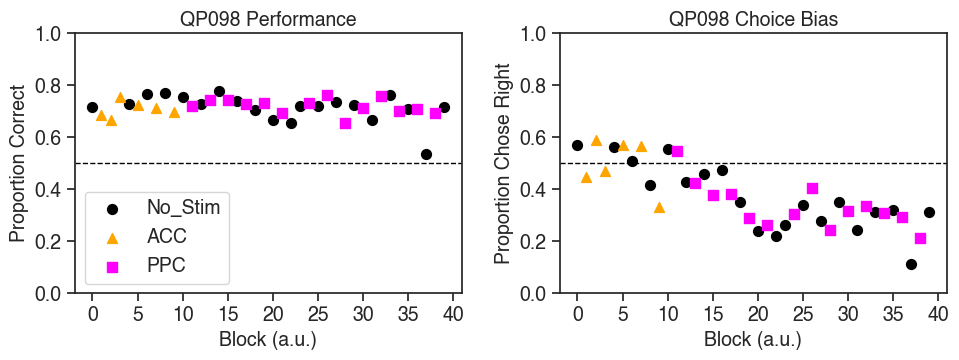

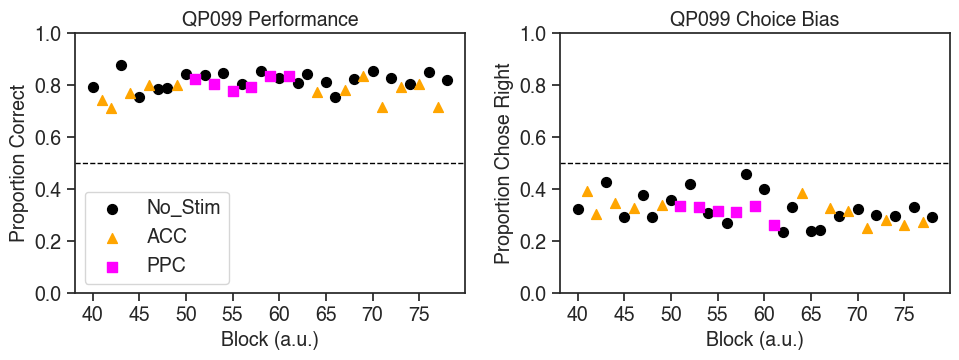

In [ ]:
# Calculate the proportion of correct responses per block for each participant (Performance)
grouped_df_perf = sub_df.groupby(['Participant_ID', 'block', 'Opto_Condition'])['correct'].agg(['mean', 'count']).reset_index()

# Calculate the proportion of correct responses per block for each participant (Choice)
grouped_df_choice = sub_df.groupby(['Participant_ID', 'block', 'Opto_Condition'])['choice'].agg(['mean', 'count']).reset_index()

# Marker dictionary for different opto conditions
marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}

# Plotting
participants = grouped_df_perf['Participant_ID'].unique()

for participant in participants:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Performance Plot
    participant_data_perf = grouped_df_perf[grouped_df_perf['Participant_ID'] == participant]
    for opto_condition, marker in marker_dict.items():
        condition_data = participant_data_perf[participant_data_perf['Opto_Condition'] == opto_condition]
        if not condition_data.empty:
            axes[0].scatter(condition_data.index, condition_data['mean'], label=opto_condition, 
                            marker=opto_condition_dict[opto_condition]['marker'], s=50, 
                            color=opto_condition_dict[opto_condition]['color'])
    axes[0].set_ylim(0, 1)
    axes[0].axhline(0.5, color='black', linestyle='--', linewidth=1)
    # don't show decimals on the x-axis
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].set_title(f'{participant} Performance')
    axes[0].set_xlabel('Block (a.u.)')
    axes[0].set_ylabel('Proportion Correct')
    axes[0].legend()
    
    # Choice Plot
    participant_data_choice = grouped_df_choice[grouped_df_choice['Participant_ID'] == participant]
    for opto_condition, marker in marker_dict.items():
        condition_data = participant_data_choice[participant_data_choice['Opto_Condition'] == opto_condition]
        if not condition_data.empty:
            axes[1].scatter(condition_data.index, condition_data['mean'], label=opto_condition, 
                            marker=opto_condition_dict[opto_condition]['marker'], s=50, 
                            color=opto_condition_dict[opto_condition]['color'])
    axes[1].set_ylim(0, 1)
    axes[1].axhline(0.5, color='black', linestyle='--', linewidth=1)
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].set_title(f'{participant} Choice Bias')
    axes[1].set_xlabel('Block (a.u.)')
    axes[1].set_ylabel('Proportion Chose Right')
    # axes[1].legend()
    
    plt.tight_layout()
    plt.show()

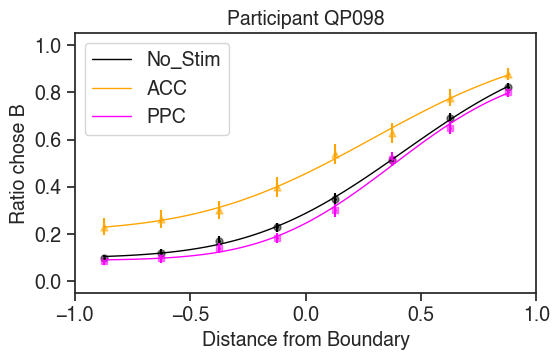

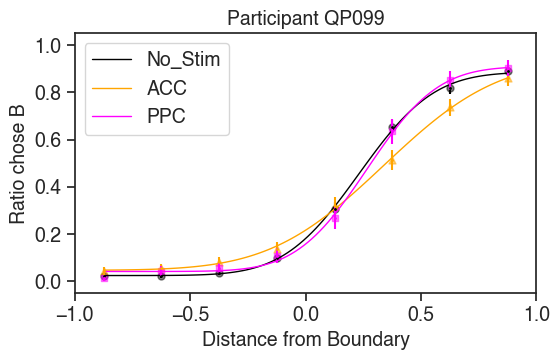

In [ ]:
# Generate psychometric curves for different Opto_Condition values for both participants
opto_conditions = ['No_Stim', 'ACC', 'PPC']
participants = sub_df['Participant_ID'].unique()

# Plot settings
colors = ['black', 'red', 'blue']  # Colors for No_Stim, ACC, PPC respectively

for participant in participants:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for opto_condition, color in zip(opto_conditions, colors):
        df_filtered = sub_df[(sub_df['Participant_ID'] == participant) & (sub_df['Opto_Condition'] == opto_condition)]
        if not df_filtered.empty:
            popt, _ = ut.psycho_fit(df_filtered)
            psycho_plot(df_filtered, popt, label=opto_condition, color=opto_condition_dict[opto_condition]['color'], 
                        marker=opto_condition_dict[opto_condition]['marker'], ax=ax, scatter=True, legend=True)

    ax.set_title(f'Participant {participant}')
    plt.tight_layout()

plt.show()

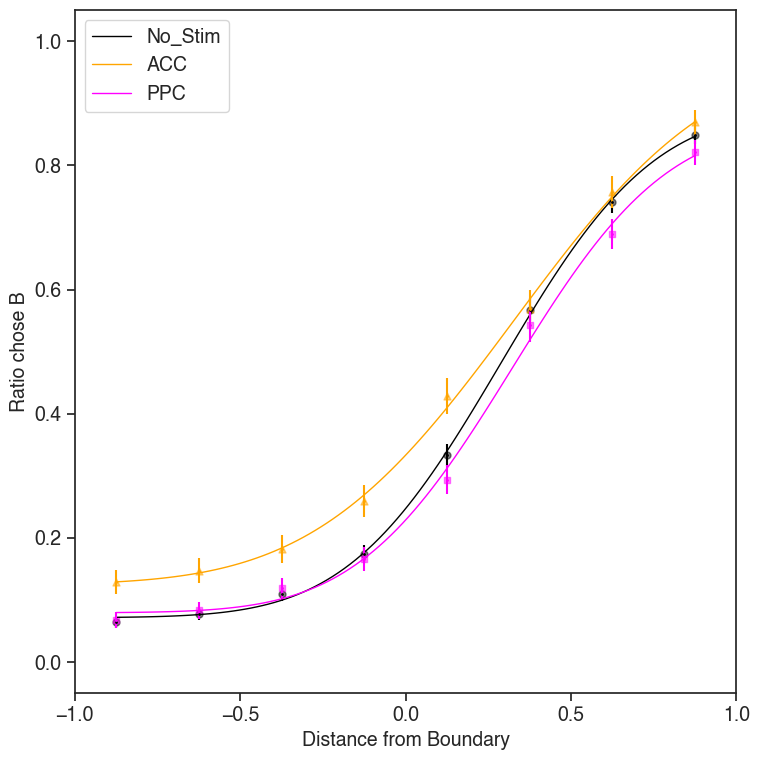

In [ ]:
# Generate psychometric curves for different Opto_Condition values for both participants
opto_conditions = ['No_Stim', 'ACC', 'PPC']
participants = sub_df['Participant_ID'].unique()

# Plot settings
colors = ['black', 'red', 'blue']  # Colors for No_Stim, ACC, PPC respectively


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for opto_condition, color in zip(opto_conditions, colors):
    df_filtered = sub_df[(sub_df['Opto_Condition'] == opto_condition)]
    if not df_filtered.empty:
        popt, _ = ut.psycho_fit(df_filtered)
        psycho_plot(df_filtered, popt, label=opto_condition, color=opto_condition_dict[opto_condition]['color'], 
                    marker=opto_condition_dict[opto_condition]['marker'], ax=ax, scatter=True, legend=True)

# ax.set_title(f' ')
plt.tight_layout()
# save the figure
plt.savefig(FIGS_PATH + 'Psycho_Curves_Opto_Unif.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
p_ids = ['QP098', 'QP099']
psych_params_df = ut.gen_blockwise_psych_params(sub_df, p_ids)
# rename the "Block" column to "block" in the psych_params_df dataframe
psych_params_df = psych_params_df.rename(columns={'Block': 'block'})
# Identifying composite key columns
composite_keys = ['Participant_ID', 'block']  # Replace with the actual key column names
# Dropping duplicate rows in data_df based on composite keys
sub_df_unique = sub_df.drop_duplicates(subset=composite_keys)
# Columns from data_df to merge
columns_to_merge = ['Opto_On', 'Fiber', 'Mask', 'Zapit', 'Stimulation_Site', 'Opto_Condition']
# Merging
psych_params_df = psych_params_df.merge(sub_df_unique[composite_keys + columns_to_merge], 
                                        on=composite_keys, how='left')

In [ ]:
# # First, we'll define a function to calculate the mean and SEM for the parameters
# def calculate_mean_sem(df, params):
#     means = df.groupby('Opto_Condition')[params].mean()
#     sems = df.groupby('Opto_Condition')[params].sem()
#     return means, sems

# # Define the parameters we're interested in
# params = ['Block_Means', 'Block_Slopes', 'Block_Lapses_1', 'Block_Lapses_2']

# # Calculate the mean and SEM for these parameters
# means, sems = calculate_mean_sem(psych_params_df, params)

# # Define the positions of the bars and the width
# bar_positions = np.arange(len(params))
# bar_width = 0.2

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# for i, opto_condition in enumerate(opto_conditions):
#     # Offsetting the bar positions so they don't overlap
#     offset = (i - len(opto_conditions)/2) * bar_width + bar_width/2
#     positions = bar_positions + offset
    
#     # Plotting the bars
#     ax.bar(positions, means.loc[opto_condition], width=bar_width, yerr=sems.loc[opto_condition],
#            capsize=5, label=opto_condition, color = opto_condition_dict[opto_condition]['color'], alpha=0.5)

#     # Plotting the individual data points
#     for j, param in enumerate(params):
#         # Filter the data for the opto_condition and parameter
#         df_filtered = psych_params_df[psych_params_df['Opto_Condition'] == opto_condition]
#         ax.scatter([positions[j]] * len(df_filtered), df_filtered[param], color=opto_condition_dict[opto_condition]['color'],
#                    alpha=0.5, s=10)

# # Customizing the plot
# ax.set_xticks(bar_positions)
# ax.set_xticklabels(['Mean', 'Sigma', 'Lapse 1', 'Lapse 2'])
# ax.set_ylabel('Parameter Value')
# ax.set_title('Parameter Values by Stimulation Condition with Offset')
# ax.legend(title='Stimulation Condition')

# # Display the plot
# plt.tight_layout()
# plt.show()

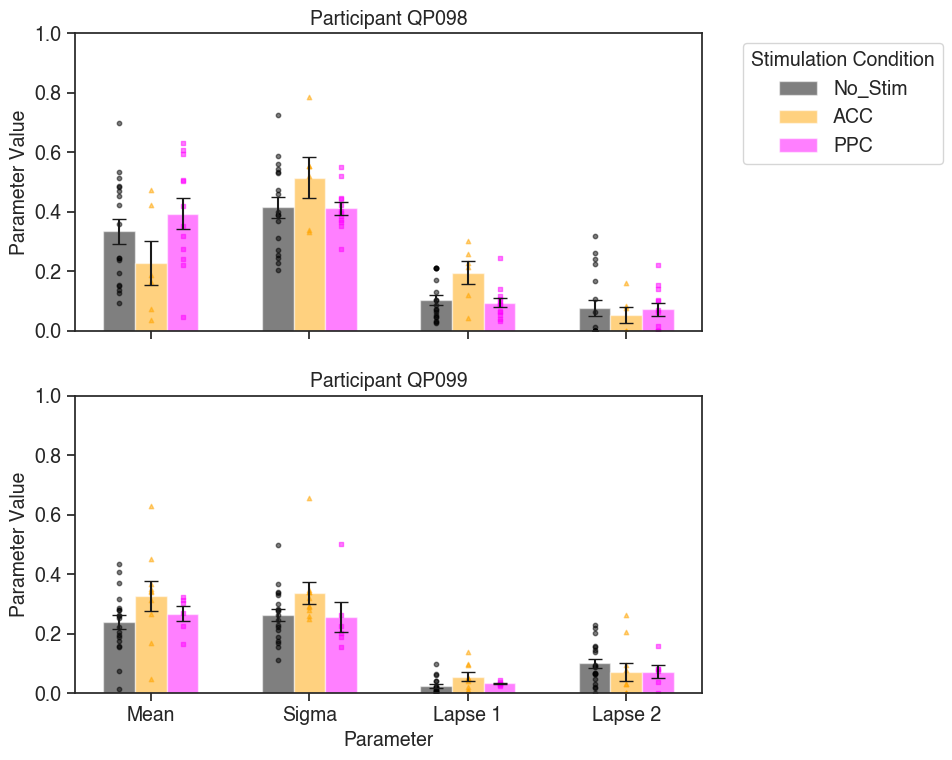

In [ ]:
def calculate_mean_sem(df, params):
    means = df.groupby('Opto_Condition')[params].mean()
    sems = df.groupby('Opto_Condition')[params].sem()
    return means, sems

# Define the parameters we're interested in
params = ['Block_Means', 'Block_Slopes', 'Block_Lapses_1', 'Block_Lapses_2']

# Calculate the mean and SEM for these parameters
means, sems = calculate_mean_sem(psych_params_df, params)

# Define the positions of the bars and the width
bar_positions = np.arange(len(params))
bar_width = 0.2

num_participants = len(participants)
fig, axs = plt.subplots(num_participants, 1, figsize=(10, 4*num_participants), sharex=True)

# If there's only one participant, we convert axs to an array
if num_participants == 1:
    axs = np.array([axs])

for idx, participant in enumerate(participants):
    # Calculate the mean and SEM for the current participant
    participant_data = psych_params_df[psych_params_df['Participant_ID'] == participant]
    means_participant, sems_participant = calculate_mean_sem(participant_data, params)
    
    for i, opto_condition in enumerate(opto_conditions):
        # Offsetting the bar positions so they don't overlap
        offset = (i - len(opto_conditions)/2) * bar_width + bar_width/2
        positions = bar_positions + offset
        
        # Plotting the bars for the current participant
        axs[idx].bar(positions, means_participant.loc[opto_condition], width=bar_width, yerr=sems_participant.loc[opto_condition],
                     capsize=5, label=opto_condition, color = opto_condition_dict[opto_condition]['color'], alpha=0.5)
        # add p_id to the title
        axs[idx].set_title(f'Participant {participant}')
        # set ylim
        axs[idx].set_ylim(0, 1)

        # Plotting the individual data points
        for j, param in enumerate(params):
            # Filter the data for the opto_condition and parameter
            df_filtered = participant_data[participant_data['Opto_Condition'] == opto_condition]
            axs[idx].scatter([positions[j]] * len(df_filtered), df_filtered[param], color=opto_condition_dict[opto_condition]['color'],
                             alpha=0.5, s=10, marker=opto_condition_dict[opto_condition]['marker'])

    # Customizing the plot
    axs[idx].set_ylabel('Parameter Value')
    axs[idx].set_xticks(bar_positions)
    axs[idx].set_xticklabels(['Mean', 'Sigma', 'Lapse 1', 'Lapse 2'])

    if idx == 0:
        axs[idx].legend(title='Stimulation Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-label only on the last subplot
axs[-1].set_xlabel('Parameter')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# send psych_params_df to the frontend
# psych_params_df.to_csv('/Users/quentin/Desktop/psych_params_df.csv', index=False)

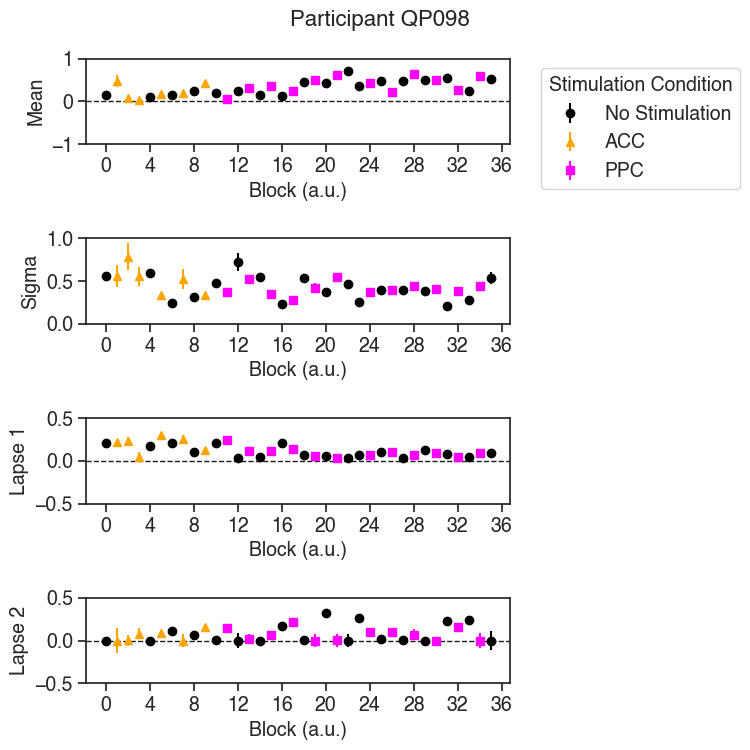

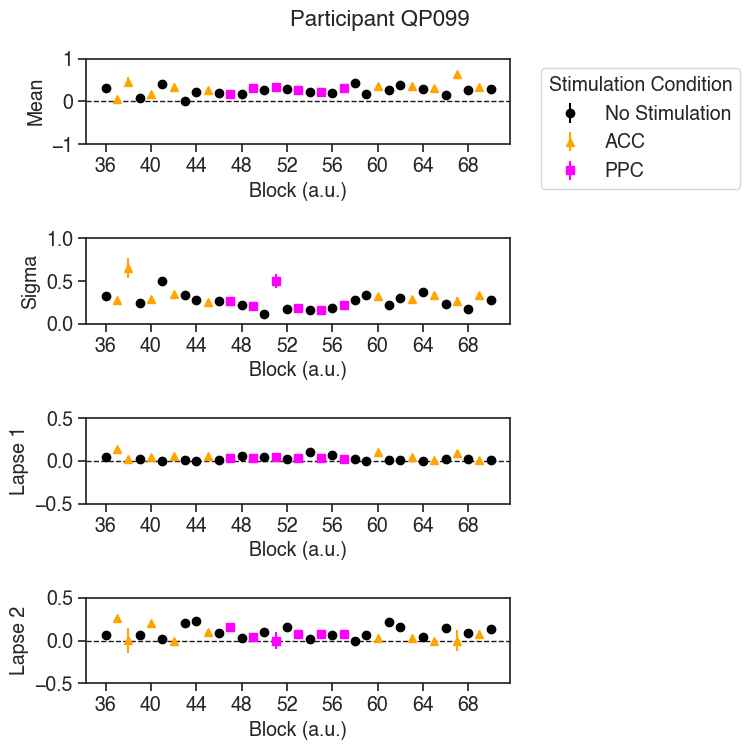

In [ ]:
# No change in the opto_condition_dict, as it's already optimal
opto_condition_dict = {
    'No_Stim': {'color': 'black', 'marker': 'o', 'label': 'No Stimulation'},
    'ACC': {'color': 'orange', 'marker': '^', 'label': 'ACC'},
    'PPC': {'color': 'magenta', 'marker': 's', 'label': 'PPC'}
}

# Define the plotting function
def plot_parameter_vs_index(ax, df, param, opto_condition_dict, participant, y_label, y_lim=None):
    for opto_condition, style in opto_condition_dict.items():
        condition_data = df[(df['Participant_ID'] == participant) & (df['Opto_Condition'] == opto_condition)]
        if not condition_data.empty:
            sem = condition_data[param+'_Std'] / np.sqrt(len(condition_data))
            ax.errorbar(condition_data.index, condition_data[param], yerr=sem,
                        fmt=style['marker'], label=style['label'], color=style['color'], linestyle='None')
    # ax.set_title(f'{participant}')
    ax.set_xlabel('Block (a.u.)')
    ax.axhline(0, color='k', linewidth=1, linestyle='--')
    ax.set_ylabel(y_label)
    if y_lim:
        ax.set_ylim(y_lim)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Create a plot for each parameter for each participant
for participant in participants:
    fig, axs = plt.subplots(4, 1, figsize=(8, 8), sharex=False)
    
    # Plot each parameter in a different subplot
    plot_parameter_vs_index(axs[0], psych_params_df, 'Block_Means', opto_condition_dict, participant, 'Mean', (-1, 1))
    plot_parameter_vs_index(axs[1], psych_params_df, 'Block_Slopes', opto_condition_dict, participant, 'Sigma', (0, 1))
    plot_parameter_vs_index(axs[2], psych_params_df, 'Block_Lapses_1', opto_condition_dict, participant, 'Lapse 1', (-0.5, 0.5))
    plot_parameter_vs_index(axs[3], psych_params_df, 'Block_Lapses_2', opto_condition_dict, participant, 'Lapse 2', (-0.5, 0.5))
    
    # Add legend to the first subplot
    axs[0].legend(title='Stimulation Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
    # put a title on the top of the figure
    fig.suptitle(f'Participant {participant}' , fontsize=16, y = 0.95)
    plt.tight_layout()
    plt.show()

## Effect on P(Stay)

In [ ]:
# add previous trial data to sub_df
sub_df = sub_df.groupby('Participant_ID', group_keys= False).apply(add_previous_n_trials_data, n=5)

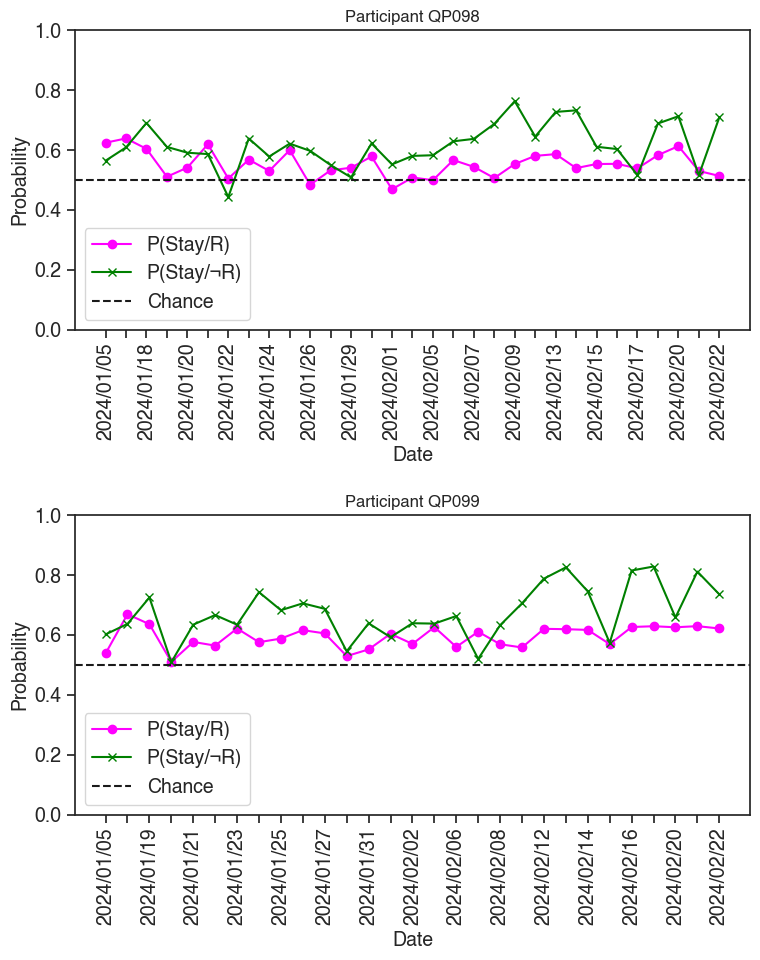

In [ ]:
# Assuming PARTICIPANTS and sub_df are defined above this code snippet
num_participants = len(PARTICIPANTS)
# Assuming a square-ish layout for subplots, adjust as necessary
rows = int(np.ceil(np.sqrt(num_participants)))
cols = int(np.ceil(num_participants / rows))

fig, axs = plt.subplots(rows, cols, figsize=(8, 10), squeeze=False)  # Use squeeze=False for consistent indexing

line_colors = {'P(Stay)': 'blue', 'P(Stay/R)': 'magenta', 'P(Stay/¬R)': 'green'}

for idx, participant in enumerate(PARTICIPANTS):
    # Calculate subplot indices
    row_idx = idx // cols
    col_idx = idx % cols
    
    participant_df = sub_df[sub_df['Participant_ID'] == participant]
    dates = participant_df['Date'].unique()

    p_stay_given_reward = []
    p_stay_given_no_reward = []
    p_switch_given_no_reward = []

    for date in dates:
        date_df = participant_df[participant_df['Date'] == date]
        _, p_r, p_nr = compute_p_stay(date_df)  # Adjust as needed if compute_p_stay's implementation changes
        _, p_s_r, p_s_nr = compute_p_switch(date_df)
        p_stay_given_reward.append(p_r)
        p_stay_given_no_reward.append(p_nr)
        p_switch_given_no_reward.append(p_s_nr)

    # Plotting on the calculated subplot
    ax = axs[row_idx, col_idx]
    ax.plot(dates, p_stay_given_reward, '-o', label='P(Stay/R)', color=line_colors['P(Stay/R)'])
    # ax.plot(dates, p_switch_given_no_reward, '-x', label='P(Switch/¬R)', color=line_colors['P(Stay/¬R)'])
    ax.plot(dates, p_stay_given_no_reward, '-x', label='P(Stay/¬R)', color=line_colors['P(Stay/¬R)'])
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='k', linestyle='--', label='Chance')
    ax.set_xlabel('Date')
    ax.set_ylabel('Probability')
    ax.set_title(f'Participant {participant}', fontdict={'fontsize': 12})
    ax.legend()
    ax.tick_params(axis='x', rotation=90)
    for i, label in enumerate(ax.get_xticklabels()):
        if i % 2 != 0:
            label.set_visible(False)

# Adjust layout for the figure with multiple subplots
plt.tight_layout()

plt.show()


In [ ]:
# send sub_df to the frontend
sub_df.to_csv('/Users/quentin/Desktop/sub_df.csv', index=False)

In [ ]:
p_stay_given_reward, p_stay_given_no_reward 

(0.5525143220878421, 0.6186335403726708)

## GLM Quantifying Trial History

In [ ]:
def prep_GLM_data(df, 
                #   p_id, date, 
                #  condition,
                 columns_to_keep, n_trials_back):
    """
    Prepares the data for GLM fitting by adding columns for previous trial data and filtering the dataframe.
    
    Args:
        df (pd.DataFrame): The input dataframe
        p_id (str): The participant ID
        date (str): The date
        columns_to_keep (list): The columns to keep in the output dataframe
        n_trials_back (int): The number of previous trials to include in the output dataframe

    Returns:
        X (pd.DataFrame): The input dataframe (regressors) with additional columns for previous trial data
        y (pd.Series): The choice column (dependent variable)
    """
    # sub_df = df[(df['Participant_ID'] == p_id) & (df['Date'] == date)].reset_index(drop=True)
    # Filter for the given condition
    # sub_df = df[df['Opto_Condition'] == condition]
    sub_df = df.groupby('Participant_ID').apply(add_previous_n_trials_data, n=n_trials_back)
    sub_df = sub_df[columns_to_keep]
    
    # add rewarded and unrewarded choice columns
    for i in range(1, n_trials_back + 1):
        sub_df[f'Rewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 1), 1, 
                                              np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 0), -1, 0))
        sub_df[f'Unrewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 1), 1, 
                                                np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 0), -1, 0))
        
    sub_df = sub_df[sub_df.No_response == False].reset_index(drop=True)
    # drop any rows where choice_1, stim_relative_1, stim_relative_binned or choice is nan
    sub_df = sub_df.dropna(subset=["stim_relative_binned", "stim_relative_1", "stim_relative_2", "stim_relative_3", 
                                   "stim_relative_4", "stim_relative_5","Rewarded_Choice_1", "Rewarded_Choice_2", 
                                   "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5", "Unrewarded_Choice_1",
                                      "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5",
                                        "choice"]).reset_index(drop=True)
    
    X = sub_df[[
            "Stim_Relative", 
            "stim_relative_1", "stim_relative_2", "stim_relative_3", "stim_relative_4", "stim_relative_5",
            "Rewarded_Choice_1", "Rewarded_Choice_2", "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5",
            "Unrewarded_Choice_1", "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5"
            ]] 
    
    y = sub_df['choice']
    
    return X, y

def fit_GLM(X, y):
    """
    Fits a GLM to the data and returns the model.

    Args:
        X (pd.DataFrame): The input dataframe (regressors)
        y (pd.Series): The choice column (dependent variable)

    Returns:
        mean_cv_score (float): The mean cross-validation score
        log_reg_l1 (LogisticRegression): The fitted logistic regression model
    """
    log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
    log_reg_l1.fit(X, y)

    # Perform k-fold cross-validation (e.g., k=5)
    k_fold = 5
    cv_scores = cross_val_score(log_reg_l1, X, y, cv=k_fold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)

    return mean_cv_score, log_reg_l1

def train_and_evaluate_GLM(X_train, X_test, y_train, y_test):
    '''
    Trains and evaluates a logistic regression model.
    Args:
        X_train (np.array): The training data (regressors)
        X_test (np.array): The testing data (regressors)
        y_train (np.array): The training data (dependent variable)
        y_test (np.array): The testing data (dependent variable)
    Returns:
        coefficients (np.array): The coefficients from the logistic regression model
        intercept (float): The intercept from the logistic regression model
        accuracy (float): The accuracy of the logistic regression model
    '''

    model = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model.coef_[0], model.intercept_[0], accuracy_score(y_test, y_pred)

def gen_coef_df(X, y, bootstrap_samples, n_folds):
    '''
    Generates a DataFrame with regression coefficients, confidence intervals, 
    and model accuracy after bootstrapping.
    Args:
        X (pd.DataFrame): The input data (regressors)
        y (pd.Series): The output data (dependent variable)
        bootstrap_samples (int): The number of bootstrap samples
        n_folds (int): The number of folds for KFold cross-validation
    Returns:
        coef_df (pd.DataFrame): A DataFrame containing the regressors, their 
        coefficients, confidence intervals, and model accuracy.
    '''
    X_np, y_np = X.values, y.values
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

    results = Parallel(n_jobs=-1)(delayed(train_and_evaluate_GLM)(
        X_np[train_index], X_np[test_index], y_np[train_index], y_np[test_index])
        for i in range(bootstrap_samples) 
        for train_index, test_index in kf.split(X_np))

    coefficients = np.array([coef for coef, _, _ in results])
    intercepts = np.array([intercept for _, intercept, _ in results])
    accuracies = np.array([acc for _, _, acc in results])

    # Calculate the means and confidence intervals for coefficients
    coefficients_mean = np.mean(coefficients, axis=0)
    coefficients_conf_int_low = np.percentile(coefficients, 2.5, axis=0)
    coefficients_conf_int_high = np.percentile(coefficients, 97.5, axis=0)

    # Calculate the mean and confidence intervals for the intercept
    intercept_mean = np.mean(intercepts)
    intercept_conf_int_low = np.percentile(intercepts, 2.5)
    intercept_conf_int_high = np.percentile(intercepts, 97.5)

    # Combine the coefficients and the intercept into the DataFrame
    # Add a new row for the intercept in the DataFrame
    intercept_row = pd.DataFrame({
        'Regressor': ['Intercept'],
        'Coefficient': [intercept_mean],
        'Conf_Int_Low': [intercept_conf_int_low],
        'Conf_Int_High': [intercept_conf_int_high],
        'Accuracy': [np.mean(accuracies)]
    })

    coef_df = pd.DataFrame({
        'Regressor': X.columns,
        'Coefficient': coefficients_mean,
        'Conf_Int_Low': coefficients_conf_int_low,
        'Conf_Int_High': coefficients_conf_int_high
    })
    
    coef_df['Regressor'] = coef_df['Regressor'].replace('Stim_Relative', 'stim_relative_0')


    # Append the intercept row to the coefficients DataFrame
    coef_df = pd.concat([coef_df, intercept_row], ignore_index=True)

    # Add the average accuracy for all models as a new column
    coef_df['Accuracy'] = np.mean(accuracies)

    return coef_df

def plot_GLM_weights(coef_df, color_label_dict, ax, marker):
    '''
    Plots the GLM weights for the stimulus, rewarded, and unrewarded regressors, 5 trials back, with specified colors for each type and a unified marker style.
    Args:
        coef_df (pd.DataFrame): The dataframe containing the coefficients for a specific condition.
        color_label_dict (dict): A dictionary specifying the colors and labels for stimulus, rewarded, and unrewarded data.
        ax (matplotlib.axes.Axes): The axes object to plot on.
        marker (str): The marker style for the plots.
    '''
    background_alpha = 0.6
    trial_numbers = np.arange(0, -6, -1)
    marker_size = 7
    
    # Extracting data by type
    stim_data = coef_df[coef_df['Regressor'].str.contains('stim_relative')]
    rewarded_data = coef_df[coef_df['Regressor'].str.contains('Rewarded_Choice')]
    unrewarded_data = coef_df[coef_df['Regressor'].str.contains('Unrewarded_Choice')]
    
    # Stimulus data
    if not stim_data.empty:
        ax.errorbar(trial_numbers[:len(stim_data)], stim_data['Coefficient'], 
                    yerr=[stim_data['Coefficient'] - stim_data['Conf_Int_Low'], stim_data['Conf_Int_High'] - stim_data['Coefficient']], 
                    fmt=marker, color=color_label_dict['Stimulus']['color'],
                    label=color_label_dict['Stimulus']['label'], alpha=background_alpha, markersize=marker_size)
        ax.plot(trial_numbers[:len(stim_data)], stim_data['Coefficient'], marker=marker, linestyle='-', color=color_label_dict['Stimulus']['color'], markersize=marker_size)
    
    # Rewarded Choices
    if not rewarded_data.empty:
        ax.errorbar(trial_numbers[1:], rewarded_data['Coefficient'], 
                    yerr=[rewarded_data['Coefficient'] - rewarded_data['Conf_Int_Low'], rewarded_data['Conf_Int_High'] - rewarded_data['Coefficient']], 
                    fmt=marker, color=color_label_dict['Rewarded_Choice']['color'],
                    label=color_label_dict['Rewarded_Choice']['label'], alpha=background_alpha, markersize=marker_size)
        ax.plot(trial_numbers[1:], rewarded_data['Coefficient'], marker=marker, linestyle='-', color=color_label_dict['Rewarded_Choice']['color'], markersize=marker_size)
    
    # Unrewarded Choices
    if not unrewarded_data.empty:
        ax.errorbar(trial_numbers[1:], unrewarded_data['Coefficient'], 
                    yerr=[unrewarded_data['Coefficient'] - unrewarded_data['Conf_Int_Low'], unrewarded_data['Conf_Int_High'] - unrewarded_data['Coefficient']], 
                    fmt=marker, color=color_label_dict['Unrewarded_Choice']['color'],
                    label=color_label_dict['Unrewarded_Choice']['label'], alpha=background_alpha, markersize=marker_size)
        ax.plot(trial_numbers[1:], unrewarded_data['Coefficient'], marker=marker, linestyle='-', color=color_label_dict['Unrewarded_Choice']['color'], markersize=marker_size)

    # Bias
    bias_coef = coef_df[coef_df['Regressor'] == 'Intercept']['Coefficient'].values[0]
    bias_ci_low = coef_df[coef_df['Regressor'] == 'Intercept']['Conf_Int_Low'].values[0]
    bias_ci_high = coef_df[coef_df['Regressor'] == 'Intercept']['Conf_Int_High'].values[0]

    ax.errorbar(-5.5, bias_coef, 
                yerr=[[bias_coef - bias_ci_low], [bias_ci_high - bias_coef]], 
                fmt=marker, color=color_label_dict['Bias']['color'],
                label=color_label_dict['Bias']['label'], alpha=background_alpha, markersize=marker_size)

    ax.set_xlabel('Trials Back')
    ax.set_ylabel('Coefficient')
    ax.axhline(0, color='grey', linestyle='--')

    # Create custom handles for the legend if needed or use ax.legend() directly
    handles = [plt.Line2D([], [], marker=marker, color=info['color'], label=info['label'], linestyle='-') for info in color_label_dict.values()]

    plt.tight_layout()

    return handles

In [ ]:
PARTICIPANT = 'QP099'
sub_df = df[df['Participant_ID'] == PARTICIPANT]
# only keep data where Distribution is Uniform
sub_df = sub_df[sub_df['Distribution'] == 'Uniform']
# remove No_response trials
sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)

# find the earliest Date where Opto_Condition is not 'No_Stim'
earliest_stim = sub_df[sub_df['Opto_Condition'] != 'No_Stim']['Datetime'].min()
# find the most recent Date before the earliest Date where Opto_Condition is not 'No_Stim'
earliest_no_stim = sub_df[sub_df['Datetime'] < earliest_stim]['Datetime'].max()
# Keep data from earliest_no_stim onwards
sub_df = sub_df[sub_df['Datetime'] >= earliest_no_stim].reset_index(drop=True)
# add previous n trials data
sub_df = sub_df.groupby('Participant_ID', group_keys= False).apply(add_previous_n_trials_data)

In [ ]:
columns_to_keep = [
                   'Date', 'Participant_ID','Trial', 'Stim_Relative', 'correct', 'No_response',
                   'First_Lick', 'P_Right','Response_Latency', 'Trial_Outcome',
                   'Anti_Bias','Timeout_Duration', 'Emulator', 'Distribution','Datetime',
                   'block', 'Incorrect', 'No_Response', 'choice', 'Rule_Right',
                   'Choice_Rule_Diff', 'stim_relative_binned', 'stim_relative_1',
                   'choice_1', 'correct_1', 'stim_relative_2', 'choice_2', 'correct_2',
                   'stim_relative_3', 'choice_3', 'correct_3', 'stim_relative_4',
                   'choice_4', 'correct_4', 'stim_relative_5', 'choice_5', 'correct_5'
                   ]
X, y = prep_GLM_data(sub_df, columns_to_keep, n_trials_back=5)

In [ ]:
conditions = sub_df['Opto_Condition'].unique()
all_coef_dfs = []

for condition in conditions:
    # Filter data for the current condition
    condition_df = sub_df[sub_df['Opto_Condition'] == condition]

    X, y = prep_GLM_data(condition_df, columns_to_keep, n_trials_back=5)

    # drop all stim columns from X
    X = X.drop(columns=[
        'stim_relative_1', 'stim_relative_2', 'stim_relative_3', 'stim_relative_4', 'stim_relative_5', 
        #                 'Stim_Relative',
        # 'Rewarded_Choice_1',
        # 'Rewarded_Choice_2', 'Rewarded_Choice_3', 'Rewarded_Choice_4', 'Rewarded_Choice_5',
        # 'Unrewarded_Choice_1', 
        # 'Unrewarded_Choice_2', 'Unrewarded_Choice_3', 'Unrewarded_Choice_4', 'Unrewarded_Choice_5'
                        ])

    mean_cv_score, log_reg_l1 = fit_GLM(X, y)

    print(f'Mean CV score for {condition}: {mean_cv_score}')

    coef_df = gen_coef_df(X, y, bootstrap_samples=10, n_folds=5)

    coef_df['Condition'] = condition  # Add a column to identify the condition

    all_coef_dfs.append(coef_df)

# Combine all coefficients dataframes into one
all_coef_df = pd.concat(all_coef_dfs, ignore_index=True)


Mean CV score for No_Stim: 0.875396359365825
Mean CV score for ACC: 0.8334740514330523
Mean CV score for PPC: 0.870985852858612


In [ ]:
len(coef_df[coef_df['Regressor'].str.contains('stim_relative')])

1

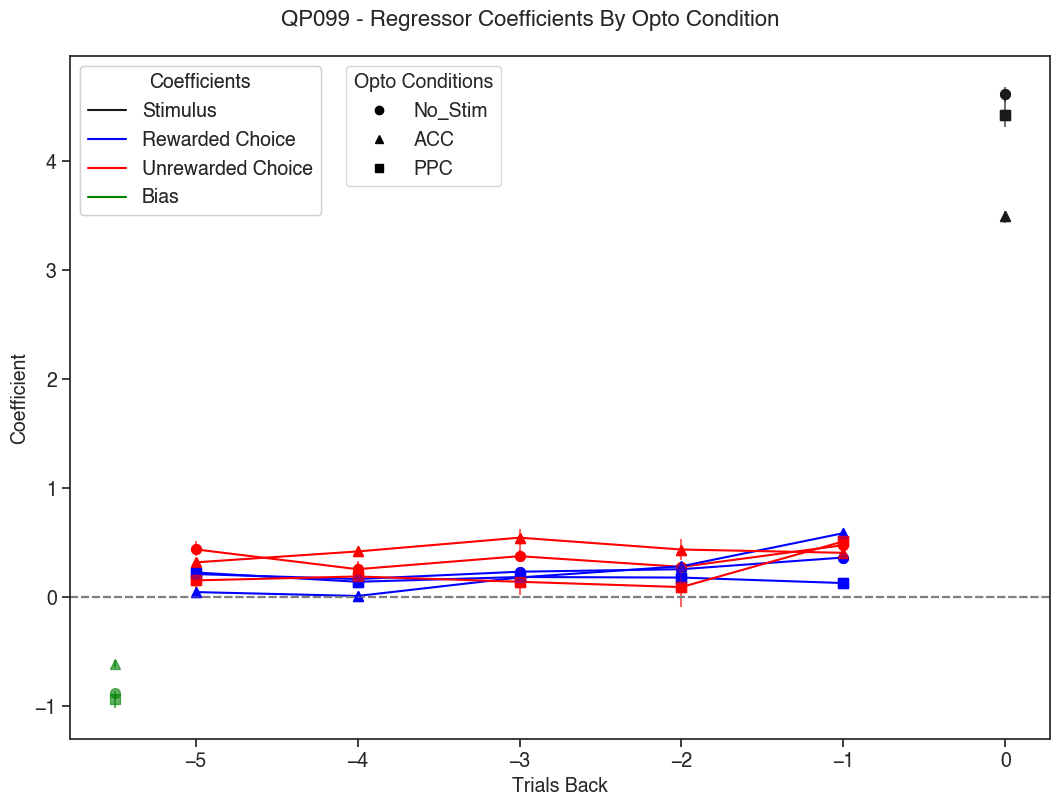

In [ ]:
color_label_dict = {
    'Stimulus': {'color': 'k', 'label': 'Stimulus'},  # Light Blue
    'Rewarded_Choice': {'color': 'blue', 'label': 'Rewarded Choice'},  # Light Green
    'Unrewarded_Choice': {'color': 'red', 'label': 'Unrewarded Choice'},  # Light Coral
    'Bias': {'color': 'green', 'label': 'Bias'}  # Light Goldenrod Yellow
}


# specify a marker dict for No_Stim, ACC and PPC
marker_dict = {
              'No_Stim': 'o',
              'ACC': '^',
              'PPC': 's'
              }

fig, ax = plt.subplots(figsize=(11, 8))
color_handles = []  # List to collect color legend handles
marker_handles = []  # List to collect marker legend handles

color_handles.extend(plot_GLM_weights(all_coef_df[all_coef_df['Condition'] == 'No_Stim'], 
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['No_Stim']))
color_handles.extend(plot_GLM_weights(all_coef_df[all_coef_df['Condition'] == 'ACC'], 
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['ACC']))
color_handles.extend(plot_GLM_weights(all_coef_df[all_coef_df['Condition'] == 'PPC'], 
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['PPC']))

color_handles = [plt.Line2D([], [], color=color_info['color'], linestyle='-', label=color_info['label'])
                 for color_info in color_label_dict.values()]

for condition, marker in marker_dict.items():
    marker_handles.append(plt.Line2D([], [], color='black', marker=marker, linestyle='None', label=condition))

color_legend = ax.legend(handles=color_handles, loc='upper left', title="Coefficients")

ax.add_artist(color_legend)  # Manually add the color legend back
marker_legend = ax.legend(handles=marker_handles,
                           bbox_to_anchor=(0.45, 1),
                             title="Opto Conditions")

ax.add_artist(color_legend)

fig.suptitle(PARTICIPANT + ' - Regressor Coefficients By Opto Condition', fontsize=16, y=1.02)
plt.savefig(FIGS_PATH + PARTICIPANT + '_GLM_weights_by_opto_condition.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
# Break here
raise Exception('Break here')

Exception: Break here

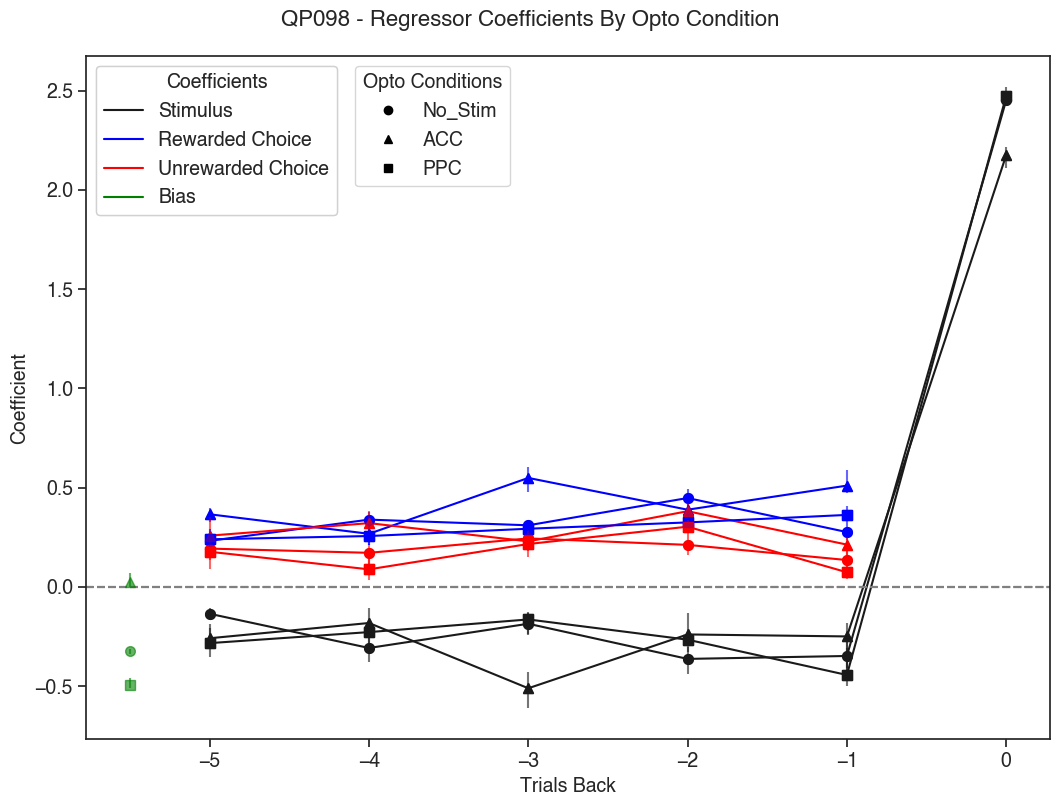

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
color_handles = []  # List to collect color legend handles
marker_handles = []  # List to collect marker legend handles

color_handles.extend(plot_GLM_weights(all_coef_df[all_coef_df['Condition'] == 'No_Stim'], 
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['No_Stim']))
color_handles.extend(plot_GLM_weights(all_coef_df[all_coef_df['Condition'] == 'ACC'], 
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['ACC']))
color_handles.extend(plot_GLM_weights(all_coef_df[all_coef_df['Condition'] == 'PPC'], 
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['PPC']))

color_handles = [plt.Line2D([], [], color=color_info['color'], linestyle='-', label=color_info['label'])
                 for color_info in color_label_dict.values()]

for condition, marker in marker_dict.items():
    marker_handles.append(plt.Line2D([], [], color='black', marker=marker, linestyle='None', label=condition))

color_legend = ax.legend(handles=color_handles, loc='upper left', title="Coefficients")

ax.add_artist(color_legend)  # Manually add the color legend back
marker_legend = ax.legend(handles=marker_handles,
                           bbox_to_anchor=(0.45, 1),
                             title="Opto Conditions")

ax.add_artist(color_legend)

fig.suptitle(PARTICIPANT + ' - Regressor Coefficients By Opto Condition', fontsize=16, y=1.02)
plt.savefig(FIGS_PATH + PARTICIPANT + '_GLM_weights_by_opto_condition.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
X.dtypes

Stim_Relative          float64
stim_relative_1        float64
stim_relative_2        float64
stim_relative_3        float64
stim_relative_4        float64
stim_relative_5        float64
Rewarded_Choice_1      float64
Rewarded_Choice_2      float64
Rewarded_Choice_3      float64
Rewarded_Choice_4      float64
Rewarded_Choice_5      float64
Unrewarded_Choice_1    float64
Unrewarded_Choice_2    float64
Unrewarded_Choice_3    float64
Unrewarded_Choice_4    float64
Unrewarded_Choice_5    float64
dtype: object

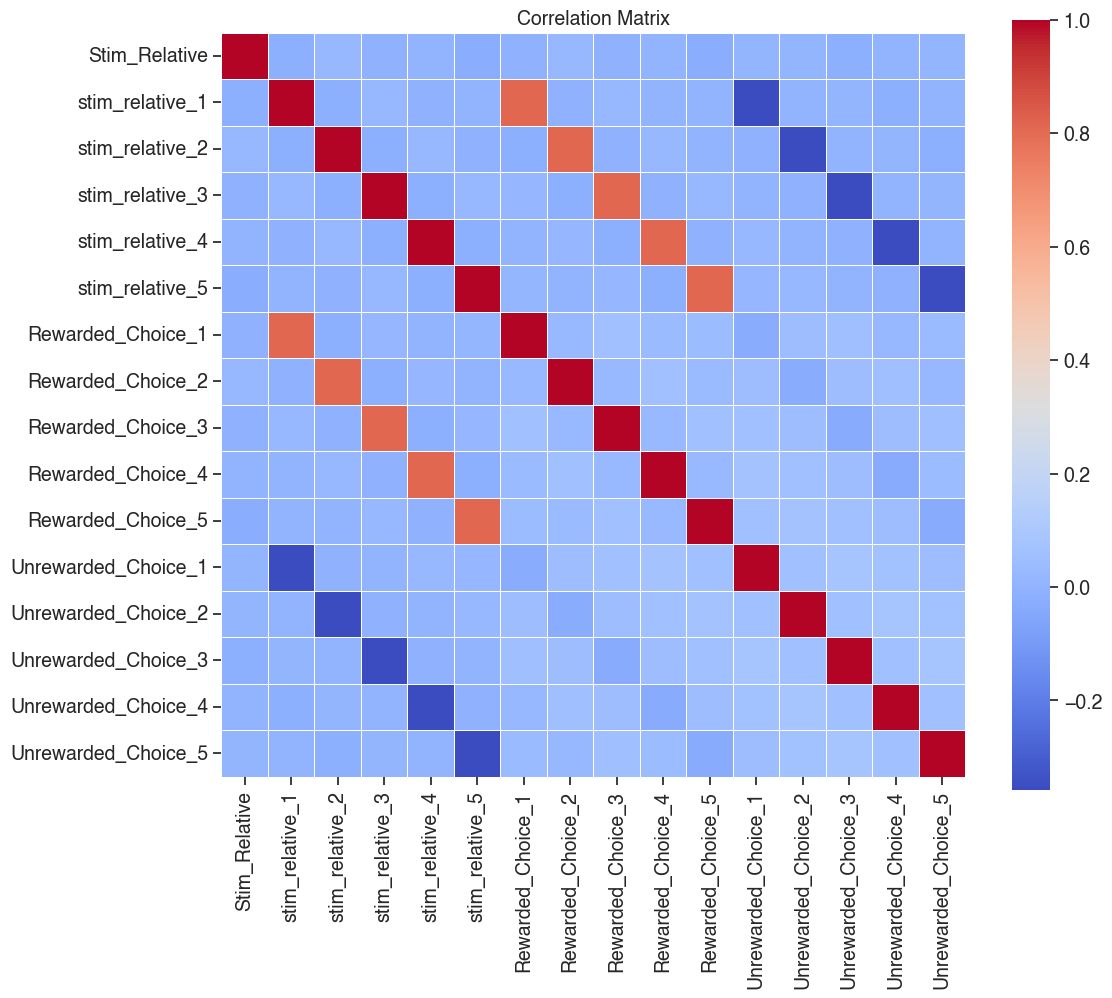

In [ ]:
# convert all object columns to float
for col in X.columns:
    X[col] = X[col].astype(float)
correlation_matrix = X.corr()
# Generate a heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2", cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

,Rewarded_Choice_1,Rewarded_Choice_2,Rewarded_Choice_3,Rewarded_Choice_4,Rewarded_Choice_5,Unrewarded_Choice_1,Unrewarded_Choice_2,Unrewarded_Choice_3,Unrewarded_Choice_4,Unrewarded_Choice_5
Rewarded_Choice_1,1.000000,0.027757,0.057152,0.030618,0.035640,-0.033085,0.041993,0.053597,0.022567,0.034890
Rewarded_Choice_2,0.027757,1.000000,0.027001,0.056814,0.030572,0.043979,-0.033205,0.041854,0.052196,0.021707
Rewarded_Choice_3,0.057152,0.027001,1.000000,0.027043,0.057141,0.058246,0.043565,-0.033647,0.041068,0.052946
Rewarded_Choice_4,0.030618,0.056814,0.027043,1.000000,0.027235,0.069918,0.058064,0.044291,-0.033790,0.040157
Rewarded_Choice_5,0.035640,0.030572,0.057141,0.027235,1.000000,0.059971,0.070203,0.058306,0.045157,-0.033811
Unrewarded_Choice_1,-0.033085,0.043979,0.058246,0.069918,0.059971,1.000000,0.060593,0.081534,0.063498,0.042450
Unrewarded_Choice_2,0.041993,-0.033205,0.043565,0.058064,0.070203,0.060593,1.000000,0.060201,0.081376,0.062700
Unrewarded_Choice_3,0.053597,0.041854,-0.033647,0.044291,0.058306,0.081534,0.060201,1.000000,0.059966,0.080538
Unrewarded_Choice_4,0.022567,0.052196,0.041068,-0.033790,0.045157,0.063498,0.081376,0.059966,1.000000,0.057748
Unrewarded_Choice_5,0.034890,0.021707,0.052946,0.040157,-0.033811,0.042450,0.062700,0.080538,0.057748,1.000000


In [ ]:
# send X to the frontend
X.to_csv('/Users/quentin/Desktop/X.csv', index=False)

In [ ]:
correlation_matrix

,Rewarded_Choice_1,Rewarded_Choice_2,Rewarded_Choice_3,Rewarded_Choice_4,Rewarded_Choice_5,Unrewarded_Choice_1,Unrewarded_Choice_2,Unrewarded_Choice_3,Unrewarded_Choice_4,Unrewarded_Choice_5
Rewarded_Choice_1,1.000000,0.027757,0.057152,0.030618,0.035640,-0.033085,0.041993,0.053597,0.022567,0.034890
Rewarded_Choice_2,0.027757,1.000000,0.027001,0.056814,0.030572,0.043979,-0.033205,0.041854,0.052196,0.021707
Rewarded_Choice_3,0.057152,0.027001,1.000000,0.027043,0.057141,0.058246,0.043565,-0.033647,0.041068,0.052946
Rewarded_Choice_4,0.030618,0.056814,0.027043,1.000000,0.027235,0.069918,0.058064,0.044291,-0.033790,0.040157
Rewarded_Choice_5,0.035640,0.030572,0.057141,0.027235,1.000000,0.059971,0.070203,0.058306,0.045157,-0.033811
Unrewarded_Choice_1,-0.033085,0.043979,0.058246,0.069918,0.059971,1.000000,0.060593,0.081534,0.063498,0.042450
Unrewarded_Choice_2,0.041993,-0.033205,0.043565,0.058064,0.070203,0.060593,1.000000,0.060201,0.081376,0.062700
Unrewarded_Choice_3,0.053597,0.041854,-0.033647,0.044291,0.058306,0.081534,0.060201,1.000000,0.059966,0.080538
Unrewarded_Choice_4,0.022567,0.052196,0.041068,-0.033790,0.045157,0.063498,0.081376,0.059966,1.000000,0.057748
Unrewarded_Choice_5,0.034890,0.021707,0.052946,0.040157,-0.033811,0.042450,0.062700,0.080538,0.057748,1.000000


In [ ]:
X.dtypes

Stim_Relative          object
stim_relative_1        object
stim_relative_2        object
stim_relative_3        object
stim_relative_4        object
stim_relative_5        object
Rewarded_Choice_1       int64
Rewarded_Choice_2       int64
Rewarded_Choice_3       int64
Rewarded_Choice_4       int64
Rewarded_Choice_5       int64
Unrewarded_Choice_1     int64
Unrewarded_Choice_2     int64
Unrewarded_Choice_3     int64
Unrewarded_Choice_4     int64
Unrewarded_Choice_5     int64
dtype: object

In [ ]:
# TO-DO: include a bar plot comparing coefficients (summed over trials) for each condition

In [ ]:
# Break execution here
raise Exception('Execution stopped')

Exception: Execution stopped

## Analysis of Opto_Condition of distribution switches

In [27]:
# Isolate the data for the participants of interest
# PARTICIPANTS = ['QP0100', 'QP0101']
PARTICIPANTS = ANIMAL_LIST
sub_df = df[df['Participant_ID'].isin(PARTICIPANTS)]
# remove No_response trials
sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)
# remove rows where Opto_Condition is nan
sub_df = sub_df.dropna(subset=['Opto_Condition']).reset_index(drop=True)

In [ ]:
# find the earliest Date where Opto_Condition is not 'No_Stim'
earliest_stim = sub_df[sub_df['Opto_Condition'] != 'No_Stim']['Datetime'].min()
# find the most recent Date before the earliest Date where Opto_Condition is not 'No_Stim'
earliest_no_stim = sub_df[sub_df['Datetime'] < earliest_stim]['Datetime'].max()
# Subtract 5 days from earliest_no_stim
start_date = earliest_no_stim - pd.Timedelta(days=15)
# Keep data from earliest_no_stim onwards
sub_df = sub_df[sub_df['Datetime'] >= start_date].reset_index(drop=True)

In [ ]:
# filter data because of sleeve issue with QP0100
# remove data between blocks 96 and 105 (inclusive) for QP0100
sub_df = sub_df[~((sub_df['Participant_ID'] == 'QP0100') & (sub_df['block'] >= 96) & (sub_df['block'] <= 105))].reset_index(drop=True)

In [28]:
# make an opto_cond_dict to associate each condition with a color and marker
opto_condition_dict = {
    'No_Stim': {'color': 'black', 'marker': 'o'},
    'ACC': {'color': 'orange', 'marker': '^'},
    'PPC': {'color': 'magenta', 'marker': 's'}
}

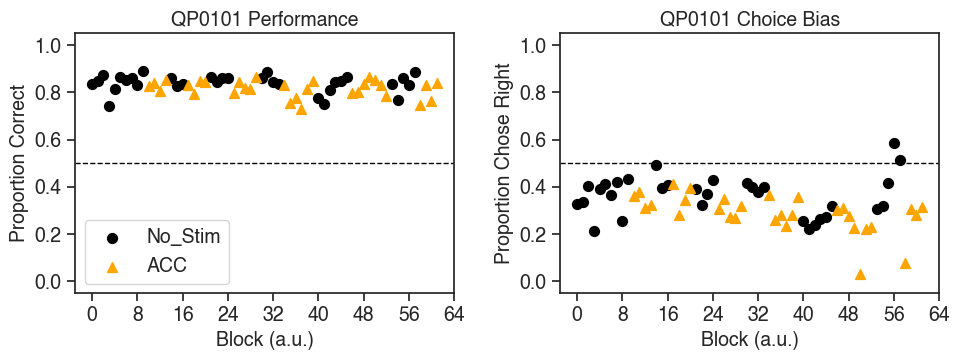

In [ ]:
# Calculate the proportion of correct responses per block for each participant (Performance)
grouped_df_perf = sub_df.groupby(['Participant_ID', 'block', 'Opto_Condition'])['correct'].agg(['mean', 'count']).reset_index()

# Calculate the proportion of correct responses per block for each participant (Choice)
grouped_df_choice = sub_df.groupby(['Participant_ID', 'block', 'Opto_Condition'])['choice'].agg(['mean', 'count']).reset_index()

# Marker dictionary for different opto conditions
marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}

# Plotting
participants = grouped_df_perf['Participant_ID'].unique()

for participant in participants:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Performance Plot
    participant_data_perf = grouped_df_perf[grouped_df_perf['Participant_ID'] == participant]
    for opto_condition, marker in marker_dict.items():
        condition_data = participant_data_perf[participant_data_perf['Opto_Condition'] == opto_condition]
        if not condition_data.empty:
            axes[0].scatter(condition_data.index, condition_data['mean'], label=opto_condition, 
                            marker=opto_condition_dict[opto_condition]['marker'], s=50, 
                            color=opto_condition_dict[opto_condition]['color'])
    axes[0].set_ylim(-0.05, 1.05)
    axes[0].axhline(0.5, color='black', linestyle='--', linewidth=1)
    # don't show decimals on the x-axis
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].set_title(f'{participant} Performance')
    axes[0].set_xlabel('Block (a.u.)')
    axes[0].set_ylabel('Proportion Correct')
    axes[0].legend()
    
    # Choice Plot
    participant_data_choice = grouped_df_choice[grouped_df_choice['Participant_ID'] == participant]
    for opto_condition, marker in marker_dict.items():
        condition_data = participant_data_choice[participant_data_choice['Opto_Condition'] == opto_condition]
        if not condition_data.empty:
            axes[1].scatter(condition_data.index, condition_data['mean'], label=opto_condition, 
                            marker=opto_condition_dict[opto_condition]['marker'], s=50, 
                            color=opto_condition_dict[opto_condition]['color'])
    axes[1].set_ylim(-0.05, 1.05)
    axes[1].axhline(0.5, color='black', linestyle='--', linewidth=1)
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].set_title(f'{participant} Choice Bias')
    axes[1].set_xlabel('Block (a.u.)')
    axes[1].set_ylabel('Proportion Chose Right')
    # axes[1].legend()
    
    plt.tight_layout()
    plt.show()

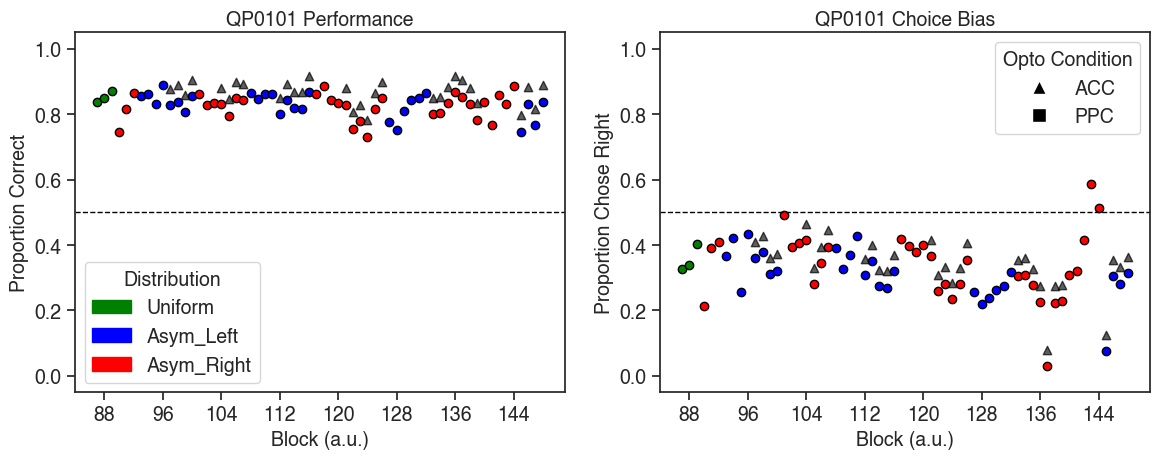

In [ ]:
# Calculate the proportion of correct responses per block for each participant (Performance)
grouped_df_perf = sub_df.groupby(['Participant_ID', 'block', 'Opto_Condition', 'Distribution'])['correct'].agg(['mean', 'count']).reset_index()

# Calculate the proportion of correct responses per block for each participant (Choice)
grouped_df_choice = sub_df.groupby(['Participant_ID', 'block', 'Opto_Condition', 'Distribution'])['choice'].agg(['mean', 'count']).reset_index()

# Marker dictionary for different opto conditions (used for markers above the points)
marker_dict = {
    'No_Stim': '',  # No marker for No_Stim
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}

# Assuming you have a predefined color map for distributions
# If not, you need to dynamically create one based on the unique values in the 'Distribution' column
distribution_colors = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}  # Example color map

participants = grouped_df_perf['Participant_ID'].unique()

for participant in participants:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for df, ax, title in zip([grouped_df_perf, grouped_df_choice], axes, ['Performance', 'Choice Bias']):
        participant_data = df[df['Participant_ID'] == participant]
        for _, row in participant_data.iterrows():
            color = distribution_colors[row['Distribution']]
            marker = marker_dict[row['Opto_Condition']]
            # Plot the main marker
            ax.scatter(row['block'], row['mean'], label=f"{row['Distribution']} {row['Opto_Condition']}", color=color, edgecolor='black')
            # Add opto condition marker if not No_Stim
            if marker:  
                ax.scatter(row['block'], row['mean']+0.05, marker=marker, color='k', edgecolor='black', alpha=0.7)
        
        ax.set_ylim(-0.05, 1.05)
        ax.axhline(0.5, color='black', linestyle='--', linewidth=1)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(f'{participant} {title}')
        ax.set_xlabel('Block (a.u.)')
        ax.set_ylabel('Proportion' + (' Correct' if title == 'Performance' else ' Chose Right'))

    # Custom legend for Distribution colors
    distribution_patches = [Patch(color=color, label=distribution) for distribution, color in distribution_colors.items()]
    legend1 = axes[0].legend(handles=distribution_patches, title="Distribution", loc='lower left')
                            #  , bbox_to_anchor=(1.1, 1))
    
    # Custom legend for Opto Condition markers
    opto_condition_markers = [Line2D([0], [0], marker=marker, color='w', label=condition, markerfacecolor='black', markersize=10) for condition, marker in marker_dict.items() if marker]
    legend2 = axes[1].legend(handles=opto_condition_markers, title="Opto Condition", loc='upper right')
                            #  bbox_to_anchor=(1.2, 1))
    
    plt.tight_layout()  # Adjust layout to make room for the legends outside
    # save the figure in the figures folder
    plt.savefig(FIGS_PATH + participant + '_performance_and_choice_bias.pdf', dpi=300, bbox_inches='tight')
    plt.show()

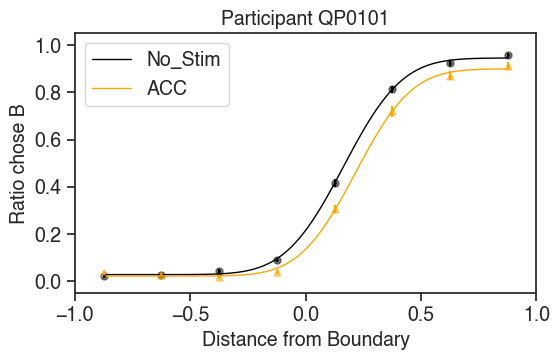

In [ ]:
# Generate psychometric curves for different Opto_Condition values for both participants
opto_conditions = ['No_Stim', 'ACC', 'PPC']
participants = sub_df['Participant_ID'].unique()

# Plot settings
colors = ['black', 'red', 'blue']  # Colors for No_Stim, ACC, PPC respectively

for participant in participants:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for opto_condition, color in zip(opto_conditions, colors):
        df_filtered = sub_df[(sub_df['Participant_ID'] == participant) & (sub_df['Opto_Condition'] == opto_condition)]
        if not df_filtered.empty:
            popt, _ = ut.psycho_fit(df_filtered)
            psycho_plot(df_filtered, popt, label=opto_condition, color=opto_condition_dict[opto_condition]['color'], 
                        marker=opto_condition_dict[opto_condition]['marker'], ax=ax, scatter=True, legend=True)

    ax.set_title(f'Participant {participant}')
    plt.tight_layout()

plt.show()

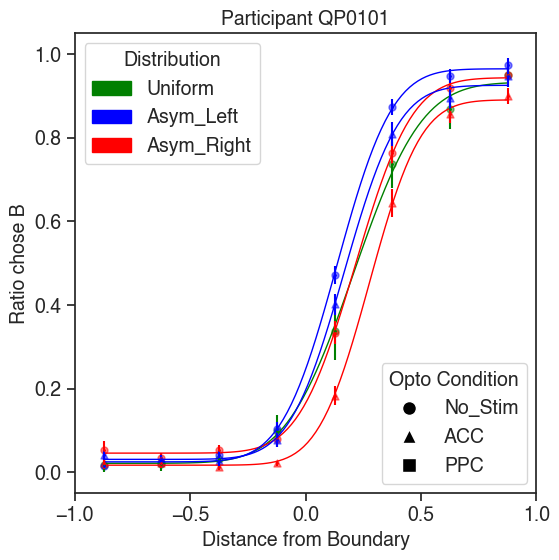

In [ ]:
opto_conditions = ['No_Stim', 'ACC', 'PPC']
participants = sub_df['Participant_ID'].unique()

# Assuming these are your predefined color and marker dictionaries
distribution_colors = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}  # Example color map
marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}

for participant in participants:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    distributions = sub_df['Distribution'].unique()
    
    for opto_condition, marker in marker_dict.items():
        for distribution in distributions:
            df_filtered = sub_df[(sub_df['Participant_ID'] == participant) & (sub_df['Opto_Condition'] == opto_condition) & (sub_df['Distribution'] == distribution)]
            if not df_filtered.empty:
                popt, _ = ut.psycho_fit(df_filtered)  # Fit the psychometric curve
                color = distribution_colors[distribution]  # Color based on distribution
                
                psycho_plot(df_filtered, popt, label=f"{opto_condition} {distribution}", color=color, 
                            marker=marker, ax=ax, scatter=True, legend=False)  # Temporarily disable legend

    ax.set_title(f'Participant {participant}')

    # Create custom legend for Distributions
    distribution_patches = [Patch(color=color, label=distribution) for distribution, color in distribution_colors.items()]
    legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='upper left')

    # Create custom legend for Opto Conditions
    opto_condition_markers = [Line2D([0], [0], marker=marker, color='w', label=condition, markerfacecolor='black', markersize=10) 
                              for condition, marker in marker_dict.items() if marker]  # Exclude No_Stim if no marker needed
    legend2 = ax.legend(handles=opto_condition_markers, title="Opto Condition", loc='lower right')

    plt.gca().add_artist(legend1)  # Add the first legend back in after adding the second
    plt.tight_layout()  # Adjust layout to make room for legends
    # save the figure in the figures folder
    plt.savefig(FIGS_PATH + participant + '_psychometric_by_opto_condition_and_distribution.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [30]:
# EXTRACT PSYCHOMETRIC PARAMETERS OVER BLOCKS
psych_params_df = ut.gen_blockwise_psych_params(sub_df, PARTICIPANTS)
# rename the "Block" column to "block" in the psych_params_df dataframe
psych_params_df = psych_params_df.rename(columns={'Block': 'block'})
# Identifying composite key columns
composite_keys = ['Participant_ID', 'block']  
# Dropping duplicate rows in data_df based on composite keys
data_df_unique = sub_df.drop_duplicates(subset=composite_keys)
# Columns from data_df to merge
columns_to_merge = ['Opto_On', 'Fiber', 'Mask', 'Zapit', 'Stimulation_Site', 'Opto_Condition']
# Merging
psych_params_df = psych_params_df.merge(data_df_unique[composite_keys + columns_to_merge], 
                                        on=composite_keys, how='left')

/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3

/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/quentin/anaconda3

Participant QP093 failed to plot: 'ALM'
Participant QP094 failed to plot: 'ALM'


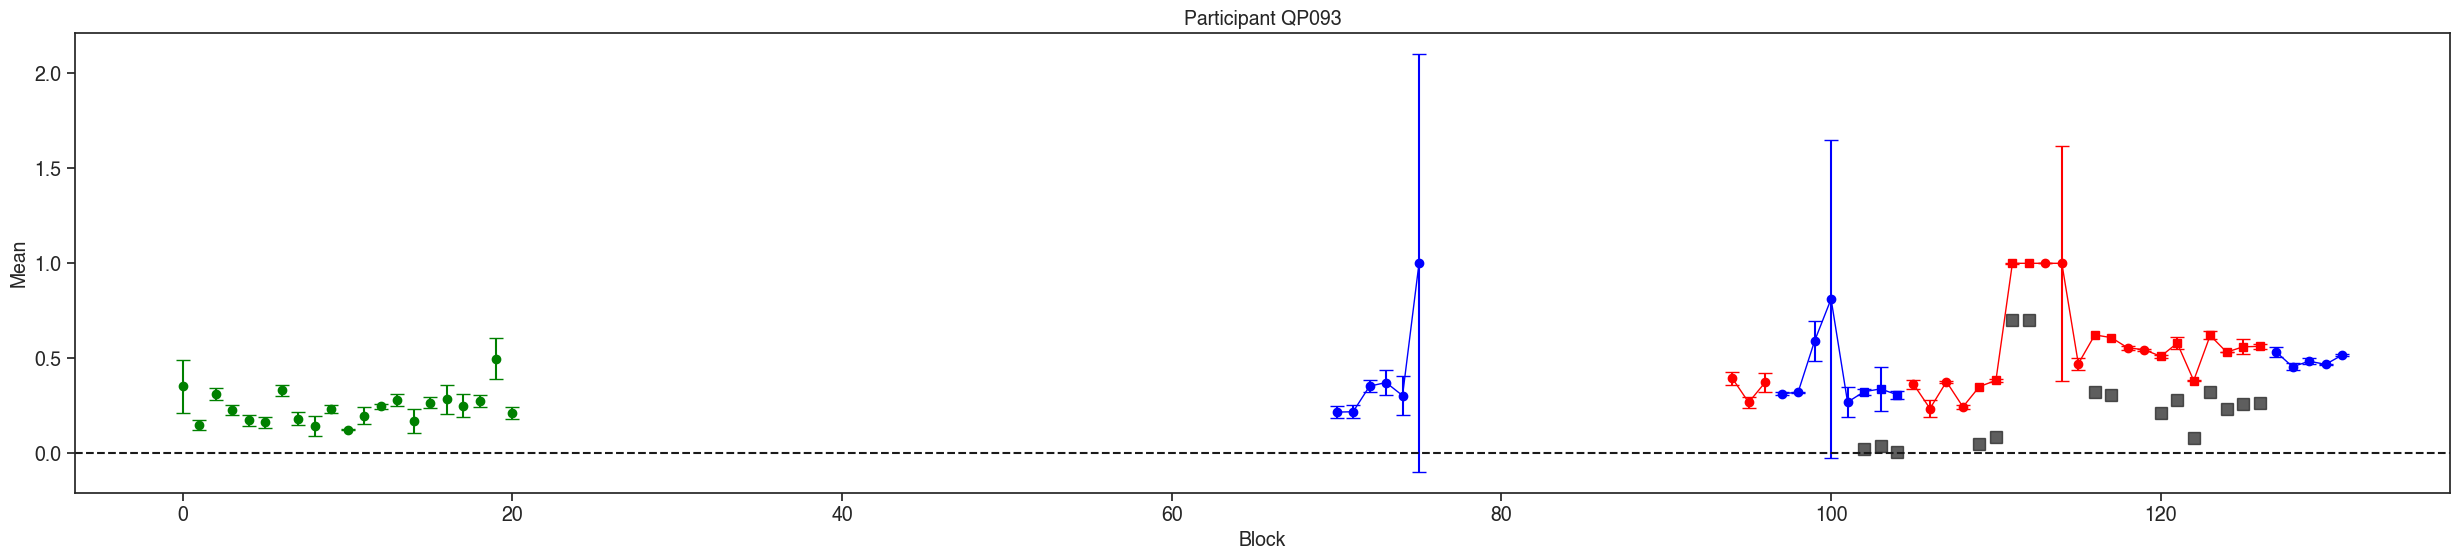

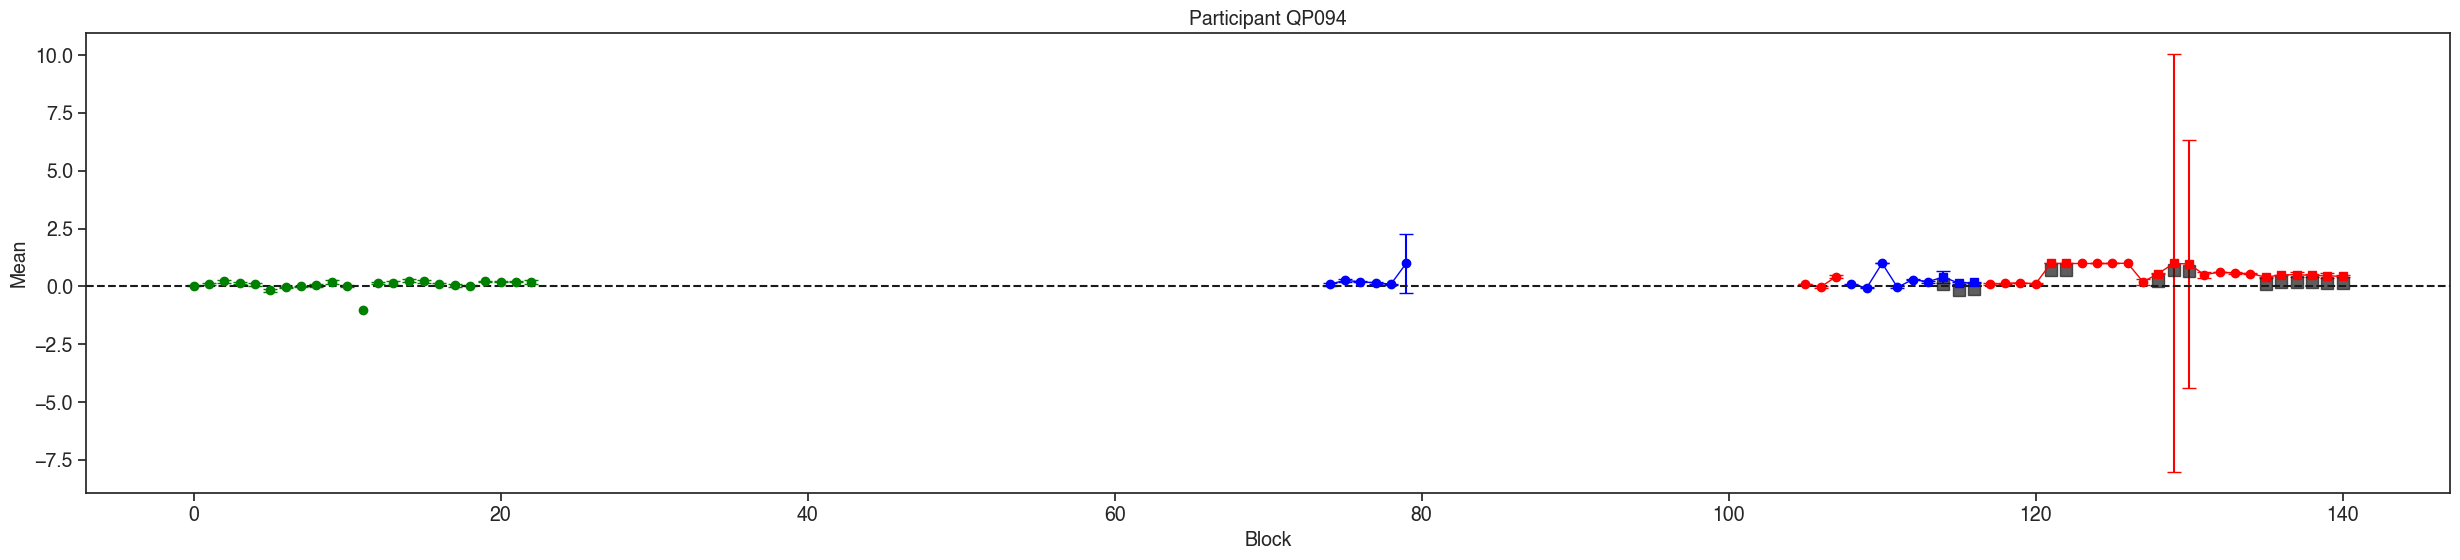

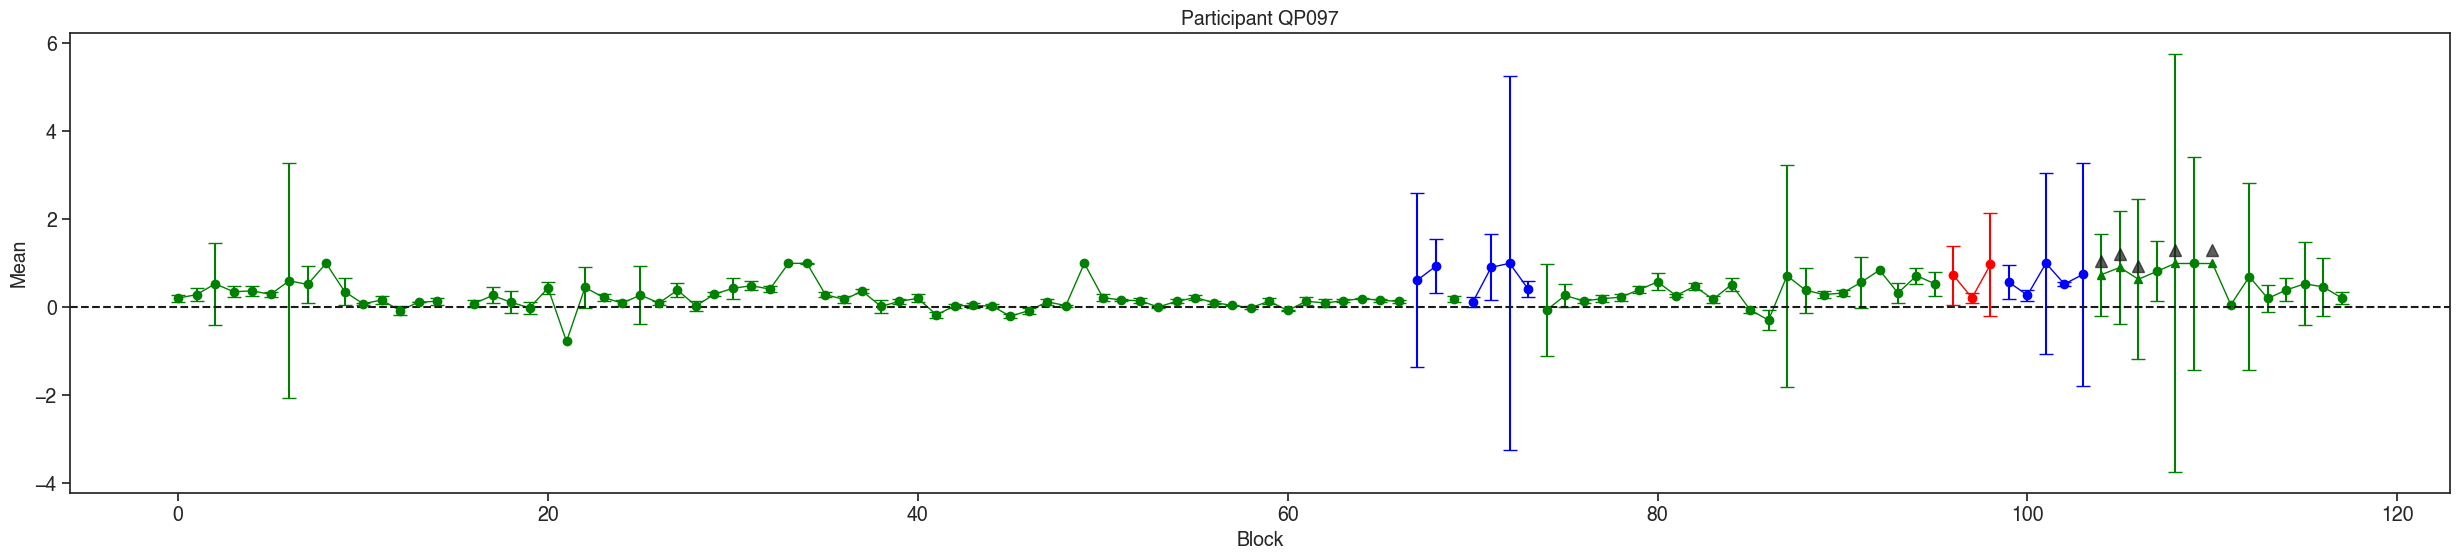

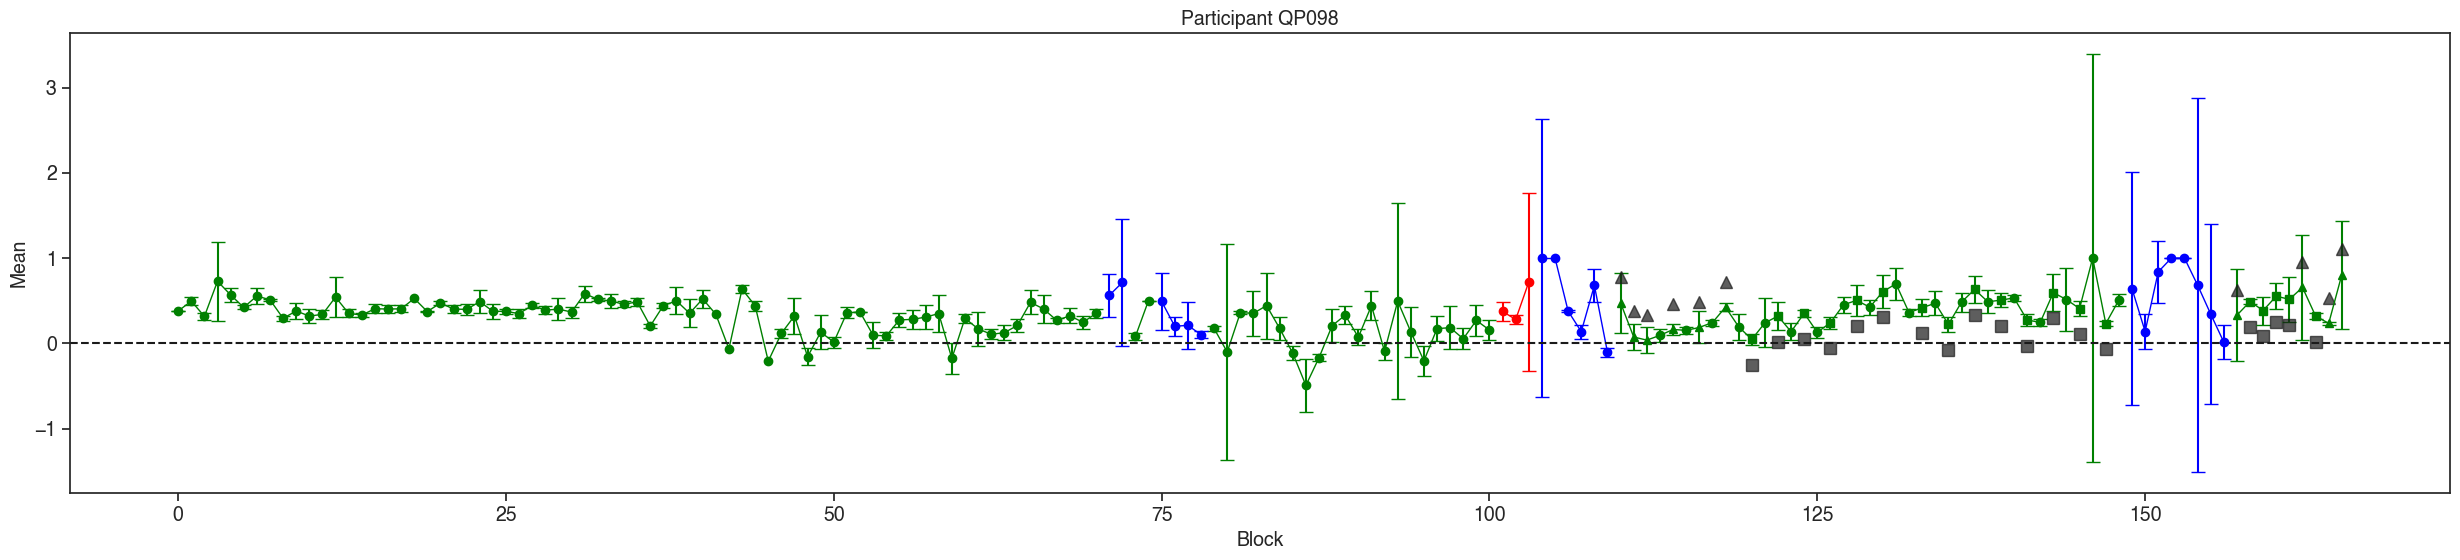

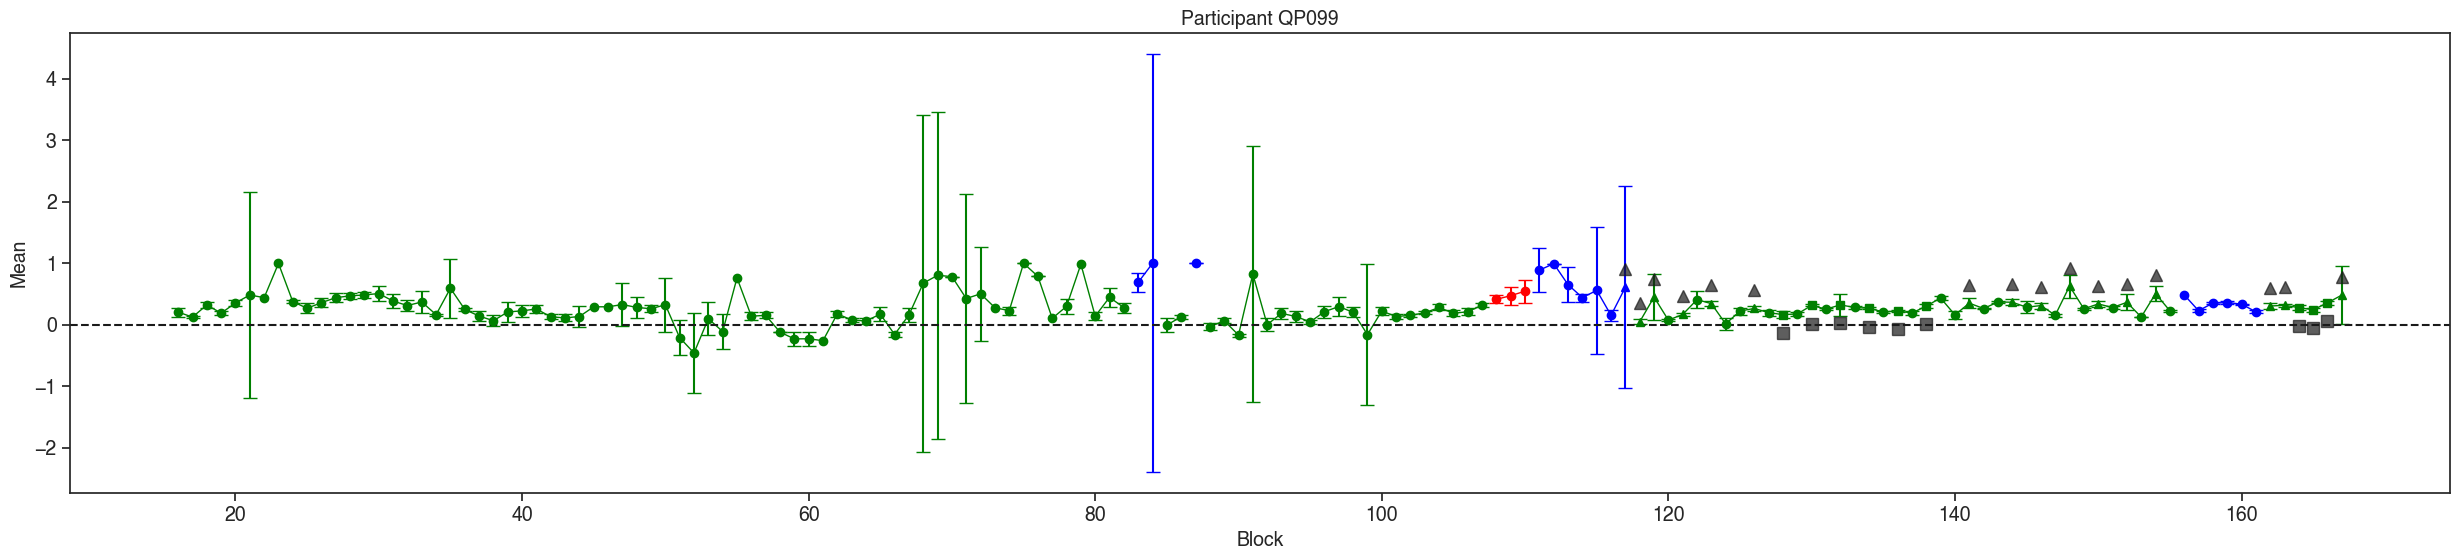

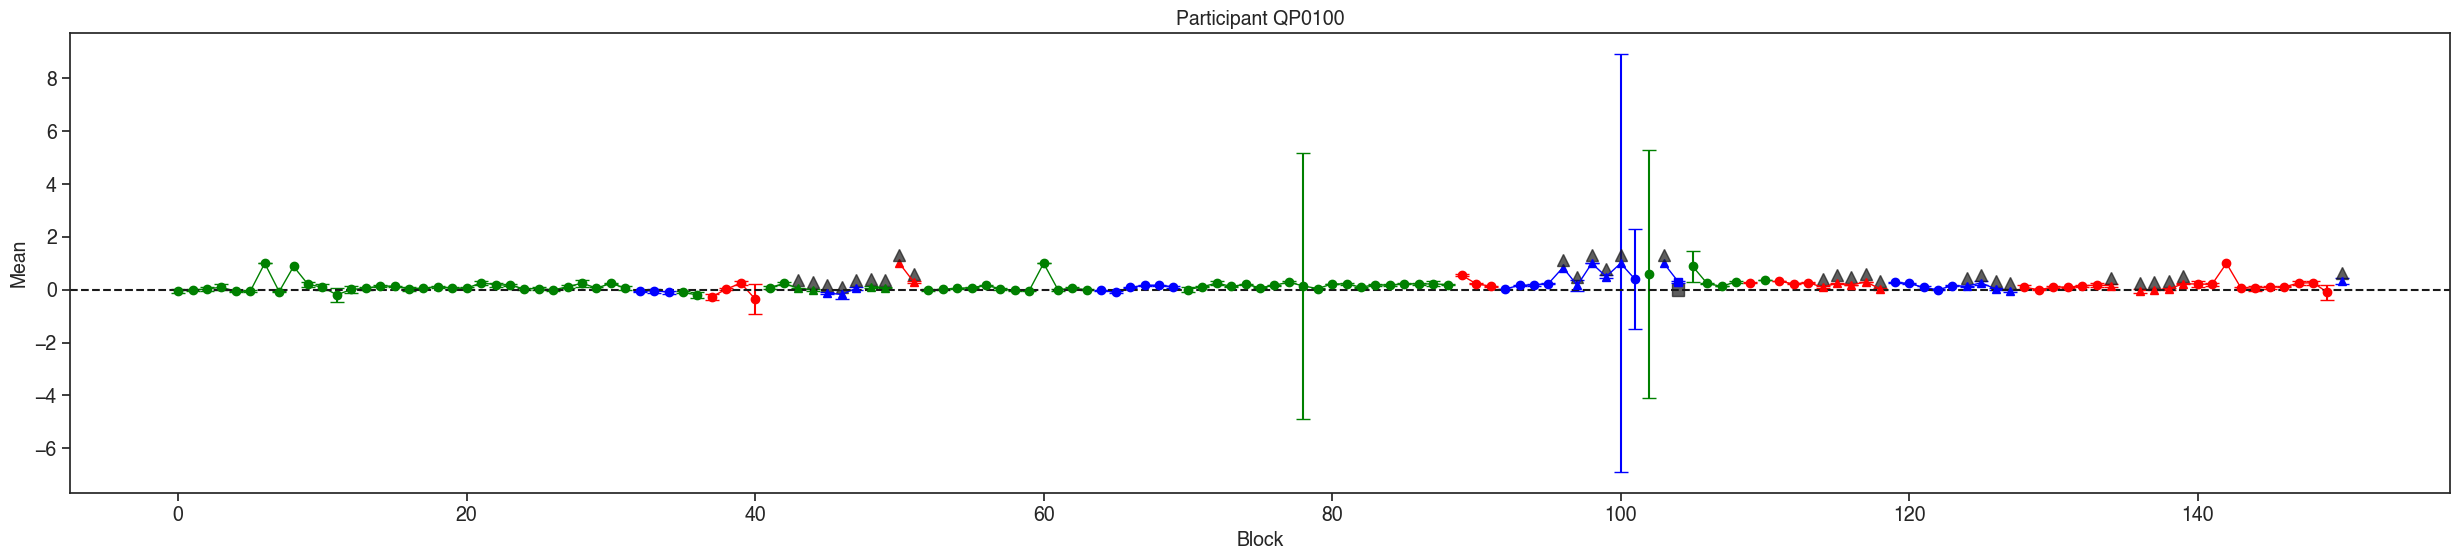

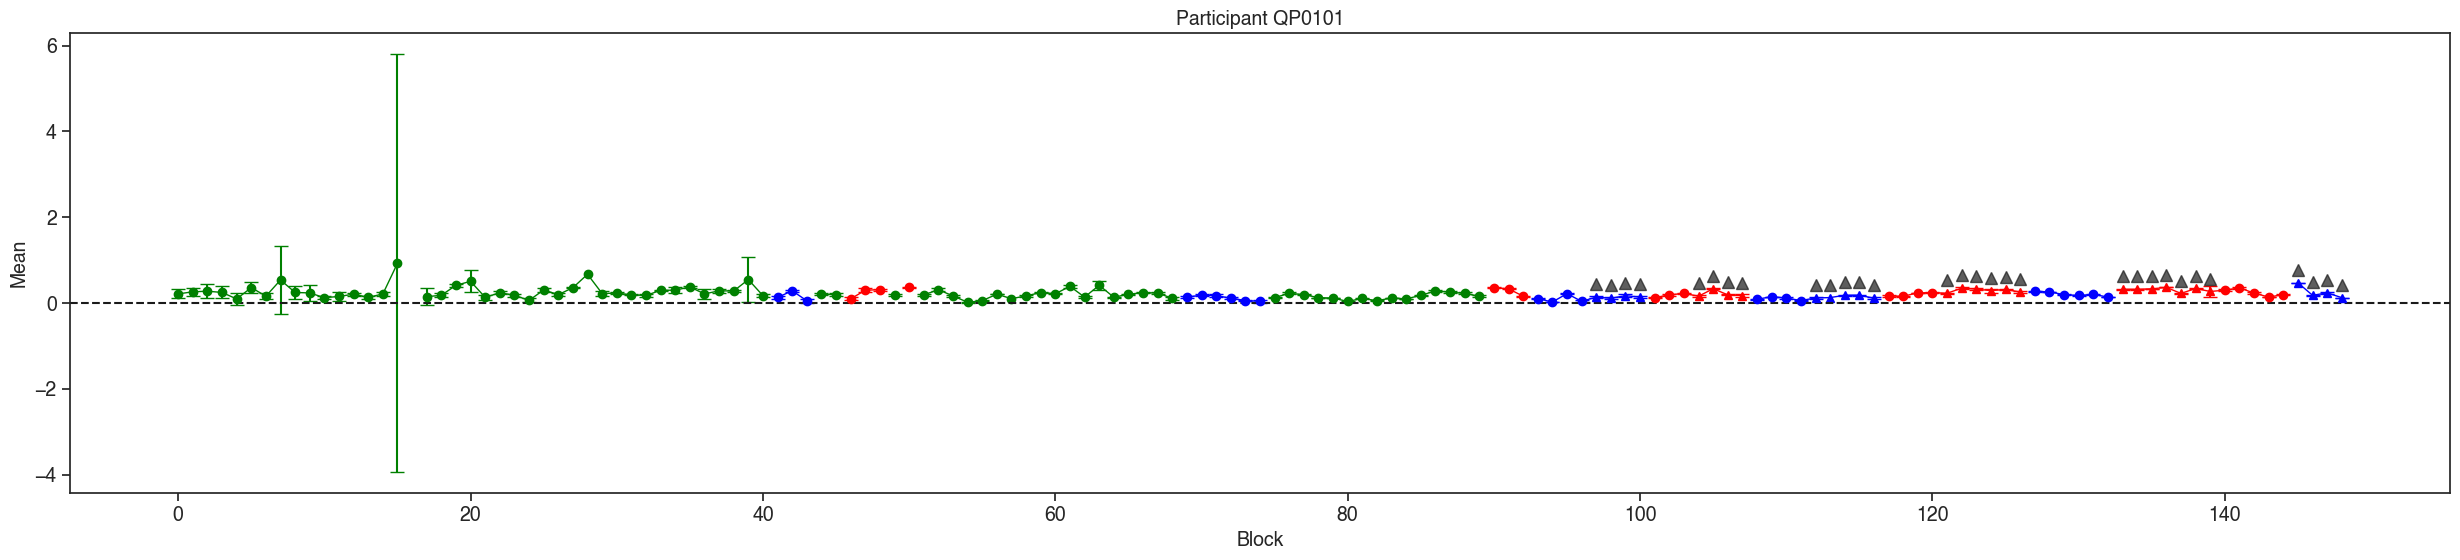

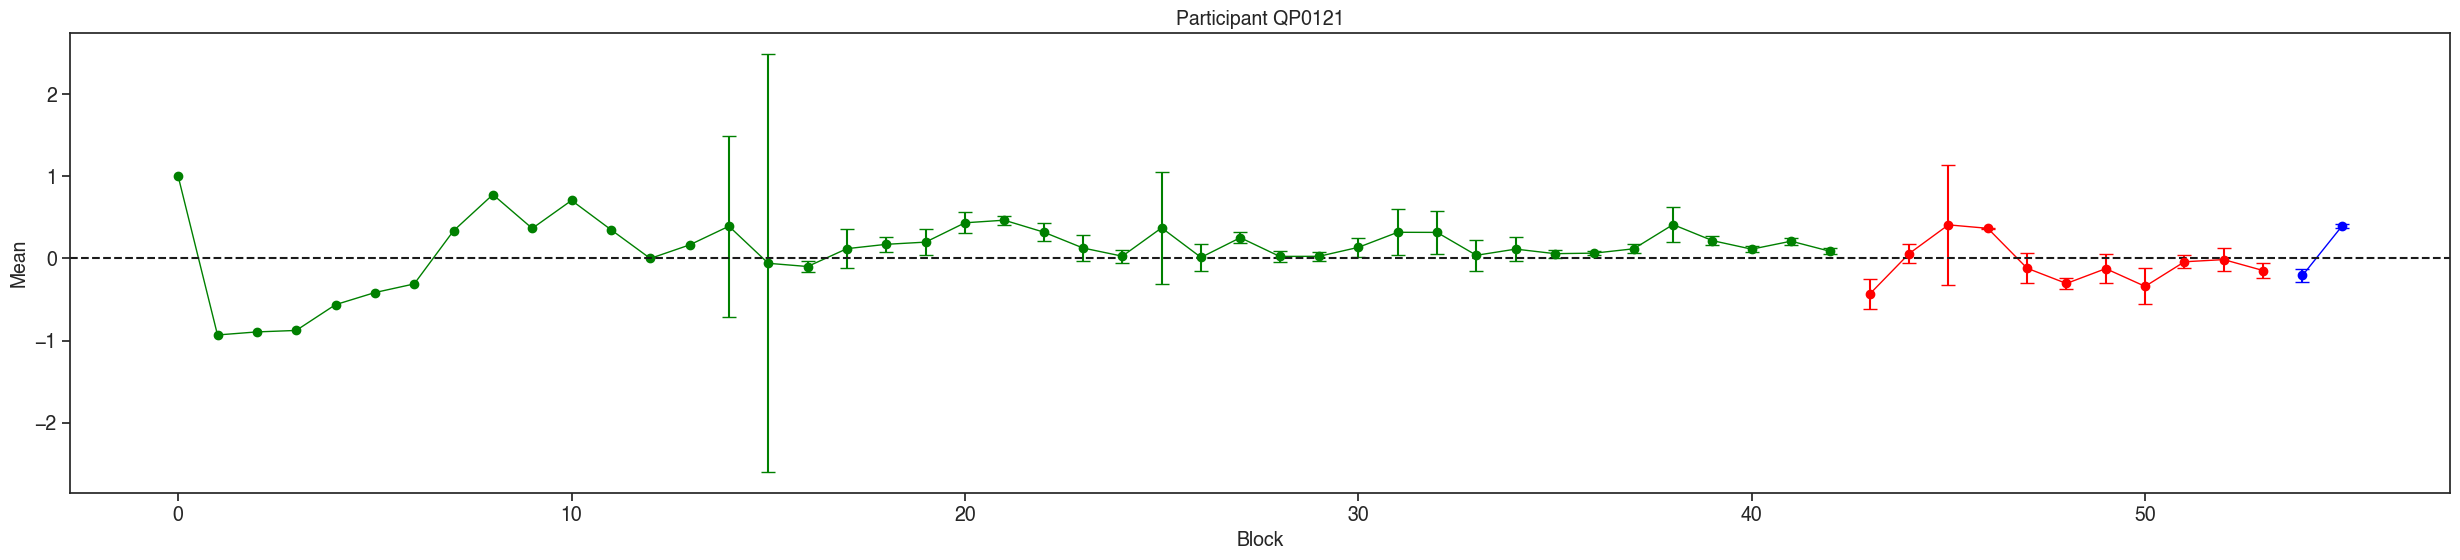

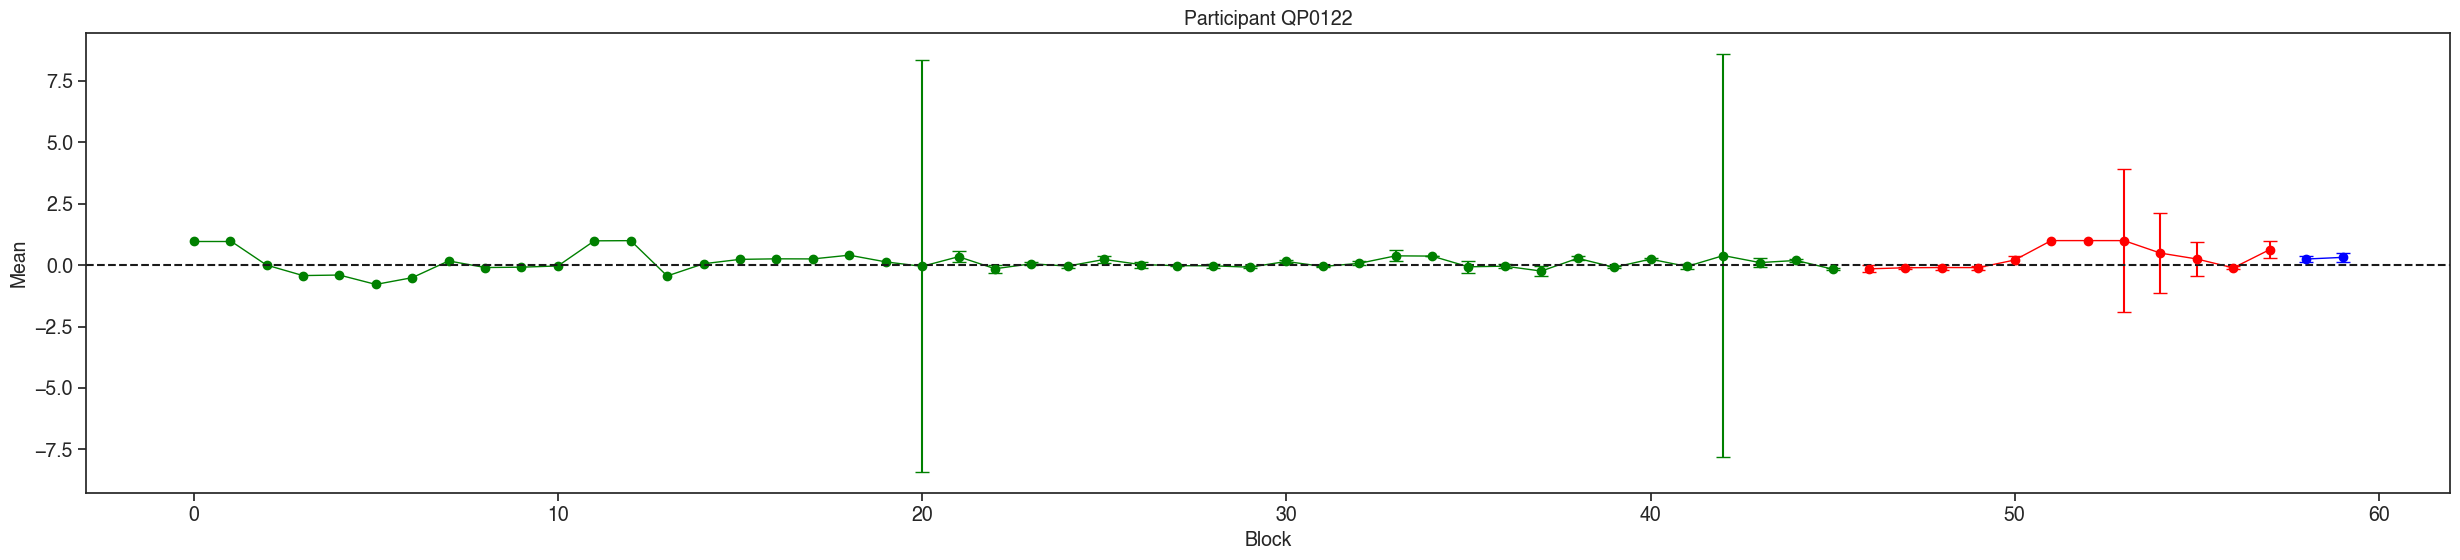

In [35]:
color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}
marker_dict = {'No_Stim': 'o', 'ACC': '^', 'PPC': 's'}  # Example marker dictionary for opto_conditions
error_threshold = 10 # for some reason, some points have enormous errors

for participant in PARTICIPANTS:
    fig, ax = plt.subplots(1, 1, figsize=(25, 6))
    pid_df = psych_params_df[psych_params_df['Participant_ID'] == participant]

    # only keep last n blocks
    # pid_df = pid_df[pid_df['block'] > pid_df['block'].max() - 40]

    # Track opto conditions encountered for legend
    opto_conditions_encountered = set()

    for dist in pid_df['Distribution'].unique():
        dist_df = pid_df[pid_df['Distribution'] == dist].sort_values(by='block').reset_index(drop=True)

        try:
            filtered_blocks = []  # Store blocks that pass the error threshold check
            filtered_means = []  # Store means that correspond to the filtered blocks

            for index, row in dist_df.iterrows():
                marker = marker_dict[row['Opto_Condition']]
                color = color_dict[dist]
                # Check if error is within threshold
                if row['Block_Means_Std'] <= error_threshold:
                    opto_conditions_encountered.add(row['Opto_Condition'])
                    ax.errorbar(x=row['block'], y=row['Block_Means'], yerr=row['Block_Means_Std'],
                                fmt=marker, ecolor=color, capsize=5, label=dist if marker == 'o' else "_nolegend_",
                                color=color)
                else:
                    # Plot without error bar for errors above threshold
                    ax.plot(row['block'], row['Block_Means'], marker, color=color, label=dist if marker == 'o' else "_nolegend_")
                # Additional plotting for specific conditions
                if row['Opto_Condition'] == 'ACC':
                    ax.plot(row['block'], row['Block_Means'] + 0.3, marker_dict['ACC'],
                            color='k', markersize=8, alpha=0.7)
                if row['Opto_Condition'] == 'PPC':
                    ax.plot(row['block'], row['Block_Means'] - 0.3, marker_dict['PPC'],
                            color='k', markersize=8, alpha=0.7)
                
                # Append to filtered lists regardless of error
                filtered_blocks.append(row['block'])
                filtered_means.append(row['Block_Means'])

            # Connect adjacent blocks
            for i in range(1, len(filtered_blocks)):
                if filtered_blocks[i] - filtered_blocks[i-1] == 1:  # Check for adjacency
                    ax.plot(filtered_blocks[i-1:i+1], filtered_means[i-1:i+1], color=color_dict[dist], linestyle='-', linewidth=1, label="_nolegend_")

        except Exception as e:
            print(f'Participant {participant} failed to plot: {e}')

    ax.set_title(f'Participant {participant}')
    ax.axhline(y=0, color='k', linestyle='--')
    # ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('Block')
    ax.set_ylabel('Mean')   
    # set x limits
    # ax.set_xlim(85, 152)

    # Creating custom legends
    # distribution_patches = [Patch(color=color, label=distribution) for distribution, color in color_dict.items()]
    # legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='lower left')
    
    # opto_condition_markers = [Line2D([0], [0], marker=marker_dict[condition], color='w', label=condition, markerfacecolor='black', markersize=10) 
    #                           for condition in opto_conditions_encountered]
    # legend2 = ax.legend(handles=opto_condition_markers, title="Opto Condition", loc='lower right')

    # plt.gca().add_artist(legend1)  # Add the distribution legend back after adding the opto condition legend
    plt.tight_layout()  # Adjust layout to make room for legends
    # save the figure in the figures folder
    # plt.savefig(FIGS_PATH + participant + '_psycho_mean_v_time_opto.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
cutoff_100 = 110
cutoff_101 = 90
# filter data baed on cutoffs
psych_params_df = psych_params_df[~((psych_params_df['Participant_ID'] == 'QP0100') & (psych_params_df['block'] < cutoff_100))]
psych_params_df = psych_params_df[~((psych_params_df['Participant_ID'] == 'QP0101') & (psych_params_df['block'] < cutoff_101))]
# remove ay Uniform data
psych_params_df = psych_params_df[psych_params_df['Distribution'] != 'Uniform']


In [ ]:
# break here
raise Exception('Break here')

Exception: Break here

In [ ]:
# Adjust the previous function to ensure the relative block numbers are assigned correctly
def assign_relative_blocks(sub_df):
    # Detect Opto_Condition change points
    change_points = sub_df['Opto_Condition'].ne(sub_df['Opto_Condition'].shift()).cumsum()
    # Determine the number of blocks since the last change
    sub_df['blocks_since_change'] = sub_df.groupby(change_points).cumcount()
    # Determine the number of blocks until the next change
    sub_df['blocks_until_change'] = sub_df.groupby(change_points).cumcount(ascending=False)
    # Calculate the relative block number (negative before the change, positive after)
    sub_df['Block_Rel_Opto'] = sub_df.apply(
        lambda x: -x['blocks_until_change'] if x['Opto_Condition'] == 'No_Stim' else x['blocks_since_change'], axis=1)
    # Drop the temporary columns
    sub_df.drop(['blocks_since_change', 'blocks_until_change'], axis=1, inplace=True)
    return sub_df

In [ ]:
psych_params_df = psych_params_df.groupby(['Participant_ID', 'Distribution'], group_keys=False).apply(assign_relative_blocks)
# for all rows where Opto_Condition is No_Stim, subtract 1 from Block_Rel_Opto (indexing issue)
psych_params_df.loc[psych_params_df['Opto_Condition'] == 'No_Stim', 'Block_Rel_Opto'] -= 1


In [ ]:
# remove rows where the Block_Rel_Opto is outside the range of -3 to 3
psych_params_df = psych_params_df[psych_params_df['Block_Rel_Opto'].between(-4, 2)]

StopIteration: 

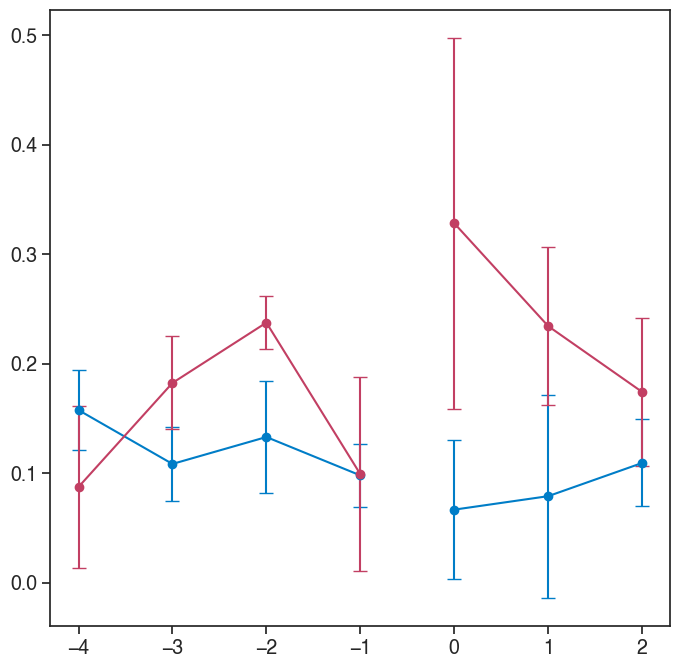

In [ ]:
# Continue with the previous steps to calculate the mean and SEM of 'Block_Means' for the aligned data
grouped_data = psych_params_df.groupby(['Distribution', 'Opto_Condition', 'Block_Rel_Opto'])
avg_data = grouped_data['Block_Means'].agg(['mean', 'sem']).reset_index()
avg_data.rename(columns={'mean': 'Avg_Block_Means', 'sem': 'SEM_Block_Means'}, inplace=True)

# Define color, marker, and linestyle dictionaries for plotting
color_dict = {'Uniform': '#2F9A76', 'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}
marker_dict = {'No_Stim': 'o', 'ACC': 'o', 'PPC': 's'}
linestyle_dict = {'No_Stim': '-', 'ACC': '-', 'PPC': '-.'}

# Plotting
plt.figure(figsize=(8, 8))

for (distribution, opto_condition), group_data in avg_data.groupby(['Distribution', 'Opto_Condition']):
    sorted_data = group_data.sort_values(by='Block_Rel_Opto')  # Ensure data is sorted for plotting
    
    plt.errorbar(
        sorted_data['Block_Rel_Opto'],
        sorted_data['Avg_Block_Means'],
        yerr=sorted_data['SEM_Block_Means'],  # Include SEM as error bars
        fmt=marker_dict[opto_condition],  # Marker style
        color=color_dict[distribution],
        linestyle=linestyle_dict[opto_condition],  # Line style
        label=f'{distribution}, {opto_condition}',
        capsize=5  # Cap size for error bars
    )
# plt.ylim(0, 0.35)
plt.yticks(np.arange(0, 0.4, 0.1))
plt.xlabel('Block Relative to Inactivation')
plt.ylabel('Mean')
# vertical dashed line at 0
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
# plt.title('Average Mu vs. Relative Block', fontsize=25)
# plt.legend(title="Distribution, Opto Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save the figure in the figures folder
plt.savefig(FIGS_PATH + 'psycho_mean_v_relative_opto_block.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
PARTICIPANT = 'QP0101'
BLOCK_CUTOFF = 90
# filter data based on cutoff
psych_params_df = psych_params_df[(psych_params_df['Participant_ID'] == PARTICIPANT) & (psych_params_df['block'] > BLOCK_CUTOFF)]
# remove data where Distribution is Asym_Left and Opto_Condition is ACC
psych_params_df = psych_params_df[~((psych_params_df['Distribution'] == 'Asym_Left') & (psych_params_df['Opto_Condition'] == 'ACC'))]

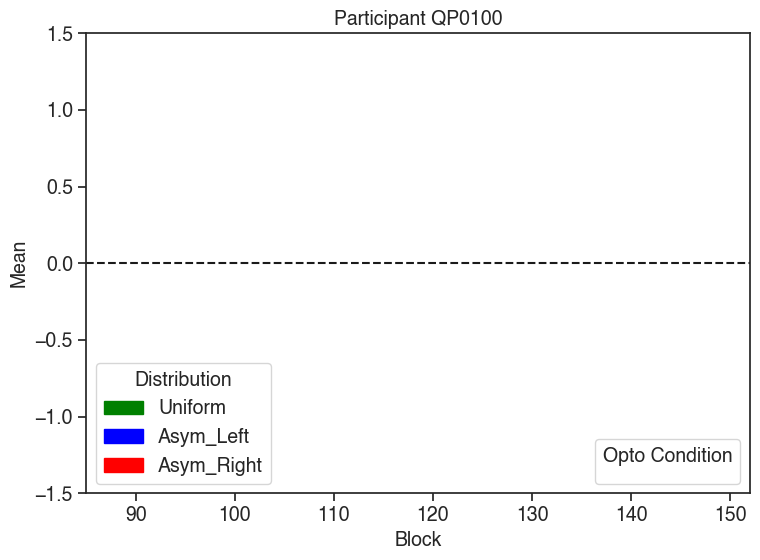

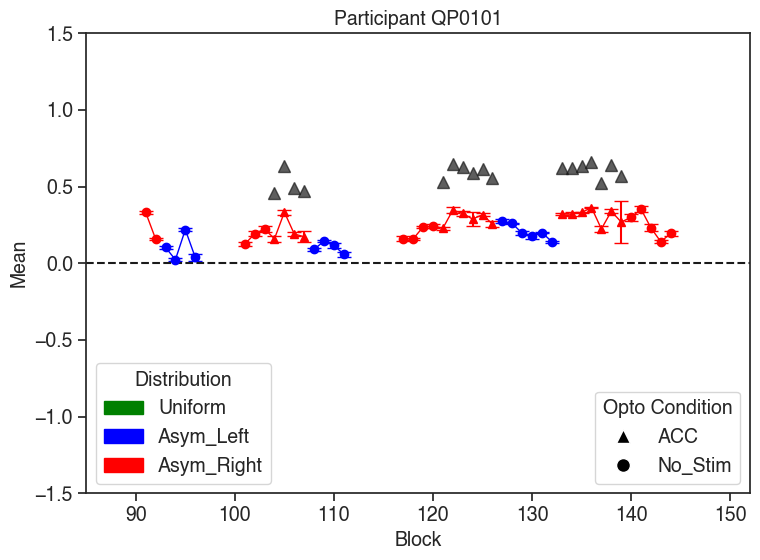

In [ ]:
color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}
marker_dict = {'No_Stim': 'o', 'ACC': '^', 'PPC': 's'}  # Example marker dictionary for opto_conditions
error_threshold = 10 # for some reason, some points have enormous errors

for participant in PARTICIPANTS:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    pid_df = psych_params_df[psych_params_df['Participant_ID'] == participant]

    # only keep last n blocks
    # pid_df = pid_df[pid_df['block'] > pid_df['block'].max() - 40]

    # Track opto conditions encountered for legend
    opto_conditions_encountered = set()

    for dist in pid_df['Distribution'].unique():
        dist_df = pid_df[pid_df['Distribution'] == dist].sort_values(by='block').reset_index(drop=True)

        try:
            filtered_blocks = []  # Store blocks that pass the error threshold check
            filtered_means = []  # Store means that correspond to the filtered blocks

            for index, row in dist_df.iterrows():
                marker = marker_dict[row['Opto_Condition']]
                color = color_dict[dist]
                # Check if error is within threshold
                if row['Block_Means_Std'] <= error_threshold:
                    opto_conditions_encountered.add(row['Opto_Condition'])
                    ax.errorbar(x=row['block'], y=row['Block_Means'], yerr=row['Block_Means_Std'],
                                fmt=marker, ecolor=color, capsize=5, label=dist if marker == 'o' else "_nolegend_",
                                color=color)
                else:
                    # Plot without error bar for errors above threshold
                    ax.plot(row['block'], row['Block_Means'], marker, color=color, label=dist if marker == 'o' else "_nolegend_")
                # Additional plotting for specific conditions
                if row['Opto_Condition'] == 'ACC':
                    ax.plot(row['block'], row['Block_Means'] + 0.3, marker_dict['ACC'],
                            color='k', markersize=8, alpha=0.7)
                if row['Opto_Condition'] == 'PPC':
                    ax.plot(row['block'], row['Block_Means'] - 0.3, marker_dict['PPC'],
                            color='k', markersize=8, alpha=0.7)
                
                # Append to filtered lists regardless of error
                filtered_blocks.append(row['block'])
                filtered_means.append(row['Block_Means'])

            # Connect adjacent blocks
            for i in range(1, len(filtered_blocks)):
                if filtered_blocks[i] - filtered_blocks[i-1] == 1:  # Check for adjacency
                    ax.plot(filtered_blocks[i-1:i+1], filtered_means[i-1:i+1], color=color_dict[dist], linestyle='-', linewidth=1, label="_nolegend_")

        except Exception as e:
            print(f'Participant {participant} failed to plot: {e}')

    ax.set_title(f'Participant {participant}')
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('Block')
    ax.set_ylabel('Mean')   
    # set x limits
    ax.set_xlim(85, 152)

    # Creating custom legends
    distribution_patches = [Patch(color=color, label=distribution) for distribution, color in color_dict.items()]
    legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='lower left')
    
    opto_condition_markers = [Line2D([0], [0], marker=marker_dict[condition], color='w', label=condition, markerfacecolor='black', markersize=10) 
                              for condition in opto_conditions_encountered]
    legend2 = ax.legend(handles=opto_condition_markers, title="Opto Condition", loc='lower right')

    plt.gca().add_artist(legend1)  # Add the distribution legend back after adding the opto condition legend
    plt.tight_layout()  # Adjust layout to make room for legends
    # save the figure in the figures folder
    # plt.savefig(FIGS_PATH + participant + '_psycho_mean_v_time_opto.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Adjust the previous function to ensure the relative block numbers are assigned correctly
def assign_relative_blocks(sub_df):
    # Detect Opto_Condition change points
    change_points = sub_df['Distribution'].ne(sub_df['Distribution'].shift()).cumsum()
    # Determine the number of blocks since the last change
    sub_df['blocks_since_change'] = sub_df.groupby(change_points).cumcount()
    # Determine the number of blocks until the next change
    sub_df['blocks_until_change'] = sub_df.groupby(change_points).cumcount(ascending=False)
    # Calculate the relative block number (negative before the change, positive after)
    sub_df['Block_Rel_Dist'] = sub_df.apply(
        lambda x: -x['blocks_until_change'] if x['Distribution'] == 'Asym_Left' else x['blocks_since_change'], axis=1)
    # Drop the temporary columns
    sub_df.drop(['blocks_since_change', 'blocks_until_change'], axis=1, inplace=True)
    return sub_df
psych_params_df = psych_params_df.groupby(['Participant_ID'], group_keys=False).apply(assign_relative_blocks)
# for all rows where Opto_Condition is No_Stim, subtract 1 from Block_Rel_Opto (indexing issue)
# psych_params_df.loc[sub_df['Distribution'] == 'Asym_Left', 'Block_Rel_Dist'] -= 1

In [ ]:
psych_params_df['Block_Rel_Dist'] = psych_params_df.apply(lambda row: row['Block_Rel_Dist'] - 1 if row['Distribution'] == 'Asym_Left' else row['Block_Rel_Dist'], axis=1)


In [ ]:
# remove rows where the Block_Rel_Opto is outside the range of -3 to 3
psych_params_df = psych_params_df[psych_params_df['Block_Rel_Dist'].between(-4, 2)]

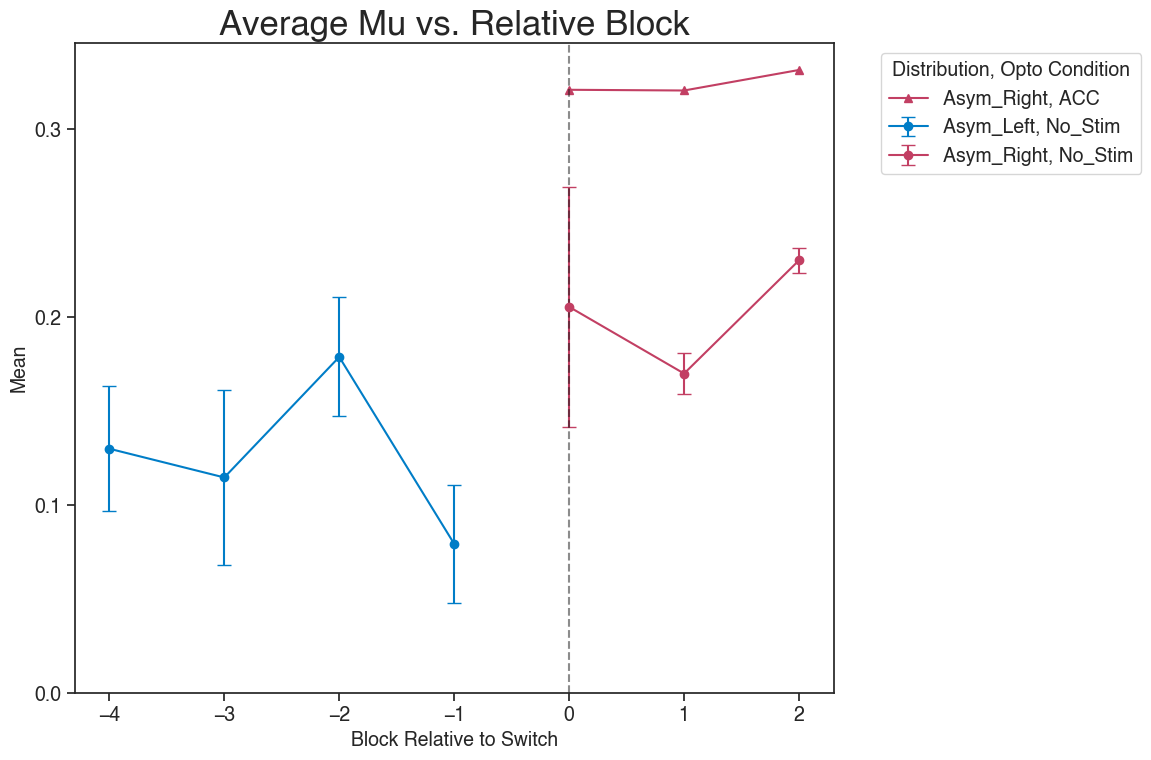

In [ ]:
# Continue with the previous steps to calculate the mean and SEM of 'Block_Means' for the aligned data
grouped_data = psych_params_df.groupby(['Distribution', 'Block_Rel_Dist', 'Opto_Condition'])    
avg_data = grouped_data['Block_Means'].agg(['mean', 'sem']).reset_index()
avg_data.rename(columns={'mean': 'Avg_Block_Means', 'sem': 'SEM_Block_Means'}, inplace=True)

# Define color, marker, and linestyle dictionaries for plotting
color_dict = {'Uniform': '#2F9A76', 'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}
marker_dict = {'No_Stim': 'o', 'ACC': '^', 'PPC': 's'}
linestyle_dict = {'No_Stim': '-', 'ACC': '-', 'PPC': '-.'}

# Plotting
plt.figure(figsize=(12, 8))

for (distribution, opto_condition), group_data in avg_data.groupby(['Distribution', 'Opto_Condition']):
    sorted_data = group_data.sort_values(by='Block_Rel_Dist')  # Ensure data is sorted for plotting
    
    try:
        plt.errorbar(
            sorted_data['Block_Rel_Dist'],
            sorted_data['Avg_Block_Means'],
            yerr=sorted_data['SEM_Block_Means'],  # Include SEM as error bars
            fmt=marker_dict[opto_condition],  # Marker style
            color=color_dict[distribution],
            linestyle=linestyle_dict[opto_condition],  # Line style
            label=f'{distribution}, {opto_condition}',
            capsize=5  # Cap size for error bars
        )
    except:
        # try plotting without error bars
        plt.plot(
            sorted_data['Block_Rel_Dist'],
            sorted_data['Avg_Block_Means'],
            marker_dict[opto_condition],  # Marker style
            color=color_dict[distribution],
            linestyle=linestyle_dict[opto_condition],  # Line style
            label=f'{distribution}, {opto_condition}'
        )




# plt.ylim(0, 0.35)
plt.yticks(np.arange(0, 0.4, 0.1))
plt.xlabel('Block Relative to Switch')
plt.ylabel('Mean')
# vertical dashed line at 0
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title('Average Mu vs. Relative Block', fontsize=25)
plt.legend(title="Distribution, Opto Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save the figure in the figures folder
plt.savefig(FIGS_PATH + 'psycho_mean_v_dist_switch_opto.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# avg_data

In [ ]:
sample_df = psych_params_df[['Participant_ID', 'Distribution', 'Opto_Condition', 'Block_Rel_Dist', 'Block_Means', 'Block_Means_Std']].copy()
# Create a mask indicating where 'Distribution' changes
mask = sample_df['Distribution'].ne(sample_df['Distribution'].shift())

# Increment the block count at the positions where 'Distribution' changes
sample_df['Dist_Block'] = mask.cumsum()

# Define a function to get the first Opto_Condition of the next Dist_Block
def get_next_opto_condition(row, df):
    # Filter for the next Dist_Block for the same Participant_ID
    next_rows = df[(df['Participant_ID'] == row['Participant_ID']) & (df['Dist_Block'] == row['Dist_Block'] + 1)]
    if not next_rows.empty:
        # Return the Opto_Condition of the first row of the next Dist_Block
        return next_rows.iloc[0]['Opto_Condition']
    else:
        # Return NaN if there is no next Dist_Block
        return pd.NA

# Apply the function to the sample DataFrame
sample_df['Next_Opto_Condition'] = sample_df.apply(lambda row: get_next_opto_condition(row, sample_df), axis=1)


In [ ]:
sample_df.reset_index(drop=True, inplace=True)

In [ ]:
# Continue with the previous steps to calculate the mean and SEM of 'Block_Means' for the aligned data
grouped_data = sample_df.groupby(['Block_Rel_Dist', 
                                  'Opto_Condition', 
                                #   'Next_Opto_Condition'
                                'Distribution'
                                  ])  
avg_data = grouped_data['Block_Means'].agg(['mean', 'sem']).reset_index()
avg_data.rename(columns={'mean': 'Avg_Block_Means', 'sem': 'SEM_Block_Means'}, inplace=True)

,Block_Rel_Dist,Opto_Condition,Distribution,Avg_Block_Means,SEM_Block_Means
0,-4,No_Stim,Asym_Left,0.130079,0.033231
1,-3,No_Stim,Asym_Left,0.114788,0.046523
2,-2,No_Stim,Asym_Left,0.178901,0.031632
3,-1,No_Stim,Asym_Left,0.079459,0.031257
4,0,ACC,Asym_Right,0.321023,NaN
5,0,No_Stim,Asym_Right,0.205545,0.063889
6,1,ACC,Asym_Right,0.320642,NaN
7,1,No_Stim,Asym_Right,0.170065,0.010950
8,2,ACC,Asym_Right,0.331565,NaN
9,2,No_Stim,Asym_Right,0.230319,0.006609


In [ ]:
# pre switch
grouped_data = sample_df.groupby(['Block_Rel_Dist', 
                                  'Next_Opto_Condition',
                                  'Distribution'
                                  ])  
avg_data_pre = grouped_data['Block_Means'].agg(['mean', 'sem']).reset_index()
avg_data_pre.rename(columns={'mean': 'Avg_Block_Means', 'sem': 'SEM_Block_Means'}, inplace=True)
# keep only rows between block -4 and -1
avg_data_pre = avg_data_pre[avg_data_pre['Block_Rel_Dist'].between(-4, -1)]

# pre switch
grouped_data = sample_df.groupby(['Block_Rel_Dist', 
                                  'Opto_Condition',
                                  'Distribution'
                                  ])  
avg_data_post = grouped_data['Block_Means'].agg(['mean', 'sem']).reset_index()
avg_data_post.rename(columns={'mean': 'Avg_Block_Means', 'sem': 'SEM_Block_Means'}, inplace=True)
# keep only rows between block -4 and -1
avg_data_post = avg_data_post[avg_data_post['Block_Rel_Dist'].between(0, 2)]

avg_data = pd.concat([avg_data_pre, avg_data_post]).reset_index(drop=True)

,Block_Rel_Dist,Next_Opto_Condition,Distribution,Avg_Block_Means,SEM_Block_Means,Opto_Condition
0,-4,ACC,Asym_Left,0.196086,NaN,NaN
1,-4,No_Stim,Asym_Left,0.097076,0.006723,NaN
2,-3,ACC,Asym_Left,0.175677,NaN,NaN
3,-3,No_Stim,Asym_Left,0.084344,0.060931,NaN
4,-2,ACC,Asym_Left,0.200396,NaN,NaN
5,-2,No_Stim,Asym_Left,0.168154,0.051529,NaN
6,-1,ACC,Asym_Left,0.140962,NaN,NaN
7,-1,No_Stim,Asym_Left,0.048707,0.009697,NaN
8,0,NaN,Asym_Right,0.321023,NaN,ACC
9,0,NaN,Asym_Right,0.205545,0.063889,No_Stim


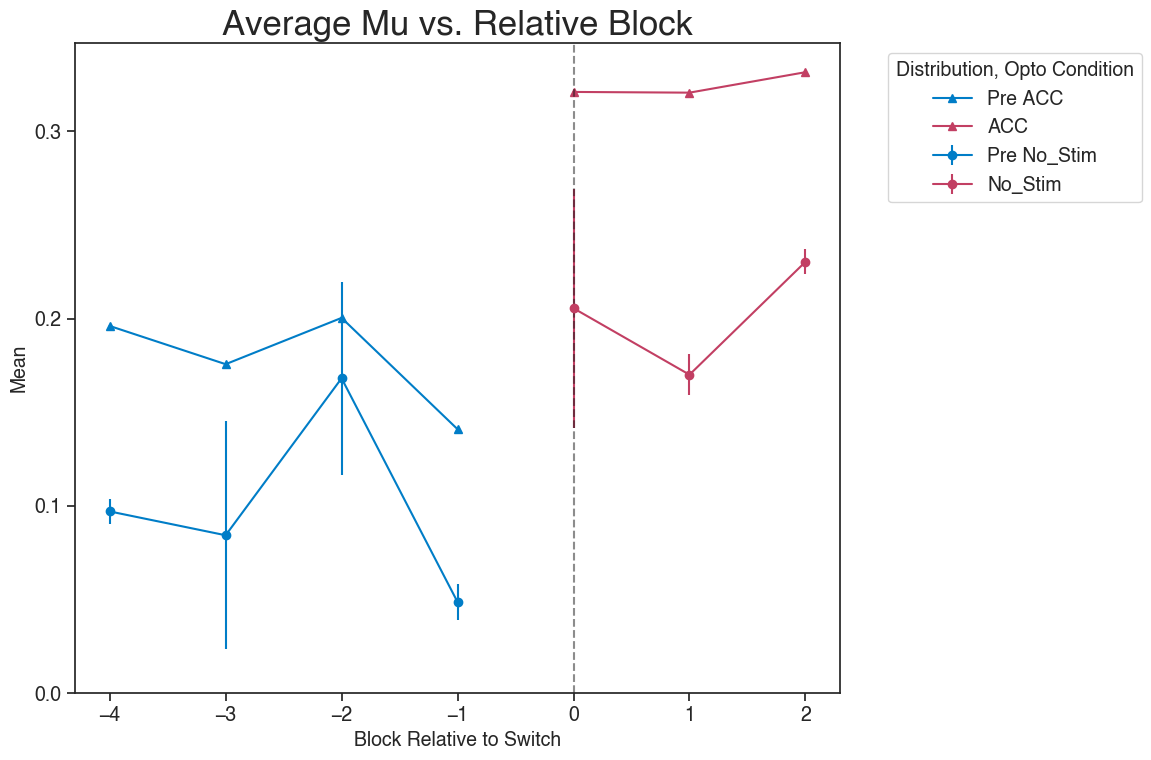

In [ ]:
# Adjusted plotting to handle empty datasets correctly
fig, ax = plt.subplots(figsize=(12, 8))
color_dict = {'Uniform': '#2F9A76', 'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}

# Plotting for pre switch (-4 to -1) using Next_Opto_Condition
for condition in avg_data_pre['Next_Opto_Condition'].unique():
    df_plot = avg_data_pre[avg_data_pre['Next_Opto_Condition'] == condition]
    if not df_plot.empty:
        try:
            ax.errorbar(df_plot['Block_Rel_Dist'], df_plot['Avg_Block_Means'], yerr=df_plot['SEM_Block_Means'],
                        fmt=marker_dict.get(condition, 'o'), linestyle=linestyle_dict.get(condition, '-'), color=color_dict[df_plot.Distribution.unique()[0]],
                        label=f'Pre {condition}')
        except:
            # try again w/o error bars
            ax.plot(df_plot['Block_Rel_Dist'], df_plot['Avg_Block_Means'],
                    marker_dict.get(condition, 'o'), linestyle=linestyle_dict.get(condition, '-'), color=color_dict[df_plot.Distribution.unique()[0]],
                    label=f'Pre {condition}')

# Plotting for post switch (0 to 3) using Opto_Condition
for condition in avg_data_post['Opto_Condition'].unique():
    df_plot = avg_data_post[avg_data_post['Opto_Condition'] == condition]
    if not df_plot.empty:
        try:
            ax.errorbar(df_plot['Block_Rel_Dist'], df_plot['Avg_Block_Means'], yerr=df_plot['SEM_Block_Means'],
                        fmt=marker_dict.get(condition, 'o'), linestyle=linestyle_dict.get(condition, '-'), color=color_dict[df_plot.Distribution.unique()[0]],
                        label=f'{condition}')
        except:
            # try again w/o error bars
            ax.plot(df_plot['Block_Rel_Dist'], df_plot['Avg_Block_Means'],
                    marker_dict.get(condition, 'o'), linestyle=linestyle_dict.get(condition, '-'), color=color_dict[df_plot.Distribution.unique()[0]],
                    label=f'{condition}')

plt.yticks(np.arange(0, 0.4, 0.1))
plt.xlabel('Block Relative to Switch')
plt.ylabel('Mean')
# vertical dashed line at 0
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title('Average Mu vs. Relative Block', fontsize=25)
plt.legend(title="Distribution, Opto Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save the figure in the figures folder
plt.savefig(FIGS_PATH + 'psycho_mean_v_dist_switch_opto.pdf', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
PARTICIPANT = 'QP0101'
BLOCK_CUTOFF = 80
# filter data based on cutoff
psych_params_df = psych_params_df[(psych_params_df['Participant_ID'] == PARTICIPANT) & (psych_params_df['block'] > BLOCK_CUTOFF)]
# remove data where Distribution is Asym_Left and Opto_Condition is ACC
psych_params_df = psych_params_df[~((psych_params_df['Distribution'] == 'Asym_Right') & (psych_params_df['Opto_Condition'] == 'ACC'))]

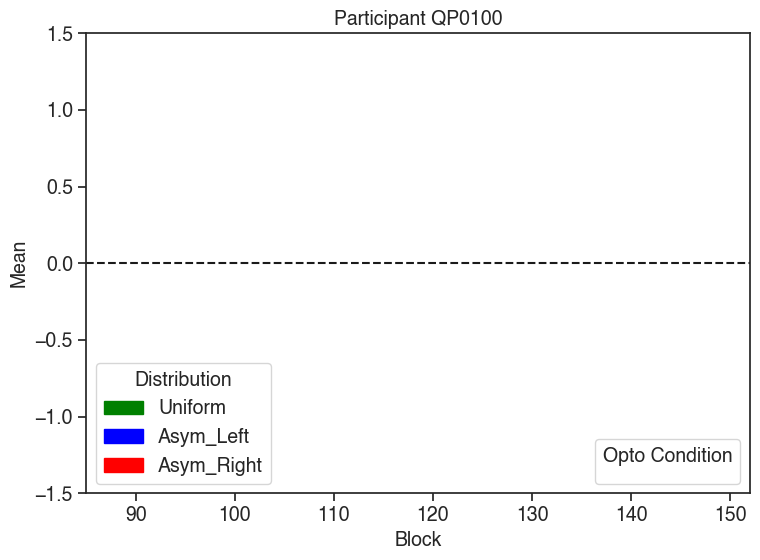

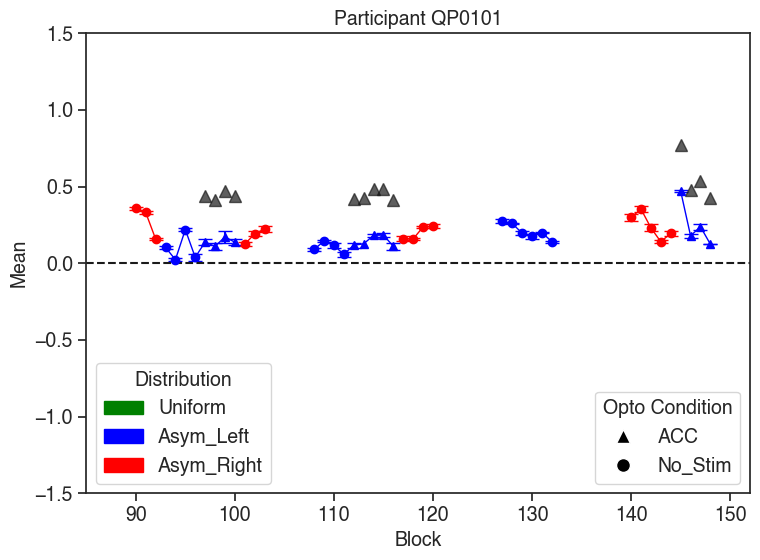

In [ ]:
color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}
marker_dict = {'No_Stim': 'o', 'ACC': '^', 'PPC': 's'}  # Example marker dictionary for opto_conditions
error_threshold = 10 # for some reason, some points have enormous errors

for participant in PARTICIPANTS:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    pid_df = psych_params_df[psych_params_df['Participant_ID'] == participant]

    # only keep last n blocks
    # pid_df = pid_df[pid_df['block'] > pid_df['block'].max() - 40]

    # Track opto conditions encountered for legend
    opto_conditions_encountered = set()

    for dist in pid_df['Distribution'].unique():
        dist_df = pid_df[pid_df['Distribution'] == dist].sort_values(by='block').reset_index(drop=True)

        try:
            filtered_blocks = []  # Store blocks that pass the error threshold check
            filtered_means = []  # Store means that correspond to the filtered blocks

            for index, row in dist_df.iterrows():
                marker = marker_dict[row['Opto_Condition']]
                color = color_dict[dist]
                # Check if error is within threshold
                if row['Block_Means_Std'] <= error_threshold:
                    opto_conditions_encountered.add(row['Opto_Condition'])
                    ax.errorbar(x=row['block'], y=row['Block_Means'], yerr=row['Block_Means_Std'],
                                fmt=marker, ecolor=color, capsize=5, label=dist if marker == 'o' else "_nolegend_",
                                color=color)
                else:
                    # Plot without error bar for errors above threshold
                    ax.plot(row['block'], row['Block_Means'], marker, color=color, label=dist if marker == 'o' else "_nolegend_")
                # Additional plotting for specific conditions
                if row['Opto_Condition'] == 'ACC':
                    ax.plot(row['block'], row['Block_Means'] + 0.3, marker_dict['ACC'],
                            color='k', markersize=8, alpha=0.7)
                if row['Opto_Condition'] == 'PPC':
                    ax.plot(row['block'], row['Block_Means'] - 0.3, marker_dict['PPC'],
                            color='k', markersize=8, alpha=0.7)
                
                # Append to filtered lists regardless of error
                filtered_blocks.append(row['block'])
                filtered_means.append(row['Block_Means'])

            # Connect adjacent blocks
            for i in range(1, len(filtered_blocks)):
                if filtered_blocks[i] - filtered_blocks[i-1] == 1:  # Check for adjacency
                    ax.plot(filtered_blocks[i-1:i+1], filtered_means[i-1:i+1], color=color_dict[dist], linestyle='-', linewidth=1, label="_nolegend_")

        except Exception as e:
            print(f'Participant {participant} failed to plot: {e}')

    ax.set_title(f'Participant {participant}')
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('Block')
    ax.set_ylabel('Mean')   
    # set x limits
    ax.set_xlim(85, 152)

    # Creating custom legends
    distribution_patches = [Patch(color=color, label=distribution) for distribution, color in color_dict.items()]
    legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='lower left')
    
    opto_condition_markers = [Line2D([0], [0], marker=marker_dict[condition], color='w', label=condition, markerfacecolor='black', markersize=10) 
                              for condition in opto_conditions_encountered]
    legend2 = ax.legend(handles=opto_condition_markers, title="Opto Condition", loc='lower right')

    plt.gca().add_artist(legend1)  # Add the distribution legend back after adding the opto condition legend
    plt.tight_layout()  # Adjust layout to make room for legends
    # save the figure in the figures folder
    # plt.savefig(FIGS_PATH + participant + '_psycho_mean_v_time_opto.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
def assign_relative_blocks(sub_df):
    # Detect Opto_Condition change points
    change_points = sub_df['Distribution'].ne(sub_df['Distribution'].shift()).cumsum()
    # Determine the number of blocks since the last change
    sub_df['blocks_since_change'] = sub_df.groupby(change_points).cumcount()
    # Determine the number of blocks until the next change
    sub_df['blocks_until_change'] = sub_df.groupby(change_points).cumcount(ascending=False)
    # Calculate the relative block number (negative before the change, positive after)
    sub_df['Block_Rel_Dist'] = sub_df.apply(
        lambda x: -x['blocks_until_change'] if x['Distribution'] == 'Asym_Right' else x['blocks_since_change'], axis=1)
    # Drop the temporary columns
    sub_df.drop(['blocks_since_change', 'blocks_until_change'], axis=1, inplace=True)
    return sub_df

In [ ]:
psych_params_df = psych_params_df.groupby(['Participant_ID'], group_keys=False).apply(assign_relative_blocks)
psych_params_df['Block_Rel_Dist'] = psych_params_df.apply(lambda row: row['Block_Rel_Dist'] - 1 if row['Distribution'] == 'Asym_Right' else row['Block_Rel_Dist'], axis=1)

In [ ]:
# remove rows where the Block_Rel_Opto is outside the range of -3 to 3
psych_params_df = psych_params_df[psych_params_df['Block_Rel_Dist'].between(-3, 3)]

In [ ]:
psych_params_df

,Participant_ID,block,Distribution,Block_Means,Block_Slopes,Block_Lapses_1,Block_Lapses_2,Block_Means_Std,Block_Slopes_Std,Block_Lapses_1_Std,Block_Lapses_2_Std,Opto_On,Fiber,Mask,Zapit,Stimulation_Site,Opto_Condition,Block_Rel_Dist
3,QP0101,90.0,Asym_Right,0.357618,0.196768,0.001954,2.950953e-01,0.009651,0.013295,0.006213,0.012266,False,False,False,False,NaN,No_Stim,-3
4,QP0101,91.0,Asym_Right,0.331698,0.226256,0.017912,4.149104e-02,0.009584,0.012751,0.007575,0.015223,False,False,False,False,NaN,No_Stim,-2
5,QP0101,92.0,Asym_Right,0.159016,0.217236,0.004022,5.747747e-02,0.008979,0.012185,0.008764,0.011747,False,False,False,False,NaN,No_Stim,-1
6,QP0101,93.0,Asym_Left,0.103799,0.179967,0.014665,5.387716e-02,0.009940,0.014416,0.011280,0.013214,False,False,False,False,NaN,No_Stim,0
7,QP0101,94.0,Asym_Left,0.023413,0.217941,0.024361,4.294442e-02,0.010727,0.014337,0.011698,0.012181,False,False,False,False,NaN,No_Stim,1
8,QP0101,95.0,Asym_Left,0.219683,0.213639,0.013516,1.828667e-02,0.009879,0.013117,0.009457,0.014216,False,False,False,False,NaN,No_Stim,2
9,QP0101,96.0,Asym_Left,0.039010,0.132275,0.024983,5.482108e-02,0.022026,0.024744,0.027843,0.028312,False,False,False,False,NaN,No_Stim,3
14,QP0101,101.0,Asym_Right,0.124870,0.229634,0.020411,3.138900e-02,0.011612,0.015749,0.011493,0.014564,False,False,False,False,ACC,No_Stim,-3
15,QP0101,102.0,Asym_Right,0.191965,0.213921,0.032211,7.971339e-02,0.016431,0.022052,0.014812,0.021099,False,False,False,False,ACC,No_Stim,-2
16,QP0101,103.0,Asym_Right,0.223709,0.195363,0.055717,9.109134e-03,0.018721,0.024404,0.018089,0.026713,False,False,False,False,ACC,No_Stim,-1


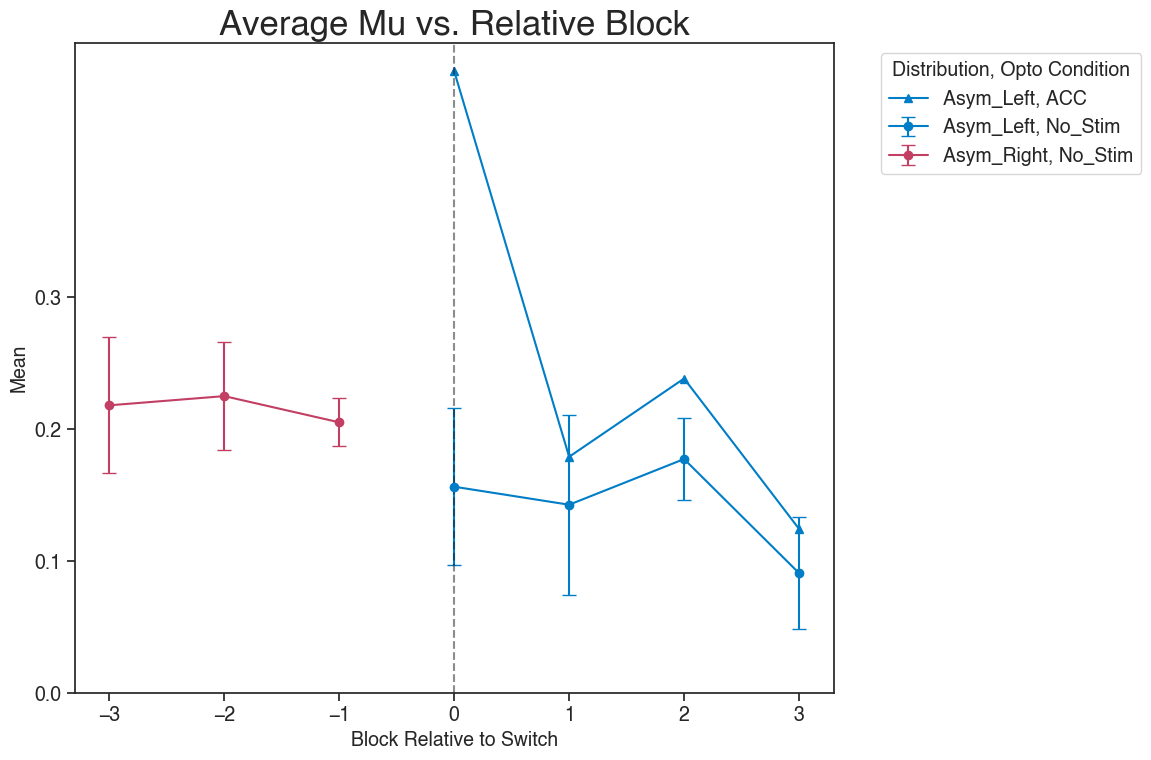

In [ ]:
# Continue with the previous steps to calculate the mean and SEM of 'Block_Means' for the aligned data
grouped_data = psych_params_df.groupby(['Distribution', 'Block_Rel_Dist', 'Opto_Condition'])    
avg_data = grouped_data['Block_Means'].agg(['mean', 'sem']).reset_index()
avg_data.rename(columns={'mean': 'Avg_Block_Means', 'sem': 'SEM_Block_Means'}, inplace=True)

# Define color, marker, and linestyle dictionaries for plotting
color_dict = {'Uniform': '#2F9A76', 'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}
marker_dict = {'No_Stim': 'o', 'ACC': '^', 'PPC': 's'}
linestyle_dict = {'No_Stim': '-', 'ACC': '-', 'PPC': '-.'}

# Plotting
plt.figure(figsize=(12, 8))

for (distribution, opto_condition), group_data in avg_data.groupby(['Distribution', 'Opto_Condition']):
    sorted_data = group_data.sort_values(by='Block_Rel_Dist')  # Ensure data is sorted for plotting
    
    try:
        plt.errorbar(
            sorted_data['Block_Rel_Dist'],
            sorted_data['Avg_Block_Means'],
            yerr=sorted_data['SEM_Block_Means'],  # Include SEM as error bars
            fmt=marker_dict[opto_condition],  # Marker style
            color=color_dict[distribution],
            linestyle=linestyle_dict[opto_condition],  # Line style
            label=f'{distribution}, {opto_condition}',
            capsize=5  # Cap size for error bars
        )
    except:
        # try plotting without error bars
        plt.plot(
            sorted_data['Block_Rel_Dist'],
            sorted_data['Avg_Block_Means'],
            marker_dict[opto_condition],  # Marker style
            color=color_dict[distribution],
            linestyle=linestyle_dict[opto_condition],  # Line style
            label=f'{distribution}, {opto_condition}'
        )




# plt.ylim(0, 0.35)
plt.yticks(np.arange(0, 0.4, 0.1))
plt.xlabel('Block Relative to Switch')
plt.ylabel('Mean')
# vertical dashed line at 0
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title('Average Mu vs. Relative Block', fontsize=25)
plt.legend(title="Distribution, Opto Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save the figure in the figures folder
# plt.savefig(FIGS_PATH + 'psycho_mean_v_dist_switch_opto.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
sample_df = psych_params_df[['Participant_ID', 'Distribution', 'Opto_Condition', 'Block_Rel_Dist', 'Block_Means', 'Block_Means_Std']].copy()
# Create a mask indicating where 'Distribution' changes
mask = sample_df['Distribution'].ne(sample_df['Distribution'].shift())

# Increment the block count at the positions where 'Distribution' changes
sample_df['Dist_Block'] = mask.cumsum()

# Define a function to get the first Opto_Condition of the next Dist_Block
def get_next_opto_condition(row, df):
    # Filter for the next Dist_Block for the same Participant_ID
    next_rows = df[(df['Participant_ID'] == row['Participant_ID']) & (df['Dist_Block'] == row['Dist_Block'] + 1)]
    if not next_rows.empty:
        # Return the Opto_Condition of the first row of the next Dist_Block
        return next_rows.iloc[0]['Opto_Condition']
    else:
        # Return NaN if there is no next Dist_Block
        return pd.NA

# Apply the function to the sample DataFrame
sample_df['Next_Opto_Condition'] = sample_df.apply(lambda row: get_next_opto_condition(row, sample_df), axis=1)

In [ ]:
sample_df.reset_index(drop=True, inplace=True)
# Continue with the previous steps to calculate the mean and SEM of 'Block_Means' for the aligned data
grouped_data = sample_df.groupby(['Block_Rel_Dist', 
                                  'Opto_Condition', 
                                #   'Next_Opto_Condition'
                                'Distribution'
                                  ])  
avg_data = grouped_data['Block_Means'].agg(['mean', 'sem']).reset_index()
avg_data.rename(columns={'mean': 'Avg_Block_Means', 'sem': 'SEM_Block_Means'}, inplace=True)
# pre switch
grouped_data = sample_df.groupby(['Block_Rel_Dist', 
                                  'Next_Opto_Condition',
                                  'Distribution'
                                  ])  
avg_data_pre = grouped_data['Block_Means'].agg(['mean', 'sem']).reset_index()
avg_data_pre.rename(columns={'mean': 'Avg_Block_Means', 'sem': 'SEM_Block_Means'}, inplace=True)
# keep only rows between block -4 and -1
avg_data_pre = avg_data_pre[avg_data_pre['Block_Rel_Dist'].between(-4, -1)]

# pre switch
grouped_data = sample_df.groupby(['Block_Rel_Dist', 
                                  'Opto_Condition',
                                  'Distribution'
                                  ])  
avg_data_post = grouped_data['Block_Means'].agg(['mean', 'sem']).reset_index()
avg_data_post.rename(columns={'mean': 'Avg_Block_Means', 'sem': 'SEM_Block_Means'}, inplace=True)
# keep only rows between block -4 and -1
avg_data_post = avg_data_post[avg_data_post['Block_Rel_Dist'].between(0, 3)]

avg_data = pd.concat([avg_data_pre, avg_data_post]).reset_index(drop=True)

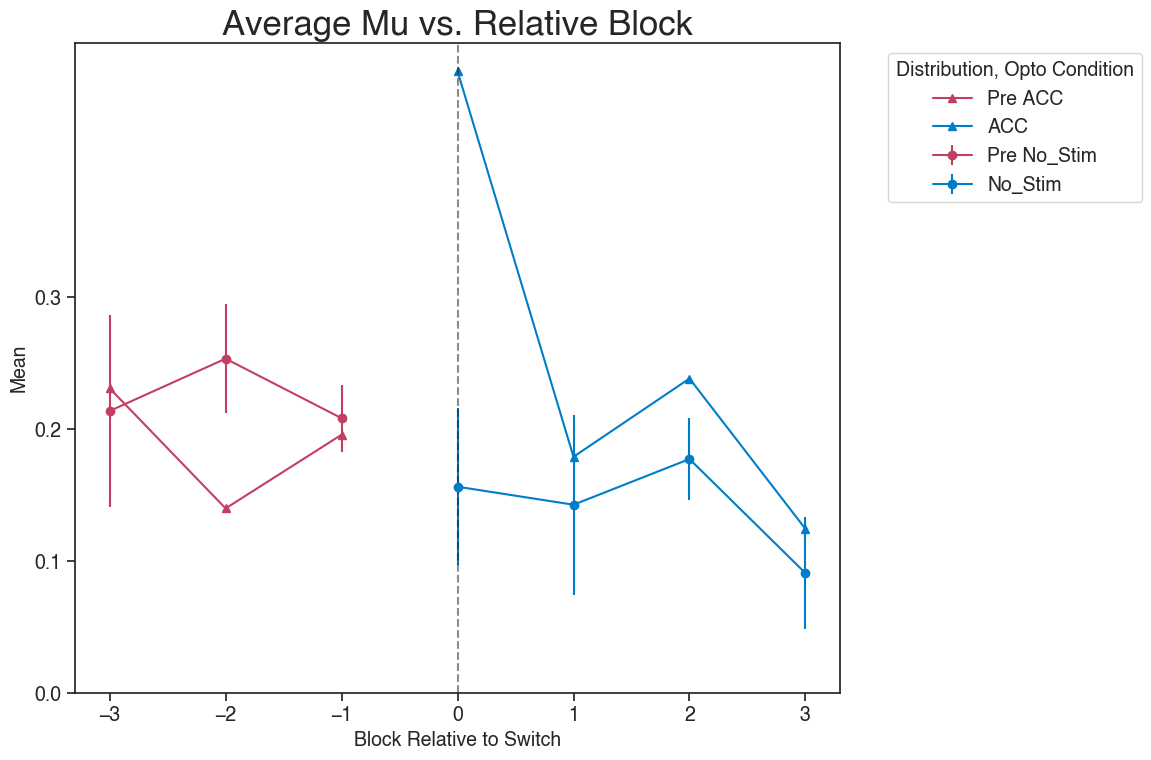

In [ ]:
# Adjusted plotting to handle empty datasets correctly
fig, ax = plt.subplots(figsize=(12, 8))
color_dict = {'Uniform': '#2F9A76', 'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}

# Plotting for pre switch (-4 to -1) using Next_Opto_Condition
for condition in avg_data_pre['Next_Opto_Condition'].unique():
    df_plot = avg_data_pre[avg_data_pre['Next_Opto_Condition'] == condition]
    if not df_plot.empty:
        try:
            ax.errorbar(df_plot['Block_Rel_Dist'], df_plot['Avg_Block_Means'], yerr=df_plot['SEM_Block_Means'],
                        fmt=marker_dict.get(condition, 'o'), linestyle=linestyle_dict.get(condition, '-'), color=color_dict[df_plot.Distribution.unique()[0]],
                        label=f'Pre {condition}')
        except:
            # try again w/o error bars
            ax.plot(df_plot['Block_Rel_Dist'], df_plot['Avg_Block_Means'],
                    marker_dict.get(condition, 'o'), linestyle=linestyle_dict.get(condition, '-'), color=color_dict[df_plot.Distribution.unique()[0]],
                    label=f'Pre {condition}')

# Plotting for post switch (0 to 3) using Opto_Condition
for condition in avg_data_post['Opto_Condition'].unique():
    df_plot = avg_data_post[avg_data_post['Opto_Condition'] == condition]
    if not df_plot.empty:
        try:
            ax.errorbar(df_plot['Block_Rel_Dist'], df_plot['Avg_Block_Means'], yerr=df_plot['SEM_Block_Means'],
                        fmt=marker_dict.get(condition, 'o'), linestyle=linestyle_dict.get(condition, '-'), color=color_dict[df_plot.Distribution.unique()[0]],
                        label=f'{condition}')
        except:
            # try again w/o error bars
            ax.plot(df_plot['Block_Rel_Dist'], df_plot['Avg_Block_Means'],
                    marker_dict.get(condition, 'o'), linestyle=linestyle_dict.get(condition, '-'), color=color_dict[df_plot.Distribution.unique()[0]],
                    label=f'{condition}')

plt.yticks(np.arange(0, 0.4, 0.1))
plt.xlabel('Block Relative to Switch')
plt.ylabel('Mean')
# vertical dashed line at 0
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title('Average Mu vs. Relative Block', fontsize=25)
plt.legend(title="Distribution, Opto Condition", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# save the figure in the figures folder
plt.savefig(FIGS_PATH + 'psycho_mean_v_dist_switch_opto.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# I have a dataframe (Sample_Df, which I have attached as a csv)
# I want to plot Block_Means VS Block_rel_Dist
# when block_rel_dist is negative, I want2 seperate lines (depending on the Next_Opto_Condition) and when 
# block_rel_dist is positive I want also 2 lines, but this time depending on the OPto_Condition


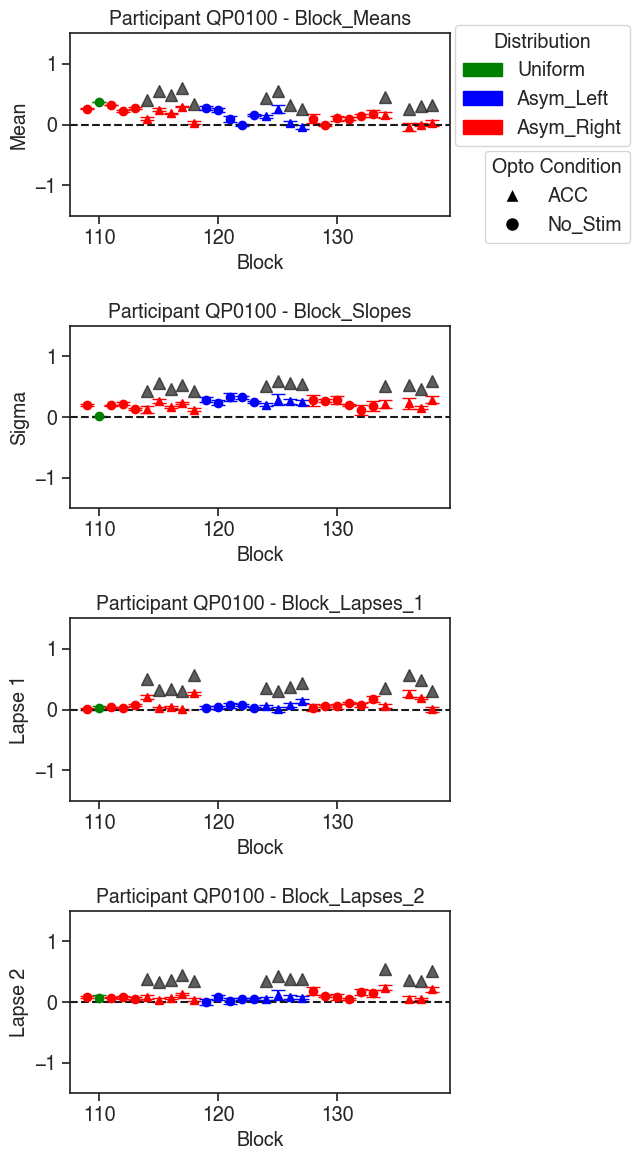

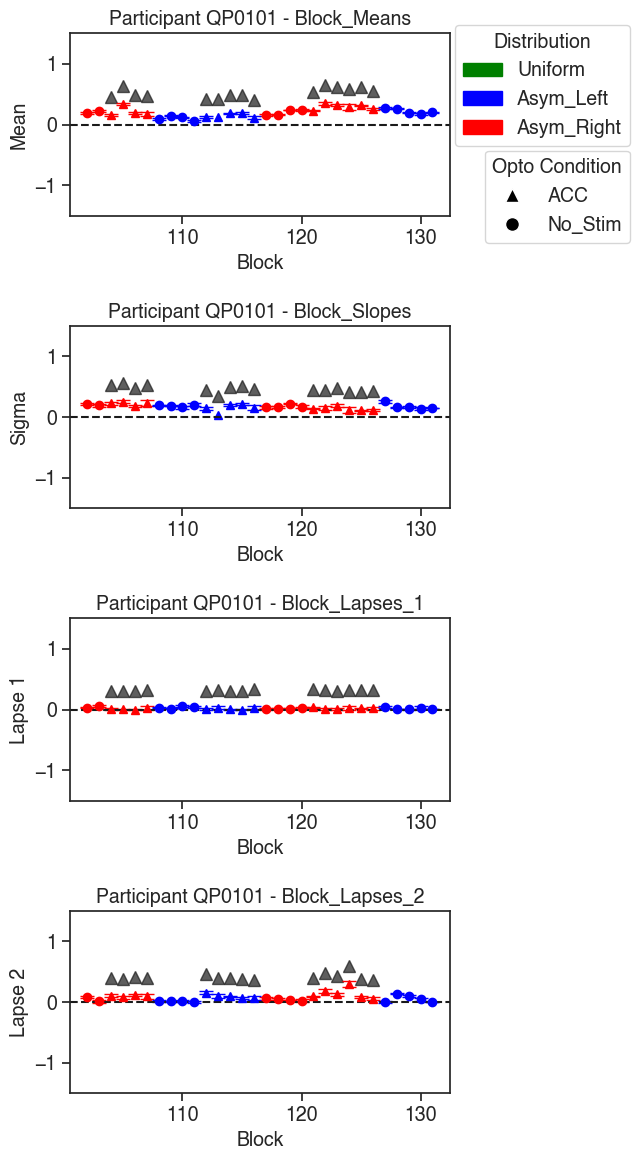

In [ ]:
color_dict = {'Uniform': 'green', 'Asym_Left': 'blue', 'Asym_Right': 'red'}

marker_dict = {
    'No_Stim': 'o',  # Circle
    'ACC': '^',  # Triangle up
    'PPC': 's'  # Square
}

metrics = ['Block_Means', 'Block_Slopes', 'Block_Lapses_1', 'Block_Lapses_2']
metric_std_devs = ['Block_Means_Std', 'Block_Slopes_Std', 'Block_Lapses_1_Std', 'Block_Lapses_2_Std']
y_label_dict = {
    'Block_Means': 'Mean',
    'Block_Slopes': 'Sigma',
    'Block_Lapses_1': 'Lapse 1',
    'Block_Lapses_2': 'Lapse 2'
}

# Define legends outside of the loop
distribution_patches = [Patch(color=color, label=distribution) for distribution, color in color_dict.items()]
opto_condition_markers = [Line2D([0], [0], marker=marker_dict[condition], color='w', label=condition, markerfacecolor='black', markersize=10) 
                          for condition in opto_conditions_encountered]

for participant in PARTICIPANTS:
    fig, axs = plt.subplots(4, 1, figsize=(8, 12))  # Create a 4-row subplot for each metric
    pid_df = psych_params_df[psych_params_df['Participant_ID'] == participant]
    
    # Only keep last n blocks
    pid_df = pid_df[pid_df['block'] > pid_df['block'].max() - 30]

    for metric_idx, metric in enumerate(metrics):
        ax = axs[metric_idx]
        metric_std = metric_std_devs[metric_idx]
        
        # Track opto conditions encountered for legend
        opto_conditions_encountered = set()
        
        for dist in pid_df['Distribution'].unique():
            dist_df = pid_df[pid_df['Distribution'] == dist].sort_values(by='block').reset_index(drop=True)
            
            try:
                for index, row in dist_df.iterrows():
                    marker = marker_dict[row['Opto_Condition']]
                    color = color_dict[dist]
                    if row[metric_std] <= error_threshold:
                        opto_conditions_encountered.add(row['Opto_Condition'])
                        ax.errorbar(x=row['block'], y=row[metric], yerr=row[metric_std],
                                    fmt=marker, ecolor=color, capsize=5, label=dist if marker == 'o' else "_nolegend_",
                                    color=color)
                    else:
                        ax.plot(row['block'], row[metric], marker, color=color, label=dist if marker == 'o' else "_nolegend_")
                    
                    # Plotting for specific conditions, adjust as necessary
                    if row['Opto_Condition'] in ['ACC', 'PPC']:
                        offset = 0.3 if row['Opto_Condition'] == 'ACC' else -0.3
                        ax.plot(row['block'], row[metric] + offset, marker_dict[row['Opto_Condition']],
                                color='k', markersize=8, alpha=0.7)

            except Exception as e:
                print(f'Participant {participant}, metric {metric} failed to plot: {e}')
        ax.set_title(f'Participant {participant} - {metric}')
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_ylim(-1.5, 1.5)
        ax.set_xlabel('Block')
        ax.set_ylabel(y_label_dict[metric])
        
        # Show legend only on the first plot
        if metric_idx == 0:
            legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='upper right', bbox_to_anchor=(1.5, 1.1))
            legend2 = ax.legend(handles=opto_condition_markers, title="Opto Condition", loc='lower right', bbox_to_anchor=(1.5, -0.2))
            ax.add_artist(legend1)  # Corrected usage

    plt.tight_layout()
    plt.show()


In [ ]:
# Break here
raise Exception('Break here')

Exception: Break here

## GLM weights for distribution switches

In [ ]:
# Isolate the data for the participants of interest
PARTICIPANTS = ['QP0100', 'QP0101']
sub_df = df[df['Participant_ID'].isin(PARTICIPANTS)]
# remove No_response trials
sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)

# find the earliest Date where Opto_Condition is not 'No_Stim'
earliest_stim = sub_df[sub_df['Opto_Condition'] != 'No_Stim']['Datetime'].min()
# find the most recent Date before the earliest Date where Opto_Condition is not 'No_Stim'
earliest_no_stim = sub_df[sub_df['Datetime'] < earliest_stim]['Datetime'].max()
# Keep data from earliest_no_stim onwards
sub_df = sub_df[sub_df['Datetime'] >= earliest_no_stim].reset_index(drop=True)

# filter data because of sleeve issue with QP0100
# remove data between blocks 96 and 105 (inclusive) for QP0100
sub_df = sub_df[~((sub_df['Participant_ID'] == 'QP0100') & (sub_df['block'] >= 96) & (sub_df['block'] <= 105))].reset_index(drop=True)
# remove rows where Opto_Condition is nan
sub_df = sub_df.dropna(subset=['Opto_Condition']).reset_index(drop=True)

In [ ]:
PARTICIPANT = 'QP0101'
sub_df = sub_df[sub_df['Participant_ID'] == PARTICIPANT]

# add previous n trials data
sub_df = sub_df.groupby('Participant_ID', group_keys= False).apply(add_previous_n_trials_data)

In [ ]:
columns_to_keep = [
                   'Date', 'Participant_ID','Trial', 'Stim_Relative', 'correct', 'No_response',
                   'First_Lick', 'P_Right','Response_Latency', 'Trial_Outcome',
                   'Anti_Bias','Timeout_Duration', 'Emulator', 'Distribution','Datetime',
                   'block', 'Incorrect', 'No_Response', 'choice', 'Rule_Right',
                   'Choice_Rule_Diff', 'stim_relative_binned', 'stim_relative_1',
                   'choice_1', 'correct_1', 'stim_relative_2', 'choice_2', 'correct_2',
                   'stim_relative_3', 'choice_3', 'correct_3', 'stim_relative_4',
                   'choice_4', 'correct_4', 'stim_relative_5', 'choice_5', 'correct_5'
                   ]
X, y = prep_GLM_data(sub_df, columns_to_keep, n_trials_back=5)

In [ ]:
conditions = sub_df['Opto_Condition'].unique()
all_coef_dfs = []

for condition in conditions:
    # Filter data for the current condition
    condition_df = sub_df[sub_df['Opto_Condition'] == condition]

    X, y = prep_GLM_data(condition_df, columns_to_keep, n_trials_back=5)

    # drop all previous stim columns from X
    X = X.drop(columns=[
        'stim_relative_1', 'stim_relative_2', 'stim_relative_3', 'stim_relative_4', 'stim_relative_5', 
                        ])

    mean_cv_score, log_reg_l1 = fit_GLM(X, y)

    print(f'Mean CV score for {condition}: {mean_cv_score}')

    coef_df = gen_coef_df(X, y, bootstrap_samples=10, n_folds=5)

    coef_df['Condition'] = condition  # Add a column to identify the condition

    all_coef_dfs.append(coef_df)

# Combine all coefficients dataframes into one
all_coef_df = pd.concat(all_coef_dfs, ignore_index=True)

Mean CV score for No_Stim: 0.8872133944758451
Mean CV score for ACC: 0.8793167625095787


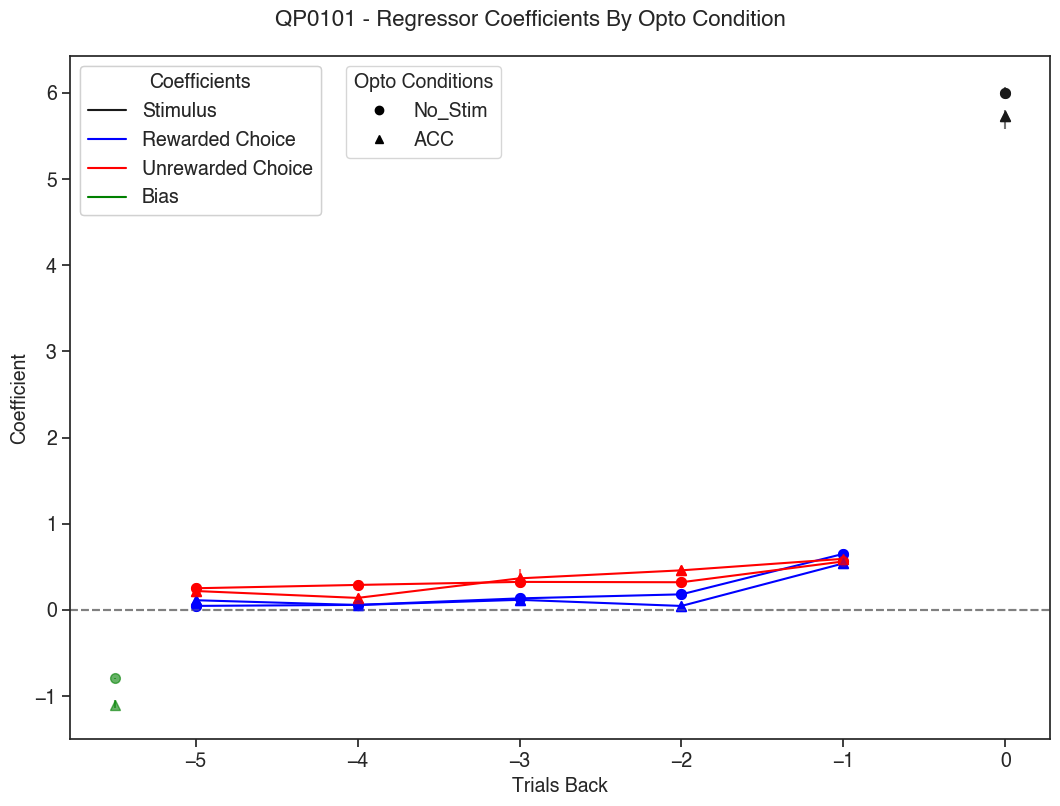

In [ ]:
color_label_dict = {
    'Stimulus': {'color': 'k', 'label': 'Stimulus'},  # Light Blue
    'Rewarded_Choice': {'color': 'blue', 'label': 'Rewarded Choice'},  # Light Green
    'Unrewarded_Choice': {'color': 'red', 'label': 'Unrewarded Choice'},  # Light Coral
    'Bias': {'color': 'green', 'label': 'Bias'}  # Light Goldenrod Yellow
}


# specify a marker dict for No_Stim, ACC and PPC
marker_dict = {
              'No_Stim': 'o',
              'ACC': '^',
            #   'PPC': 's'
              }

fig, ax = plt.subplots(figsize=(11, 8))
color_handles = []  # List to collect color legend handles
marker_handles = []  # List to collect marker legend handles

color_handles.extend(plot_GLM_weights(all_coef_df[all_coef_df['Condition'] == 'No_Stim'], 
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['No_Stim']))
color_handles.extend(plot_GLM_weights(all_coef_df[all_coef_df['Condition'] == 'ACC'], 
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['ACC']))
# color_handles.extend(plot_GLM_weights(all_coef_df[all_coef_df['Condition'] == 'PPC'], 
#                                       color_label_dict=color_label_dict,
#                                       ax=ax, marker=marker_dict['PPC']))

color_handles = [plt.Line2D([], [], color=color_info['color'], linestyle='-', label=color_info['label'])
                 for color_info in color_label_dict.values()]

for condition, marker in marker_dict.items():
    marker_handles.append(plt.Line2D([], [], color='black', marker=marker, linestyle='None', label=condition))

color_legend = ax.legend(handles=color_handles, loc='upper left', title="Coefficients")

ax.add_artist(color_legend)  # Manually add the color legend back
marker_legend = ax.legend(handles=marker_handles,
                           bbox_to_anchor=(0.45, 1),
                             title="Opto Conditions")

ax.add_artist(color_legend)

fig.suptitle(PARTICIPANT + ' - Regressor Coefficients By Opto Condition', fontsize=16, y=1.02)
plt.savefig(FIGS_PATH + PARTICIPANT + '_GLM_weights_by_opto_condition.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Break execution here
raise Exception('Execution stopped')

Exception: Execution stopped

## Learning for new mice

In [ ]:
def plot_perf_and_bias(df, Animal_List, save_path=None):
    """
    Creates and displays a plot showing performance and bias for each participant.
    
    :param df: The input dataframe
    :param Animal_List: The list of participant IDs to plot
    :param save_path: The file path to save the resulting plot, if None, plot is not saved
    """
    # Define the number of rows and columns for subplots
    n_rows = 3  # Number of rows
    n_cols = 5  # Number of columns
    filtered_df = df[df.No_response == False]

    # Create subplots with specified number of rows and columns
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 8 * n_rows))
    
    for i, participant_id in enumerate(Animal_List):
        participant_df = filtered_df[filtered_df.Participant_ID == participant_id]
        ax1 = axs.flatten()[i]
        sns.pointplot(data=participant_df, x='Date', y='correct', errorbar=('ci', 95), 
                      ax=ax1, scale=0.5, errwidth=1.5, color='k')
        
        ax1.set_title(f"Participant ID: {participant_id}", fontdict={'fontsize': 12})
        ax1.set_ylim(0, 1)
        # plot bias on a secondary y-axis
        ax2 = ax1.twinx()
        sns.pointplot(data=participant_df, x='Date', y='Choice_Rule_Diff', errorbar=('ci', 95), 
                      ax=ax2, scale=0.5, errwidth=1.5, color='r')
        ax2.set_ylim(-1, 1)
        # change label and tick color
        ax2.tick_params(axis='y', colors='r')
        ax2.set_ylabel('Bias', color='r', rotation=270, labelpad=15)
        # horizontal line at 0.5
        ax1.axhline(y=0.5, color='k', linestyle='--', label='Chance')
        ax1.set_ylabel('Proportion Correct', color='k')
        ax1.set_xlabel('Date', color='k')
        # rotate x-axis labels
        for tick in ax1.get_xticklabels():
            tick.set_rotation(45)
        # only show every 5th x-axis label
        for i, label in enumerate(ax1.xaxis.get_ticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

    # remove empty subplots
    for i in range(len(Animal_List), n_rows * n_cols):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# write a functions that return the proportion of rows that are Stim_Relative < 0 and Stim_Relative > 0
def get_prop_stim_rel(participant_df, stim_rel = 'Stim_Relative'):
    '''
    Get the proportion of rows that are Stim_Relative < 0 and Stim_Relative > 0
    Args:
        participant_df (pd.DataFrame): The dataframe to filter
        stim_rel (str): The column to filter on
    Returns:
        less_then_zero (float): The proportion of rows that are Stim_Relative < 0
        greater_then_zero (float): The proportion of rows that are Stim_Relative > 0
    '''

    less_then_zero = (participant_df[stim_rel] < 0).sum() / len(participant_df)
    greater_then_zero = (participant_df[stim_rel] > 0).sum() / len(participant_df)
    
    return less_then_zero, greater_then_zero

def run_binomial_test(df, p=0.5, alternative='two-sided', stim_rel = 'Stim_Relative'):
    '''
    Run a binomial test to check if the balance of trials presented on the left and right side is significantly different from 50/50
    Args:
        df (pd.DataFrame): The dataframe to filter
        p (float): The proportion of trials to test against
        alternative (str): The alternative hypothesis, either 'two-sided', 'greater', or 'less'
        stim_rel (str): The column to filter on
    Returns:
        p_value (float): The p-value of the binomial test
    '''

    # get number of trials presented on the left in block_df
    left_trials = df[df[stim_rel] < 0].shape[0]
    # get total number of trials in block_df
    total_trials = df.shape[0]
    result = binomtest(left_trials, total_trials, p=p, alternative=alternative)
    p_value = round(result.pvalue, 5)
    return p_value

In [ ]:
PARTICIPANTS = ['QP0121', 'QP0122']

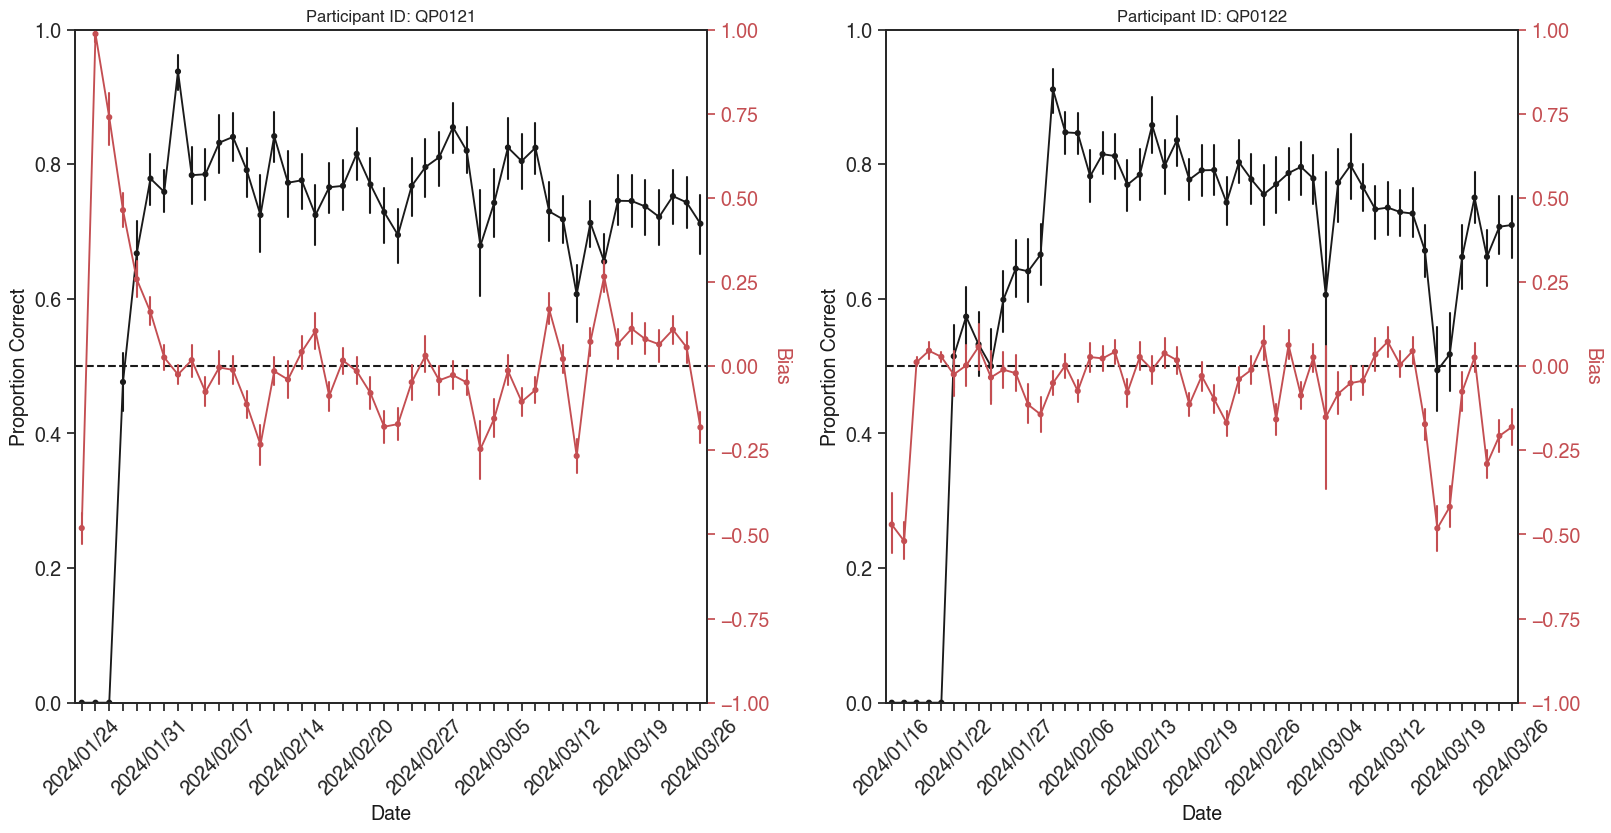

In [ ]:
plot_perf_and_bias(df, PARTICIPANTS, save_path= None)

In [ ]:
# Color dictionary for plots
color_dict = {'prop_correct': 'green', 'prop_incorrect': 'red', 'prop_no_response': 'k'}
step_size = 0.25
min_value = -0.875
# Function to calculate y-axis position for a given value
def calculate_y_position(value):
    return (value - min_value) / step_size
# Calculate y-axis positions for -1, 0, and 1
y_positions = [calculate_y_position(v) for v in [-1, 0, 1]]

for p_id in PARTICIPANTS:
    print(f'Processing participant {p_id}')
# for p_id in p_ids:
    save_path = FIGS_PATH + p_id + '_Choice_Behavior.pdf'
    participant_df = df[df['Participant_ID'] == p_id]
    with PdfPages(save_path) as pdf:

        for block in participant_df['block'].unique():
        # only select last 5 blocks
        # for block in participant_df['block'].unique()[-10:]:

            # Create a figure with two rows for the two sets of plots
            fig, axs = plt.subplots(2, 2, figsize=(22, 14), gridspec_kw={'width_ratios': [3, 1]}) 

            block_df = participant_df[participant_df['block'] == block]
            block_df = block_df.reset_index(drop=True)
            binomial_p_value = run_binomial_test(block_df, p=0.5, alternative='two-sided', stim_rel = 'Stim_Relative')
            if binomial_p_value > 0.05:
                L_R_ratio = 'Balanced'
            else:
                L_R_ratio = 'Unbalanced'
            
            ax1 = axs[0, 0]
            ax2 = axs[0, 1]

            correct_mask = block_df['correct'] == 1
            incorrect_mask = block_df['Incorrect'] == 1
            no_response_mask = block_df['No_response'] == 1

            ax1.scatter(block_df[correct_mask]['Trial'], block_df[correct_mask]['stim_relative_binned'], 
                        color='green', marker='o', label='Correct', alpha=0.5)
            ax1.scatter(block_df[incorrect_mask]['Trial'], block_df[incorrect_mask]['stim_relative_binned'], 
                        color='red', marker='^', label='Incorrect', alpha=0.5)
            ax1.scatter(block_df[no_response_mask]['Trial'], block_df[no_response_mask]['stim_relative_binned'], 
                        color='black', marker='x', label='No Response', alpha=0.5)
            ax1.set_yticks([-1, 0, 1])
            ax1.set_yticklabels(['-1', '0', '1'])
            ax1.set_ylim(-1, 1)
            ax1.set_xlabel('Trial')
            ax1.set_ylabel('Distance from Boundary')

            grouped_by_stim_rel = block_df[['stim_relative_binned', 'correct', 'Incorrect', 'No_Response']] \
                                    .groupby('stim_relative_binned').sum()
            grouped_by_stim_rel['total'] = grouped_by_stim_rel.sum(axis=1)
            grouped_by_stim_rel['prop_correct'] = grouped_by_stim_rel['correct'] / grouped_by_stim_rel['total']
            grouped_by_stim_rel['prop_incorrect'] = grouped_by_stim_rel['Incorrect'] / grouped_by_stim_rel['total']
            grouped_by_stim_rel['prop_no_response'] = grouped_by_stim_rel['No_Response'] / grouped_by_stim_rel['total']
            grouped_by_stim_rel = grouped_by_stim_rel[['prop_correct', 'prop_incorrect', 'prop_no_response']] 
            grouped_by_stim_rel.plot(kind='barh', stacked=True, ax=ax2, width=1, color=[color_dict.get(x) for x in grouped_by_stim_rel.columns], alpha=0.5, legend=False)

            below_above_proportions = get_prop_stim_rel(block_df, stim_rel = 'Stim_Relative')

            ax2.set_xlabel('Proportions')
            ax2.set_ylabel(' ')
            ax2.set_xticks(np.arange(0, 1.1, 0.5))
            ax2.set_yticks(y_positions)
            ax2.set_yticklabels([-1, 0, 1], rotation=0)

        # ----------------------- Plot 2 (Row 2) -----------------------
            valid_block_df = block_df[block_df['No_response'] == 0].reset_index(drop=True)

            ax3 = axs[1, 0]
            ax4 = axs[1, 1]

            correct_mask = valid_block_df['correct'] == 1
            incorrect_mask = valid_block_df['Incorrect'] == 1

            ax3.scatter(valid_block_df[correct_mask]['Trial'], valid_block_df[correct_mask]['stim_relative_binned'],
                        color='green', marker='o', label='Correct', alpha=0.5)
            ax3.scatter(valid_block_df[incorrect_mask]['Trial'], valid_block_df[incorrect_mask]['stim_relative_binned'],
                        color='red', marker='^', label='Incorrect', alpha=0.5)
            ax3.set_yticks([-1, 0, 1])
            ax3.set_yticklabels(['-1', '0', '1'])
            ax3.set_ylim(-1, 1)
            ax3.set_xlabel('Trial')
            ax3.set_ylabel('Distance from Boundary')

            grouped_by_stim_rel_valid = valid_block_df[['stim_relative_binned', 'correct', 'Incorrect']] \
                                    .groupby('stim_relative_binned').sum()
            grouped_by_stim_rel_valid['total'] = grouped_by_stim_rel_valid.sum(axis=1)
            grouped_by_stim_rel_valid['prop_correct'] = grouped_by_stim_rel_valid['correct'] / grouped_by_stim_rel_valid['total']
            grouped_by_stim_rel_valid['prop_incorrect'] = grouped_by_stim_rel_valid['Incorrect'] / grouped_by_stim_rel_valid['total']
            grouped_by_stim_rel_valid = grouped_by_stim_rel_valid[['prop_correct', 'prop_incorrect']] 
            try:
                grouped_by_stim_rel_valid.plot(kind='barh', stacked=True, ax=ax4, width=1, color=[color_dict.get(x) for x in grouped_by_stim_rel_valid.columns], 
                                            alpha=0.5, legend=False)
            except:
                pass
            
            ax4.set_xlabel('Proportions')
            ax4.set_ylabel(' ')
            ax4.set_xticks(np.arange(0, 1.1, 0.5))
            ax4.set_yticks(y_positions)
            ax4.set_yticklabels([-1, 0, 1], rotation=0)

            params = {
                'Parameter': ['Participant', 'Date', 'Block', 'Distribution', 'AntiBias', 'Prop Stim Rel < 0', 
                              'Prop Stim Rel > 0', 'Left/Right Ratio', 'Opto'],
                'Value': [p_id, block_df['Datetime'].iloc[0].strftime('%Y/%m/%d'), block, block_df['Distribution'].iloc[0], 
                          block_df['Anti_Bias'].iloc[0], round(below_above_proportions[0], 2), round(below_above_proportions[1], 2), 
                          L_R_ratio, block_df['Opto_On'].iloc[0]]
            }
            params_df = pd.DataFrame(params)
            table = ax1.table(cellText=params_df.values, colLabels=params_df.columns, cellLoc = 'center', loc='top', bbox=[0, 1.1, 1, 0.5])
            # Set font to Arial and make headers bold
            for key, cell in table.get_celld().items():
                if key[0] == 0:  # Column headers are in the first row
                    cell.set_fontsize(12)
                    cell.get_text().set_fontname('Arial')
                    cell.get_text().set_weight('bold')

            plt.tight_layout()
            pdf.savefig()
            plt.close()

Processing participant QP0121
Processing participant QP0122


### Psychometrics for each participant for the past n blocks


In [44]:
PARTICIPANTS =  ['QP0121', 'QP0122']
sub_df = df[df.Participant_ID.isin(PARTICIPANTS)]
# keep data where Nb_Of_Stim > 6
sub_df = sub_df[sub_df.Nb_Of_Stim > 6]
stages = ['Full_Task_Cont']
sub_df = sub_df[sub_df.Stage.isin(stages)]
# only keep data where Antibias is False
sub_df = sub_df[sub_df.Anti_Bias == False]


In [45]:
# plot psychometics 

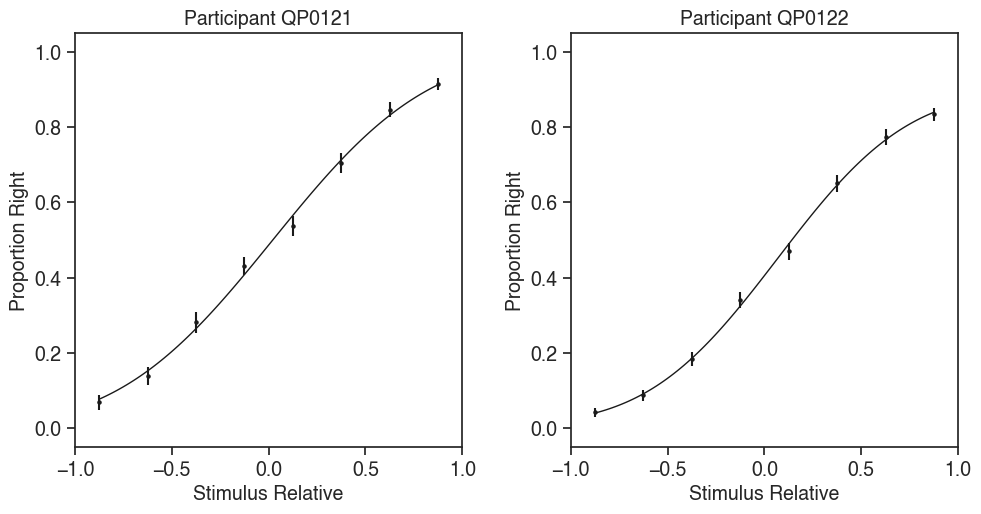

In [46]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, p_id in enumerate(PARTICIPANTS):
    axes[i // 4, i % 4].set_title(f'Participant {p_id}')
    try:
        popt = ut.psycho_fit(sub_df[sub_df['Participant_ID'] == p_id])[0]
        ut.psycho_plot(sub_df[sub_df['Participant_ID'] == p_id],  popt, label=None, color='k', ax=axes[i // 4, i % 4], legend=False)
        axes[i // 4, i % 4].set_ylim(-0.05, 1.05)
        axes[i // 4, i % 4].set_xlabel('Stimulus Relative')
        axes[i // 4, i % 4].set_ylabel('Proportion Right')
    except:
        print(f'Participant {p_id} failed to fit')

for i in range(len(PARTICIPANTS), 12):
    fig.delaxes(axes[i // 4, i % 4])

plt.tight_layout()
# plt.savefig(figs_path + 'ACC_PPC_Psychometrics_2023_11_29.pdf', dpi=300, bbox_inches='tight')
plt.show()

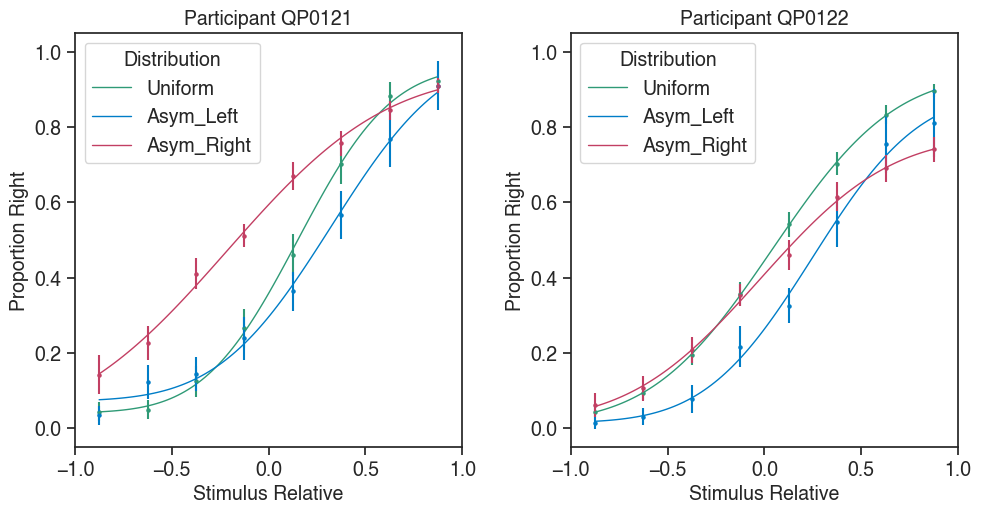

In [47]:
# Assuming PARTICIPANTS and sub_df are defined
color_dict = {
    'Uniform': '#2F9A76',
    'Asym_Left': '#007dc7',
    'Asym_Right': '#c23f63'
}

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, p_id in enumerate(PARTICIPANTS):
    axes[i // 4, i % 4].set_title(f'Participant {p_id}')
    
    # Filter the dataframe for the current participant
    participant_df = sub_df[sub_df['Participant_ID'] == p_id]
    
    for dist_type in color_dict.keys():
        # Filter by distribution type
        df_dist = participant_df[participant_df['Distribution'] == dist_type]
        
        try:
            # Fit the psychometric function to the distribution-specific data
            popt = ut.psycho_fit(df_dist)[0]
            # Plot the distribution-specific data with its associated color
            ut.psycho_plot(df_dist, popt, label=dist_type, color=color_dict[dist_type], ax=axes[i // 4, i % 4], legend=False)
        except Exception as e:
            print(f'Participant {p_id}, Distribution {dist_type} failed to fit: {e}')
    
    axes[i // 4, i % 4].set_ylim(-0.05, 1.05)
    axes[i // 4, i % 4].set_xlabel('Stimulus Relative')
    axes[i // 4, i % 4].set_ylabel('Proportion Right')
    
    # Optionally, add a legend if you want to label the distribution types
    axes[i // 4, i % 4].legend(title="Distribution")

# Remove unused axes
for i in range(len(PARTICIPANTS), 12):
    fig.delaxes(axes[i // 4, i % 4])

plt.tight_layout()
# plt.savefig(figs_path + 'ACC_PPC_Psychometrics_2023_11_29.pdf', dpi=300, bbox_inches='tight')
plt.show()


# Need to directly compare P(Stay) and GLM

In [ ]:
PARTICIPANT = 'QP098'
# DAT_LIM = '2024/02/01'
DATE = '2024/02/09'
sub_df = df[df['Participant_ID'] == PARTICIPANT]
# sub_df = sub_df[sub_df['Datetime'] > DAT_LIM]
sub_df = sub_df[sub_df['Datetime'] == DATE]	
np.random.seed(0)
COLS_TO_KEEP = ['Date', 'Participant_ID', 'Trial', 'Stim_Relative', 'correct', 'No_response',
                'Datetime', 'block', 'Incorrect', 'No_Response', 'choice', 'stim_relative_binned', 
                'stim_relative_1', 'choice_1', 'correct_1', 'stim_relative_2', 'choice_2', 'correct_2', 'stim_relative_3', 
                'choice_3', 'correct_3', 'stim_relative_4', 'choice_4', 'correct_4', 'stim_relative_5', 'choice_5', 'correct_5']
# sub_df['choice'] = sub_df['choice'].replace(0, -1)
# add previous n trials data
sub_df = sub_df.groupby('Participant_ID', group_keys= False).apply(add_previous_n_trials_data, n=5)
sub_df = sub_df.loc[:, COLS_TO_KEEP]
# replace all 0s with -1s in the choice column
X, y = prep_GLM_data(sub_df, COLS_TO_KEEP, n_trials_back=5)
coef_df = gen_coef_df(X, y, bootstrap_samples=2, n_folds=5)

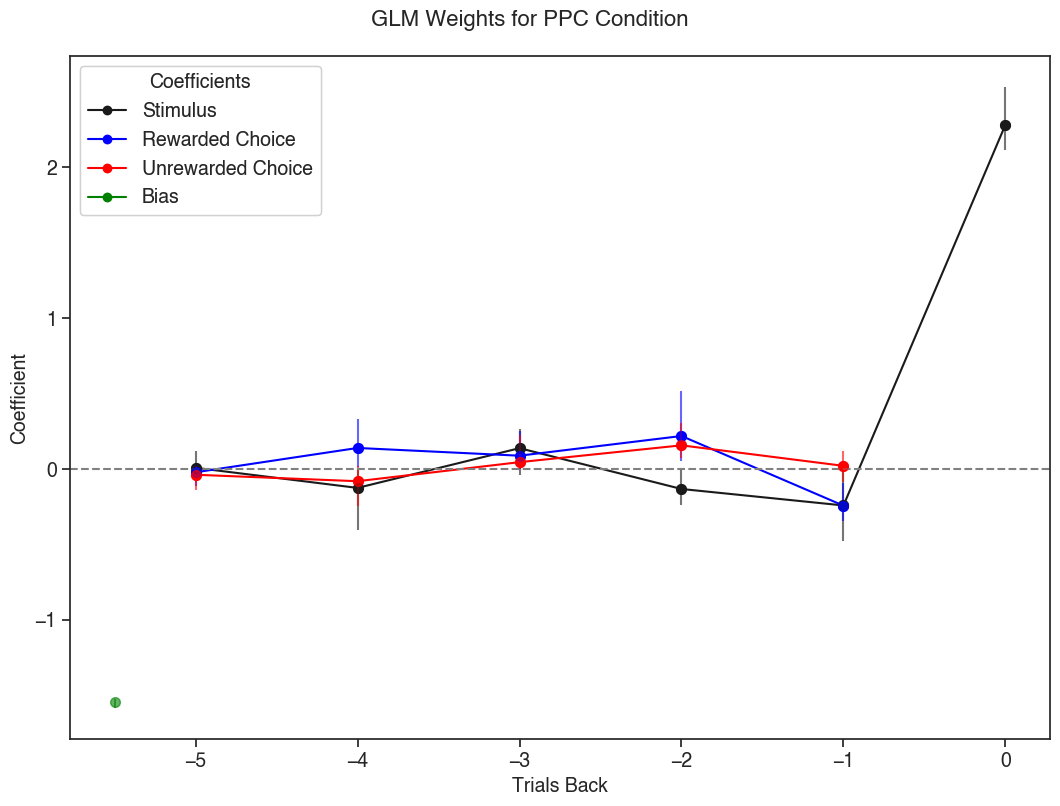

In [ ]:
color_label_dict = {
    'Stimulus': {'color': 'k', 'label': 'Stimulus'},  # Light Blue
    'Rewarded_Choice': {'color': 'blue', 'label': 'Rewarded Choice'},  # Light Green
    'Unrewarded_Choice': {'color': 'red', 'label': 'Unrewarded Choice'},  # Light Coral
    'Bias': {'color': 'green', 'label': 'Bias'}  # Light Goldenrod Yellow
}

marker_dict = {
              'No_Stim': 'o',
              'ACC': '^',
              'PPC': 's'
              }

fig, ax = plt.subplots(figsize=(11, 8))
color_handles = []  # List to collect color legend handles
# marker_handles = []  # List to collect marker legend handles

color_handles.extend(plot_GLM_weights(coef_df,
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['No_Stim']))


color_legend = ax.legend(handles=color_handles, loc='upper left', title="Coefficients")

ax.add_artist(color_legend) 

fig.suptitle(f'GLM Weights for {condition} Condition', fontsize=16, y=1.02)

plt.show()

In [ ]:
p_stay, p_stay_given_reward, p_stay_given_no_reward = compute_p_stay(sub_df)
p_stay, p_stay_given_reward, p_stay_given_no_reward

(0.4942528735632184, 0.5187637969094923, 0.6666666666666666)

In [ ]:
# 0 and 1 encoding

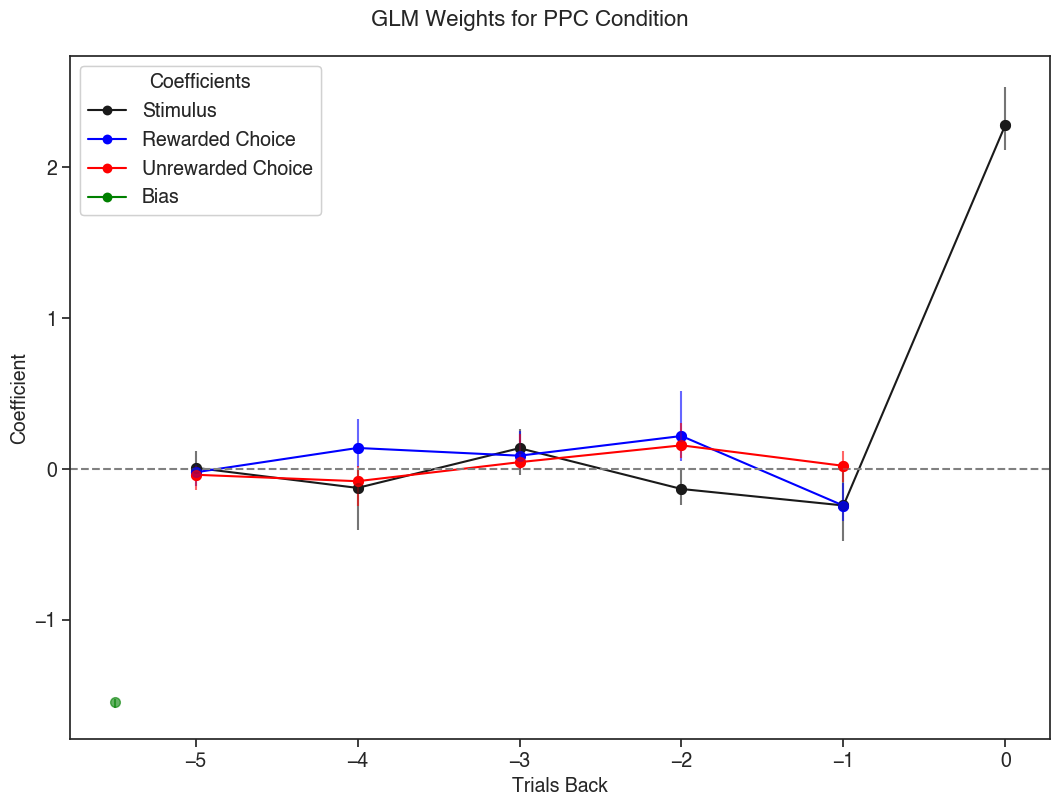

In [ ]:
fig, ax = plt.subplots(figsize=(11, 8))
color_handles = []  # List to collect color legend handles
# marker_handles = []  # List to collect marker legend handles

color_handles.extend(plot_GLM_weights(coef_df,
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['No_Stim']))


color_legend = ax.legend(handles=color_handles, loc='upper left', title="Coefficients")

ax.add_artist(color_legend) 

fig.suptitle(f'GLM Weights for {condition} Condition', fontsize=16, y=1.02)

plt.show()

In [ ]:
# I am analysing data from a sound categorization task, where a Stim_Relative (between -1 and 1) is presented to the participant.
# The participant has to categorize the sound as being higher or lower than 0. 
# if he succeeds, the correct = 1 and incorrect = 0.
# if he fails, the correct = 0 and incorrect = 1.
# if he does not respond, no_response = 1 and correct = np.nan and incorrect = np.nan
# the dataframe also has the Stim_Relative, correct, incorrect and choice for the 5 previous trials.
# these are labelled stim_relative_1, correct_1, incorrect_1, choice_1, stim_relative_2, correct_2, incorrect_2, choice_2, 
# stim_relative_3, correct_3, incorrect_3, choice_3, stim_relative_4, correct_4, incorrect_4, choice_4, 
# stim_relative_5, correct_5, incorrect_5, choice_5

In [ ]:
# I have decided to model the participant's choice (0 for left and 1 for right),
# as a function of the current Stim_Relative and the previous 5 Stim_Relative, 
# the previous 5 correct and the previous 5 incorrect choices.

# now let me break down my regressors:
# - Stim_Relative: the current Stim_Relative
# - stim_relative_1: the Stim_Relative of the previous trial
# etc...
# - Rewarded_Choice_1: t -1 if the participant's choice 1 trial back was left and rewarded, 1 if the participant's choice  1 trial back was right and rewarded,
# 0 if the participant's choice 1 trial back was not rewarded
# - Rewarded_Choice_2: t -2 if the participant's choice 2 trials back was left and rewarded, 2 if the participant's choice  2 trials back was right and rewarded,
# 0 if the participant's choice 2 trials back was not rewarded
# etc...
# - Unrewarded_Choice_1: t -1 if the participant's choice 1 trial back was left and unrewarded, 1 if the participant's choice  1 trial back was right and unrewarded,
# 0 if the participant's choice 1 trial back was rewarded
# - Unrewarded_Choice_2: t -2 if the participant's choice 2 trials back was left and unrewarded, 2 if the participant's choice  2 trials back was right and unrewarded,
# 0 if the participant's choice 2 trials back was rewarded
# I therefroe have 16 regressors
# 6 are continuous: Stim_Relative, stim_relative_1, stim_relative_2, stim_relative_3, stim_relative_4, stim_relative_5
# 10 are categorical: correct_1, correct_2, correct_3, correct_4, correct_5, 
# incorrect_1, incorrect_2, incorrect_3, incorrect_4, incorrect_5

# Tell me if my function below acheives what I have just described:

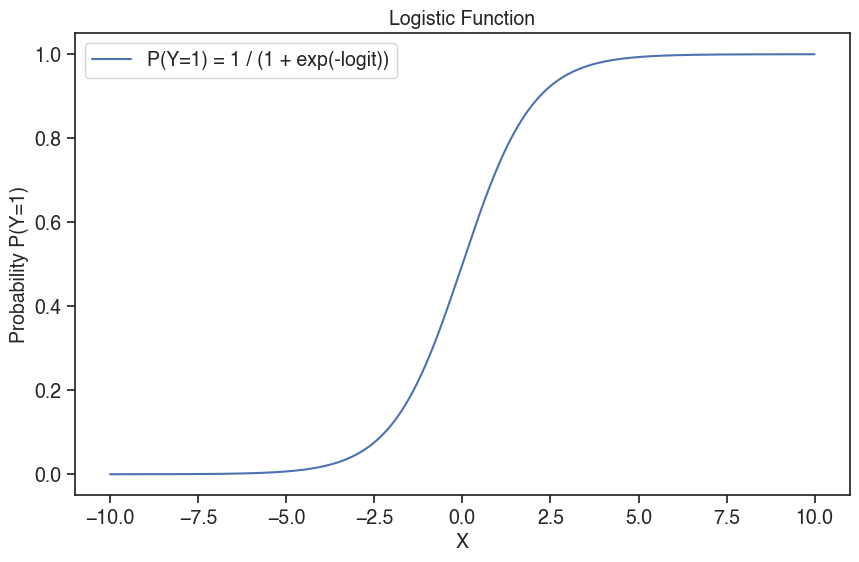

In [ ]:
# Generate an array of values for X
X = np.linspace(-10, 10, 400)

# Assume a coefficient of 1 for the predictor and an intercept of 0 for simplicity
coefficient = 1
intercept = 0

# Calculate the logit
logit = X * coefficient + intercept

# Apply the logistic function
prob_Y1 = 1 / (1 + np.exp(-logit))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(X, prob_Y1, label='P(Y=1) = 1 / (1 + exp(-logit))')

plt.title('Logistic Function')
plt.xlabel('X')
plt.ylabel('Probability P(Y=1)')
plt.legend()
# plt.grid(True)
plt.show()